# Setup for Figure S5A (right), B (right), D, G-K (Split Maze)

Note exact results for K-Means and decoder based analyses will change slightly each time due to stochasticity from randomized functions. As a result, exact statistics here may not match the manuscript text but should recapitulate results.

In [1]:
''' magic 4u'''
%load_ext autoreload
%autoreload 2

In [2]:
'''Get Stuff You Need'''
import numpy as np
import math as math
from tqdm import tnrange
from tqdm.notebook import tqdm as tdqm
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from matplotlib import gridspec
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import scipy.io
import scipy.ndimage.filters as filt
import pandas as pd
import seaborn as sns

from pipeline import get_data as get
from pipeline import process_spikes as ps

from statsmodels.tsa.stattools import acf
from scipy.signal import find_peaks
from itertools import combinations

from matplotlib import rc 
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['svg.fonttype'] = 'none'

In [3]:
''' Load Animal Metadata '''

animalmeta = pd.read_csv('C:/Users/Python/Desktop/LocalData/animalmeta.csv')
animalmeta.head()

,Animal_ID,Task,Cohort,Probe_Control,Sex,Sac_Date,Frozen_Hemisphere,DOB,Age_WholeMonth,Age_ExtraDays,...,Aged_Days,Age_Group,Behavior_Sessions,Neural_Sessions,Total_Cells,visualacuity,perchangespeedgain,perchangekurt,perchangeskew,perchangeIQR
0,A3,RF,A,0,F,1/27/2021,R,4/23/2019,21,4,...,645,3,6,6,1540.0,NaN,17.367862,NaN,NaN,NaN
1,A4,RF,A,0,F,1/27/2021,R,4/23/2019,21,4,...,645,3,6,6,1574.0,NaN,22.050636,NaN,NaN,NaN
2,A5,RF,A,0,F,4/6/2021,L,4/23/2019,23,14,...,714,3,6,6,1002.0,NaN,21.328531,NaN,NaN,NaN
3,A6,RF,A,0,F,4/6/2021,R,4/23/2019,23,14,...,714,3,6,6,985.0,NaN,15.687094,NaN,NaN,NaN
4,A7,RF,A,0,F,4/19/2021,L,5/29/2019,22,21,...,691,3,6,6,1691.0,NaN,52.102357,NaN,NaN,NaN


In [4]:
'''Find names of specific animals groups'''
all_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3),'Animal_ID'])
all_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2),'Animal_ID'])
all_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1),'Animal_ID'])

cohorta_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'A'),'Animal_ID'])
cohortb_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'B'),'Animal_ID'])
cohortc_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'C'),'Animal_ID'])
cohortd_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'D'),'Animal_ID'])

RF_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'SM'),'Animal_ID'])

all_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F'),'Animal_ID'])
all_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M'), 'Animal_ID'])
RF_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'SM'),'Animal_ID'])

In [5]:
''' Complete List of Mice & Sessions for Neural Data '''
all_mice = np.array(animalmeta.Animal_ID)

all_sessions = ([['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'], 
             ['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'],
             ['0401_record1','0401_record2b','0403_record3','0404_record4','0405_record5','0406_record6'],
             ['0401_record1','0402_record2','0403_record3','0404_record4','0405_record5','0406_record6'],
             ['0414_record1','0415_record2','0416_record3','0417_record4','0418_record5','0419_record6'],
             ['1024_record1','1025_record2','1026_record3','1027_record4','1028_record5_2'], #Y2_6 excluded
             ['1016_record1','1019_record3','1020_record4','1021_record5','1022_record6'], #Y3_2 not collected
             ['1114_record1','1115_record2','1116_record3','1117_record4','1118_record5','1119_record6'], # end cohort A
             ['051822_record1','051922_record2', '052022_record3','052122_record4','052222_record5','052322_record6'], 
             ['050522_record1','050622_record2','050722_record3','050822_record4','050922_record5','051022_record6'],
             ['050522_record1','050622_record2','050722_record3','050822_record4','051022_record6'], #Y11_5 not collected
             ['062222_record3','062322_record4','062522_record5'], #Y16_1 & 2 not collected, neural _6 excluded
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'],
             ['062022_record1','062122_record2','062222_record3','062322_record4','062522_record5','062622_record6'],
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'], 
             ['051922_record2','052022_record3'], # Y9 051822_record excluded for syncing issue, end cohort B
             ['083022_record1','083122_record2','090122_record3'], 
             ['083022_record1','083122_record2','090122_record3','090222_record4','090322_record5','090422_record6'],
             ['083022_record1','083122_record2','090122_record3','090222_record4'], #behavior of A16_4, both of 5 excluded, 6 not collected 
             ['082322_record1','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['082322_record1real','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['103122_record2','110122_record3','110222_record4','110322_record5rep','110422_record6','110522_record7'], #behavior of MA4M6, 7 excluded
             ['110622_record1','110722_record2','110822_record3','110922_record4','111022_record5','111122_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4','110322_record5','110422_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4'], #behavior of MA7_4, both 5 excluded, 6 not collected
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'], 
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'], #end cohortc
             ['012723_record2','012823_record3','012923_record4','013023_record5','013123_record6','020123_record7'],
             ['012623_record1','012723_record2','012823_record3','012923_record4','013023_record5','013123_record6'],
             ['012923_record2','013023_record3','013123_record4','020123_record5','020223_record6','020323_record7'],
             ['020923_record1','021023_record2','021123_record3','021223_record4','021323_record5','021423_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5rep','022123_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'] #end cohort d 
            ]) #list of sessions

In [6]:
'''Define which mice & sessions to load based on metadata'''
# Define mice, sessions for particular cohorts
mice , mice_ind, _  = np.intersect1d(all_mice, np.union1d(cohortc_mice, cohortd_mice), return_indices = True) # SM mice

sessions = []
for i in mice_ind:
    sessions.append(all_sessions[i])

# Make a dict to hold data
data = {}

for session, m in zip(sessions, mice):
    data[m] = {}
    
    for s in session:
        data[m][s] = {}

# Edit these paths

In [7]:
#Inputs
load_folder = 'C:/Users/Python/Desktop/LocalData/filtered/' # adjust path to match output of Import & Filter
shuffload_folder1 = 'C:/Users/Python/Desktop/Dryad/shuffle_scores/sparsity/' # adjust to match location of this Dryad repo folder
shuffload_folder2 = 'C:/Users/Python/Desktop/Dryad/shuffle_scores/coherence/' # adjust to match location of this Dryad repo folder
figs2_folder = 'C:/Users/Python/Desktop/LocalData/FigureS2/' # adjust to match Figure S2 output folder
fig2s3_folder = 'C:/Users/Python/Desktop/LocalData/Figure2S3/' # adjust to match Figure 2/S3 output folder
fig3s4_folder = 'C:/Users/Python/Desktop/LocalData/Figure3S4/' # adjust to match Figure 3/S4 output folder
fig5_folder = 'C:/Users/Python/Desktop/LocalData/Figure5/' # adjust to match Figure 5 output
int_save_folder = 'C:/Users/Python/Desktop/LocalData/FigureS6/' # adjust to match Shuffle Procedure output plotsave_folder

#Output (create folder to hold the output of this notebook; then match the name of this repository below)
save_folder = 'C:/Users/Python/Desktop/LocalData/FigureS5/' 

In [8]:
''' Load saved indices corresponding to quarters of the task sorted by context, excluding skipped trials ''' 

for m, session in zip(mice,sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #define file names
        Aidx_file = 'Aidx_' + m + '_' + s +'.npy'
        Bidx_file = 'Bidx_' + m + '_' + s +'.npy'
        A_idx_file = 'A_idx_' + m + '_' + s +'.npy'
        B_idx_file = 'B_idx_' + m + '_' + s +'.npy'
        A_ngidx_file = 'A_idx_' + m + '_' + s +'.npy'
        B_ngidx_file = 'B_idx_' + m + '_' + s +'.npy'
        
        #load saved indices for session section
        d['Aidx'] = np.load(figs2_folder + Aidx_file)
        d['Bidx'] = np.load(figs2_folder + Bidx_file)
        d['A_idx'] = np.load(figs2_folder + A_idx_file)
        d['B_idx'] = np.load(figs2_folder + B_idx_file)
                
        d['A_ngidx'] = np.load(figs2_folder + A_ngidx_file)
        d['B_ngidx'] = np.load(figs2_folder + B_ngidx_file)
        

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [9]:
''' Generate behavioral data for block & alternation'''

#get lick & reward data
rewarda_centers = []
rewardb_centers = []

for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
 
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        d['reward_data'] = {}
        
        # get behavioral params
        posx = raw.item().get('posx')
        post = raw.item().get('post')
        dt = np.unique(np.round(np.diff(post),4))
        lickt = raw.item().get('lickt')
        trials_dark = np.sum(raw.item().get('trialinfo')['dark'])
        reward = raw.item().get('reward')
        reward['trials'] = np.arange(0,len(reward['trials']),1) # fixes occassional Unity error numbering of rewards 
        
        if len(dt) > 1: # discard duplicate frame entries if they occurred
            dt = dt[dt != 0]
        speed = raw.item().get('speed')
        
        # get reward params & remove reward data pertaining to dark trials & skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            trial = raw.item().get('correctedtrial')
            
            if (len(np.unique(trial)) < 220): 
                alltrial = np.arange(0,np.max(np.unique(trial)) + 1 , 1)
            else:    
                alltrial = np.arange(0,220,1)
                
            skippedtrials = get.find_skipped(trial, max_trial_num = 220)
            nonskipped = np.setdiff1d(reward['trials'],skippedtrials)   
            k_idx = np.intersect1d(np.where(reward['trials'] > trials_dark), nonskipped)
            keep_idx = np.intersect1d(np.where(reward['trials'] <= np.max(alltrial)), k_idx)
            
        except AttributeError:
            trial = raw.item().get('trial')
            keep_idx = (np.where(reward['trials'] > trials_dark))
        
        reward_centers = np.array(reward['centers'][keep_idx])
        rewardt = reward['times'][keep_idx]
        reward_trials = reward['trials'][keep_idx]
        misses = reward['missed'][keep_idx].astype(bool)
        auto_reward = np.array(reward['auto'][keep_idx])
        #print('Mouse ' + m + ' with n_misses: ' + str(np.sum(misses)))   

        # get lick and reward indices
        lick_ct = get.spiketrain(post, dt, lickt, index=False)
        d['reward_data']['lick_ct'] = lick_ct
        #print('got lick indices for mouse ' + m + ' session ' + s)
        
        reward_idx = get.rewardtrain(post, dt, rewardt, index=True) #gets reward ct for each time binned position range as index
        d['reward_data']['reward_idx'] = reward_idx
        #print('got reward indices for mouse ' + m + ' session ' + s)
    
    # saves list of reward locations per mouse
    if reward['centers'][0] == 270:
        rewarda_centers = np.append(rewarda_centers,270)
        rewardb_centers = np.append(rewardb_centers,370)
    else:
        rewarda_centers = np.append(rewarda_centers,370)
        rewardb_centers = np.append(rewardb_centers,270)            
        
#Find & Save Number of Missed Rewards per Session & Animal
#block array
blocksatiety = []
blockreq = []
blocktrialn = []

#session arrays
req_rates = []
reqa_rates = []
reqb_rates = []
reqblock_rates = []
reqalt_rates = []
reqalta_rates = []
reqaltb_rates = []
req_trials = []
reqblock_trials = []
reqalt_trials = []

#animals arrays
mreq_rates = []
mreqa_rates = []
mreqb_rates = []
mreqblock_rates = []
mreqalt_rates = []
mreqalta_rates = []
mreqaltb_rates = []

for m, session in zip(mice, sessions):
    rt = []
    ca = []
    cb = []
    blocks = []
    alt = []
    alta = []
    altb = []
    
    req = []
    reqa = []
    reqb = []
    reqblocks = []
    reqalt = []
    reqalta = []
    reqaltb = []
    
    for s in session:
        # get behavior data
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        posx = raw.item().get('posx')
        post = raw.item().get('post')
        dt = np.unique(np.round(np.diff(post),4))
        if len(dt) > 1: # discard duplicate frame entries if they occurred
            dt = dt[dt != 0]
        speed = raw.item().get('speed')
        
        # get reward params & remove reward data pertaining to dark trials & skipped trials
        lickt = raw.item().get('lickt')
        trials_dark = np.sum(raw.item().get('trialinfo')['dark'])
        reward = raw.item().get('reward')
        reward['trials'] = np.arange(0,len(reward['trials']),1)
        
        # get reward params & remove reward data pertaining to dark trials & skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            trial = raw.item().get('correctedtrial')
            
            if (len(np.unique(trial)) < 220): 
                alltrial = np.arange(0,np.max(np.unique(trial)) + 1 , 1)
            else:    
                alltrial = np.arange(0,220,1)
                
            skippedtrials = get.find_skipped(trial, max_trial_num = 220)
            nonskipped = np.setdiff1d(reward['trials'],skippedtrials)   
            k_idx = np.intersect1d(np.where(reward['trials'] > trials_dark), nonskipped)
            keep_idx = np.intersect1d(np.where(reward['trials'] <= np.max(alltrial)), k_idx)
            
        except AttributeError:
            skippedtrials = []
            trial = raw.item().get('trial')
            keep_idx = (np.where(reward['trials'] > trials_dark))
        
        reward_centers = np.array(reward['centers'][keep_idx])
        rewarda = reward_centers[0]
        rewardb = reward_centers[60]
        rewardt = reward['times'][keep_idx]
        reward_trials = reward['trials'][keep_idx]
        misses = reward['missed'][keep_idx].astype(bool)
        requests = ~misses
        
        # find rate of requests for a given session
        req_rates.append(np.sum(requests)/len(reward_trials)) #total
        
        rewarda_idx = np.where(reward_trials < 81)[0]
        reqa_rates.append(np.sum(requests[rewarda_idx])/len(rewarda_idx)) #context a
        
        rewardb_idx = np.intersect1d((np.where(reward_trials >= 81)), (np.where(reward_trials <= 140)))
        reqb_rates.append(np.sum(requests[rewardb_idx])/len(rewardb_idx)) #context b
        
        block_idx = np.where(reward_trials < 140)[0]
        reqblock_rates.append(np.sum(requests[block_idx])/len(block_idx)) #block
        
        alt_idx = np.where(reward_trials >= 140)[0]
        reqalt_rates.append(np.sum(requests[alt_idx])/len(alt_idx)) #alt
        
        alta_idx = np.where((reward_trials >= 140) & (reward_centers == rewarda))[0] 
        reqalta_rates.append(np.mean(requests[alta_idx]))
        
        altb_idx = np.where((reward_trials >= 140) & (reward_centers == rewardb))[0]
        reqaltb_rates.append(np.mean(requests[altb_idx]))
        
        rt = np.append(rt,len(reward_trials))
        ca = np.append(ca,len(rewarda_idx))
        cb = np.append(cb,len(rewardb_idx))
        blocks = np.append(blocks,len(block_idx))
        alt = np.append(alt,len(alt_idx))
        alta = np.append(alta, len(alta_idx))
        altb = np.append(altb, len(altb_idx))
        
        req_trials = np.append(req_trials, len(reward_trials))
        reqblock_trials = np.append(reqblock_trials, len(block_idx))
        reqalt_trials = np.append(reqalt_trials, len(alt_idx))
        
        d['altreqbytrial'] = requests[alt_idx]
        
        req = np.append(req,np.sum(requests))
        reqa = np.append(reqa,np.sum(requests[rewarda_idx]))
        reqb = np.append(reqb,np.sum(requests[rewardb_idx]))
        reqblocks = np.append(reqblocks,np.sum(requests[block_idx]))
        reqalt = np.append(reqalt,np.sum(requests[alt_idx]))
        reqalta = np.append(reqalta,requests[alta_idx])
        reqaltb = np.append(reqaltb,requests[altb_idx])
        
        # append req rates from blocks into block req array len(4 x total sessions)
        blockreq = np.append(blockreq, np.mean(requests[rewarda_idx])) # block 1
        blockreq = np.append(blockreq, np.mean(requests[rewardb_idx])) # block 2
        blockreq = np.append(blockreq, np.mean(requests[alta_idx])) # block 3
        blockreq = np.append(blockreq, np.mean(requests[altb_idx])) # block 4   
        
        blocktrialn = np.append(blocktrialn, len(requests[rewarda_idx]))
        blocktrialn = np.append(blocktrialn, len(requests[rewardb_idx]))
        blocktrialn = np.append(blocktrialn, len(requests[alta_idx]))
        blocktrialn = np.append(blocktrialn, len(requests[altb_idx]))
        
        # append reward counts from previous task block into block satiety array len(4 x total sessions)
        blocksatiety = np.append(blocksatiety, 0) #no rewards before block a for every animal
        blocksatiety = np.append(blocksatiety, np.sum(requests[rewarda_idx])) # count of rewards consumed before block b
        blocksatiety = np.append(blocksatiety, (np.sum(requests[rewarda_idx]) + np.sum(requests[rewardb_idx]))) # before alta
        blocksatiety = np.append(blocksatiety, (np.sum(requests[rewarda_idx]) + np.sum(requests[rewardb_idx]) + np.sum(requests[alta_idx]))) # beforealtb             
                          
    # get mouse request rate collapsing days
    mreqrate = np.sum(req)/ np.sum(rt)
    mreq_rates = np.append(mreq_rates,mreqrate)
    
    mreqarate = np.sum(reqa) / np.sum(ca)
    mreqa_rates = np.append(mreqa_rates, mreqarate)
    
    mreqbrate = np.sum(reqb) / np.sum(cb)
    mreqb_rates = np.append(mreqb_rates, mreqbrate)
    
    mreqblockrate = np.sum(reqblocks) / np.sum(blocks)
    mreqblock_rates = np.append(mreqblock_rates, mreqblockrate)
    
    mreqaltrate = np.sum(reqalt) / np.sum(alt)
    mreqalt_rates = np.append(mreqalt_rates, mreqaltrate)
    
    mreqalta_rates = np.append(mreqalta_rates, np.mean(reqalta))
    mreqaltb_rates = np.append(mreqaltb_rates, np.mean(reqaltb))

In [10]:
''' Load spatial cell (Figure 2/S3) and intn (Shuffle Procedure) booleans generated by previous notebooks. '''

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #get file names
        spatialcell99_file = 'spatialcell99_' + m + '_' + s + '.npy'
        intn_file = 'intn_' + m + '_' + s + '.npy'

        #load stuff
        d['spatialcell99'] = np.load(figs2_folder + spatialcell99_file, allow_pickle = True)
        d['intn'] = np.load(int_save_folder + intn_file, allow_pickle = True)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [11]:
''' Load saved grid & ngs cell booleans generated by Figure 2 / S3 notebook '''

pergrid = []
perngs = []

spergrid = []
sperngs = []
mpergrid = []

for m, session in zip(mice,sessions):
    
    m_pergrid = []
    m_cells = []
    
    for s in tdqm(session):
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        #load all grid cell boolean
        gridcell_file = 'gridcell__' + m + '_' + s + '.npy'
        gridcell = np.load(figs2_folder + gridcell_file)
        
        ngscell_file = 'bordercell__' + m + '_' + s + '.npy'
        ngscell = np.load(figs2_folder + ngscell_file)
        
        gridcell = gridcell.astype(bool)
        ngscell = ngscell.astype(bool)
        d['gridcell'] = gridcell
        d['ngscell'] = ngscell
        
        print(m + ', ' + s + ' n grid, ngs cells: '+ str(np.sum(gridcell)) + ' , ' + str(np.sum(ngscell)))
        perngs = np.append(perngs, 100*np.sum(ngscell)/len(cell_IDs))
        pergrid = np.append(pergrid, 100*np.sum(gridcell)/len(cell_IDs))
        
        sperngs = np.append(sperngs, 100*np.sum(ngscell)/len(cell_IDs))
        spergrid = np.append(spergrid, 100*np.sum(gridcell)/len(cell_IDs))
        m_pergrid = np.append(m_pergrid, np.sum(gridcell))
        m_cells = np.append(m_cells, len(cell_IDs))
        
    
    mpergrid = np.append(mpergrid, np.sum(m_pergrid)/np.sum(m_cells)*100)

  0%|          | 0/3 [00:00<?, ?it/s]

A14, 083022_record1 n grid, ngs cells: 8 , 50
A14, 083122_record2 n grid, ngs cells: 35 , 2
A14, 090122_record3 n grid, ngs cells: 17 , 13


  0%|          | 0/6 [00:00<?, ?it/s]

A15, 083022_record1 n grid, ngs cells: 4 , 6
A15, 083122_record2 n grid, ngs cells: 86 , 33
A15, 090122_record3 n grid, ngs cells: 89 , 37
A15, 090222_record4 n grid, ngs cells: 128 , 65
A15, 090322_record5 n grid, ngs cells: 37 , 30
A15, 090422_record6 n grid, ngs cells: 24 , 19


  0%|          | 0/4 [00:00<?, ?it/s]

A16, 083022_record1 n grid, ngs cells: 19 , 23
A16, 083122_record2 n grid, ngs cells: 60 , 36
A16, 090122_record3 n grid, ngs cells: 0 , 1
A16, 090222_record4 n grid, ngs cells: 12 , 42


  0%|          | 0/6 [00:00<?, ?it/s]

A17, 082322_record1 n grid, ngs cells: 1 , 2
A17, 082422_record2 n grid, ngs cells: 2 , 6
A17, 082522_record3 n grid, ngs cells: 40 , 35
A17, 082622_record4 n grid, ngs cells: 42 , 17
A17, 082722_record5 n grid, ngs cells: 32 , 21
A17, 082822_record6 n grid, ngs cells: 54 , 25


  0%|          | 0/6 [00:00<?, ?it/s]

A18, 082322_record1real n grid, ngs cells: 13 , 10
A18, 082422_record2 n grid, ngs cells: 66 , 169
A18, 082522_record3 n grid, ngs cells: 68 , 117
A18, 082622_record4 n grid, ngs cells: 44 , 64
A18, 082722_record5 n grid, ngs cells: 47 , 10
A18, 082822_record6 n grid, ngs cells: 0 , 5


  0%|          | 0/6 [00:00<?, ?it/s]

A19, 012723_record2 n grid, ngs cells: 17 , 1
A19, 012823_record3 n grid, ngs cells: 22 , 75
A19, 012923_record4 n grid, ngs cells: 34 , 64
A19, 013023_record5 n grid, ngs cells: 54 , 38
A19, 013123_record6 n grid, ngs cells: 35 , 18
A19, 020123_record7 n grid, ngs cells: 54 , 31


  0%|          | 0/6 [00:00<?, ?it/s]

A20, 012623_record1 n grid, ngs cells: 3 , 18
A20, 012723_record2 n grid, ngs cells: 24 , 50
A20, 012823_record3 n grid, ngs cells: 69 , 56
A20, 012923_record4 n grid, ngs cells: 21 , 42
A20, 013023_record5 n grid, ngs cells: 22 , 55
A20, 013123_record6 n grid, ngs cells: 9 , 32


  0%|          | 0/6 [00:00<?, ?it/s]

A22, 012923_record2 n grid, ngs cells: 58 , 39
A22, 013023_record3 n grid, ngs cells: 79 , 122
A22, 013123_record4 n grid, ngs cells: 55 , 46
A22, 020123_record5 n grid, ngs cells: 10 , 12
A22, 020223_record6 n grid, ngs cells: 31 , 38
A22, 020323_record7 n grid, ngs cells: 12 , 5


  0%|          | 0/6 [00:00<?, ?it/s]

A23, 020923_record1 n grid, ngs cells: 4 , 10
A23, 021023_record2 n grid, ngs cells: 27 , 63
A23, 021123_record3 n grid, ngs cells: 29 , 66
A23, 021223_record4 n grid, ngs cells: 9 , 3
A23, 021323_record5 n grid, ngs cells: 27 , 38
A23, 021423_record6 n grid, ngs cells: 50 , 54


  0%|          | 0/6 [00:00<?, ?it/s]

A24, 022623_record1 n grid, ngs cells: 41 , 34
A24, 022723_record2 n grid, ngs cells: 108 , 65
A24, 022823_record3 n grid, ngs cells: 61 , 63
A24, 030123_record4 n grid, ngs cells: 66 , 37
A24, 030223_record5 n grid, ngs cells: 53 , 26
A24, 030323_record6 n grid, ngs cells: 20 , 19


  0%|          | 0/6 [00:00<?, ?it/s]

MA10F, 111322_record1 n grid, ngs cells: 69 , 91
MA10F, 111422_record2 n grid, ngs cells: 52 , 48
MA10F, 111522_record3 n grid, ngs cells: 38 , 24
MA10F, 111622_record4 n grid, ngs cells: 19 , 24
MA10F, 111722_record5 n grid, ngs cells: 17 , 28
MA10F, 111822_record6 n grid, ngs cells: 39 , 61


  0%|          | 0/6 [00:00<?, ?it/s]

MA1F, 102322_record1 n grid, ngs cells: 33 , 25
MA1F, 102422_record2 n grid, ngs cells: 53 , 28
MA1F, 102522_record3 n grid, ngs cells: 48 , 21
MA1F, 102622_record4 n grid, ngs cells: 9 , 8
MA1F, 102722_record5 n grid, ngs cells: 71 , 52
MA1F, 102822_record6 n grid, ngs cells: 72 , 28


  0%|          | 0/6 [00:00<?, ?it/s]

MA2F, 102322_record1 n grid, ngs cells: 47 , 76
MA2F, 102422_record2 n grid, ngs cells: 38 , 103
MA2F, 102522_record3 n grid, ngs cells: 50 , 110
MA2F, 102622_record4 n grid, ngs cells: 39 , 65
MA2F, 102722_record5 n grid, ngs cells: 38 , 43
MA2F, 102822_record6 n grid, ngs cells: 40 , 49


  0%|          | 0/6 [00:00<?, ?it/s]

MA3M, 102322_record1 n grid, ngs cells: 6 , 22
MA3M, 102422_record2 n grid, ngs cells: 28 , 53
MA3M, 102522_record3 n grid, ngs cells: 36 , 47
MA3M, 102622_record4 n grid, ngs cells: 13 , 55
MA3M, 102722_record5 n grid, ngs cells: 12 , 30
MA3M, 102822_record6 n grid, ngs cells: 31 , 39


  0%|          | 0/6 [00:00<?, ?it/s]

MA4M, 103122_record2 n grid, ngs cells: 24 , 68
MA4M, 110122_record3 n grid, ngs cells: 29 , 27
MA4M, 110222_record4 n grid, ngs cells: 8 , 13
MA4M, 110322_record5rep n grid, ngs cells: 26 , 18
MA4M, 110422_record6 n grid, ngs cells: 36 , 35
MA4M, 110522_record7 n grid, ngs cells: 12 , 9


  0%|          | 0/6 [00:00<?, ?it/s]

MA5M, 110622_record1 n grid, ngs cells: 58 , 30
MA5M, 110722_record2 n grid, ngs cells: 62 , 55
MA5M, 110822_record3 n grid, ngs cells: 79 , 30
MA5M, 110922_record4 n grid, ngs cells: 7 , 11
MA5M, 111022_record5 n grid, ngs cells: 23 , 25
MA5M, 111122_record6 n grid, ngs cells: 22 , 23


  0%|          | 0/6 [00:00<?, ?it/s]

MA6M, 103022_record1 n grid, ngs cells: 22 , 75
MA6M, 103122_record2 n grid, ngs cells: 17 , 39
MA6M, 110122_record3 n grid, ngs cells: 64 , 66
MA6M, 110222_record4 n grid, ngs cells: 7 , 13
MA6M, 110322_record5 n grid, ngs cells: 10 , 6
MA6M, 110422_record6 n grid, ngs cells: 39 , 31


  0%|          | 0/4 [00:00<?, ?it/s]

MA7M, 103022_record1 n grid, ngs cells: 31 , 36
MA7M, 103122_record2 n grid, ngs cells: 32 , 56
MA7M, 110122_record3 n grid, ngs cells: 19 , 28
MA7M, 110222_record4 n grid, ngs cells: 7 , 7


  0%|          | 0/6 [00:00<?, ?it/s]

MA8F, 111322_record1 n grid, ngs cells: 19 , 8
MA8F, 111422_record2 n grid, ngs cells: 62 , 67
MA8F, 111522_record3 n grid, ngs cells: 80 , 26
MA8F, 111622_record4 n grid, ngs cells: 25 , 37
MA8F, 111722_record5 n grid, ngs cells: 10 , 29
MA8F, 111822_record6 n grid, ngs cells: 12 , 20


  0%|          | 0/6 [00:00<?, ?it/s]

MA9F, 111322_record1 n grid, ngs cells: 56 , 29
MA9F, 111422_record2 n grid, ngs cells: 73 , 169
MA9F, 111522_record3 n grid, ngs cells: 119 , 80
MA9F, 111622_record4 n grid, ngs cells: 0 , 1
MA9F, 111722_record5 n grid, ngs cells: 24 , 34
MA9F, 111822_record6 n grid, ngs cells: 23 , 16


  0%|          | 0/6 [00:00<?, ?it/s]

Y20, 092522_record1 n grid, ngs cells: 7 , 7
Y20, 092622_record2 n grid, ngs cells: 32 , 39
Y20, 092722_record3 n grid, ngs cells: 13 , 10
Y20, 092822_record4 n grid, ngs cells: 51 , 33
Y20, 092922_record5 n grid, ngs cells: 19 , 14
Y20, 093022_record6 n grid, ngs cells: 85 , 64


  0%|          | 0/6 [00:00<?, ?it/s]

Y21, 091822_record1 n grid, ngs cells: 103 , 76
Y21, 091922_record2 n grid, ngs cells: 80 , 93
Y21, 092022_record3 n grid, ngs cells: 49 , 23
Y21, 092122_record4 n grid, ngs cells: 60 , 62
Y21, 092222_record5 n grid, ngs cells: 42 , 50
Y21, 092322_record6 n grid, ngs cells: 8 , 21


  0%|          | 0/6 [00:00<?, ?it/s]

Y22, 092522_record1 n grid, ngs cells: 85 , 57
Y22, 092622_record2 n grid, ngs cells: 146 , 66
Y22, 092722_record3 n grid, ngs cells: 60 , 84
Y22, 092822_record4 n grid, ngs cells: 24 , 21
Y22, 092922_record5 n grid, ngs cells: 20 , 25
Y22, 093022_record6 n grid, ngs cells: 60 , 36


  0%|          | 0/6 [00:00<?, ?it/s]

Y23, 092522_record1 n grid, ngs cells: 38 , 27
Y23, 092622_record2 n grid, ngs cells: 33 , 23
Y23, 092722_record3 n grid, ngs cells: 30 , 40
Y23, 092822_record4 n grid, ngs cells: 26 , 32
Y23, 092922_record5 n grid, ngs cells: 41 , 49
Y23, 093022_record6 n grid, ngs cells: 60 , 84


  0%|          | 0/6 [00:00<?, ?it/s]

Y24, 091822_record1 n grid, ngs cells: 91 , 64
Y24, 091922_record2 n grid, ngs cells: 28 , 69
Y24, 092022_record3 n grid, ngs cells: 97 , 49
Y24, 092122_record4 n grid, ngs cells: 94 , 64
Y24, 092222_record5 n grid, ngs cells: 66 , 44
Y24, 092322_record6 n grid, ngs cells: 70 , 43


  0%|          | 0/6 [00:00<?, ?it/s]

Y25, 021623_record1 n grid, ngs cells: 0 , 1
Y25, 021723_record2 n grid, ngs cells: 85 , 37
Y25, 021823_record3 n grid, ngs cells: 29 , 64
Y25, 021923_record4 n grid, ngs cells: 38 , 49
Y25, 022023_record5 n grid, ngs cells: 49 , 46
Y25, 022123_record6 n grid, ngs cells: 18 , 17


  0%|          | 0/6 [00:00<?, ?it/s]

Y26, 021623_record1 n grid, ngs cells: 34 , 47
Y26, 021723_record2 n grid, ngs cells: 51 , 22
Y26, 021823_record3 n grid, ngs cells: 23 , 32
Y26, 021923_record4 n grid, ngs cells: 2 , 2
Y26, 022023_record5 n grid, ngs cells: 17 , 19
Y26, 022123_record6 n grid, ngs cells: 4 , 3


  0%|          | 0/6 [00:00<?, ?it/s]

Y27, 021623_record1 n grid, ngs cells: 53 , 44
Y27, 021723_record2 n grid, ngs cells: 39 , 17
Y27, 021823_record3 n grid, ngs cells: 31 , 18
Y27, 021923_record4 n grid, ngs cells: 19 , 20
Y27, 022023_record5rep n grid, ngs cells: 48 , 26
Y27, 022123_record6 n grid, ngs cells: 65 , 30


  0%|          | 0/6 [00:00<?, ?it/s]

Y28, 022623_record1 n grid, ngs cells: 4 , 32
Y28, 022723_record2 n grid, ngs cells: 41 , 58
Y28, 022823_record3 n grid, ngs cells: 48 , 45
Y28, 030123_record4 n grid, ngs cells: 20 , 33
Y28, 030223_record5 n grid, ngs cells: 40 , 75
Y28, 030323_record6 n grid, ngs cells: 65 , 48


In [12]:
'''Get Indices of Stored Session, Animal Data Mice by Age Group'''

age_ind = []
ma_ind = []
y_ind = []
age_sind = []
ma_sind = []
y_sind = []

s_count = 0
for m, s in zip(mice, sessions):
    start = s_count
    end = len(s) + s_count

    if m in all_aged_mice:
        age_ind = np.append(age_ind, (np.where(mice == m)[0]))
        age_sind = np.append(age_sind, np.arange(start, end, 1))
    elif m in all_MA_mice:
        ma_ind = np.append(ma_ind, (np.where(mice == m)[0]))
        ma_sind = np.append(ma_sind, np.arange(start, end, 1))
    else:
        y_ind = np.append(y_ind, (np.where(mice == m)[0]))
        y_sind = np.append(y_sind, np.arange(start, end, 1))
                            
    s_count += len(s)
    
age_ind = age_ind.astype(int)
ma_ind = ma_ind.astype(int)
y_ind = y_ind.astype(int)
age_sind = age_sind.astype(int)
ma_sind = ma_sind.astype(int)
y_sind = y_sind.astype(int)

print(mice[y_ind], mice[ma_ind], mice[age_ind])
print(len(mice[y_ind]), len(mice[ma_ind]), len(mice[age_ind]))
print(len(y_sind), len(ma_sind), len(age_sind))
Nold = len(mice[age_ind])
Nma = len(mice[ma_ind])
Nyoung = len(mice[y_ind])

['Y20' 'Y21' 'Y22' 'Y23' 'Y24' 'Y25' 'Y26' 'Y27' 'Y28'] ['MA10F' 'MA1F' 'MA2F' 'MA3M' 'MA4M' 'MA5M' 'MA6M' 'MA7M' 'MA8F' 'MA9F'] ['A14' 'A15' 'A16' 'A17' 'A18' 'A19' 'A20' 'A22' 'A23' 'A24']
9 10 10
54 58 55


In [13]:
''' Define ColorMaps for Session & Animal Boxplots '''
import matplotlib.pylab as pl
import matplotlib.lines as mlines

col_animal_old = pl.cm.Oranges([np.linspace(0.2,0.9,10)])
col_animal_MA = pl.cm.Greens([np.linspace(0.2,0.9,10)])
col_animal_young = pl.cm.Blues([np.linspace(0.2,0.9,9)])
col_animal = [col_animal_young, col_animal_MA, col_animal_old]

col_session_young = []
col_session_MA = []
col_session_old = []

for m, session in zip(mice, sessions):
    for s in range(0,len(session)):
        
        if m in SM_aged_mice:
            idx = np.where(mice == m)[0][0] 
            col_session_old.append(col_animal[2][0][idx])           
        elif m in SM_MA_mice:
            idx = np.where(mice == m)[0][0] - Nold
            col_session_MA.append(col_animal[1][0][idx])
        else:
            idx = np.where(mice == m)[0][0] - (Nold + Nma)
            col_session_young.append(col_animal[0][0][idx])

col_session = [col_session_young, col_session_MA, col_session_old]
label_mice = ['Y20', 'Y21', 'Y22', 'Y23', 'Y24', 'Y25', 'Y26', 'Y27', 'Y28', "",
              'MA10F', 'MA1F', 'MA2F', 'MA3M', 'MA4M', 'MA5M', 'MA6M', 'MA7M', 'MA8F', 'MA9F',
              'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A22', 'A23', 'A24']

# Load Saved Grid Network FR Tensors

In [14]:
''' Load Sorted Normalized FR Tensor for Grid Network in Back of Track, excluding Gain Change Period '''

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

dt = 0.02

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
         
        VRbackidx_file = 'VRbackidx_' + m + '_' + s + '.npy'
        VRbackidx = np.load(fig3s4_folder + VRbackidx_file)
        d['VRbackidx'] = VRbackidx
        
        skippedrawtrialfil_file = 'skippedrawtrialfil_' + m + '_' + s + '.npy'
        skippedrawtrialfil = np.load(fig3s4_folder + skippedrawtrialfil_file)
        d['skippedrawtrialfil'] = skippedrawtrialfil
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]     
        
        if len(gridcells) >= 10:
            
            #load grid network FR tensor in back
            FRtensor_file = 'SM_FRtensorbacksorted_' + m + '_' + s + '.npy'
            normspatialgridFR = np.load(fig3s4_folder + FRtensor_file)
            d['FRtensorbacksorted'] = normspatialgridFR 
            
            #get grid network trial by trial sim matrix 
            normspatialgridFR_unwrapped = np.reshape(normspatialgridFR, (normspatialgridFR.shape[0], -1))
            sim_vec = np.abs(pdist(normspatialgridFR_unwrapped, 'correlation')-1)
            sim = squareform(sim_vec)  
            d['gridsimilaritybacksorted'] = sim
        else:
            print('too few grid cells in session: ' + str(m) + ', ' + str(s))

  0%|          | 0/3 [00:00<?, ?it/s]

too few grid cells in session: A14, 083022_record1


  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: A15, 083022_record1


  0%|          | 0/4 [00:00<?, ?it/s]

too few grid cells in session: A16, 090122_record3


  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: A17, 082322_record1
too few grid cells in session: A17, 082422_record2


  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: A18, 082822_record6


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: A20, 012623_record1
too few grid cells in session: A20, 013123_record6


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: A23, 020923_record1
too few grid cells in session: A23, 021223_record4


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: MA1F, 102622_record4


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: MA3M, 102322_record1


  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: MA4M, 110222_record4


  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: MA5M, 110922_record4


  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: MA6M, 110222_record4


  0%|          | 0/4 [00:00<?, ?it/s]

too few grid cells in session: MA7M, 110222_record4


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: MA9F, 111622_record4


  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: Y20, 092522_record1


  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: Y21, 092322_record6


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: Y25, 021623_record1


  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: Y26, 021923_record4
too few grid cells in session: Y26, 022123_record6


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: Y28, 022623_record1


# Load results of k optimization code in Figure 3 & S4 notebook. 

In [15]:
''' Load in KMeans '''

from lvl.factor_models import KMeans as lvl_kmeans
from lvl.factor_models import NMF as lvl_soft_kmeans
from lvl.resamplers import RotationResampler
from lvl.crossval import speckled_cv_scores 
from scipy.spatial.distance import cdist 
from scipy.special import logsumexp
from sklearn.metrics import silhouette_samples, silhouette_score

In [16]:
''' After k optimization, load in results & perform K-means '''

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
                
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]     
        
        if len(gridcells) >= 10: 
            
            #Load stuff I have saved previously
            SilN_file = 'SilN_' + m + '_' + s + '.npy'
            SilN = np.load(fig3s4_folder + SilN_file)
            
            #fit K-means
            Y = d['FRtensorbacksorted'].copy()
            Y = Y.transpose(0, 2, 1)
            Y_unwrapped = np.reshape(Y, (Y.shape[0], -1))
            
            model_kmeans = lvl_kmeans(n_components = SilN, n_restarts = 100)
            model_kmeans.fit(Y_unwrapped)
            W, H = model_kmeans.factors
            Y_hat = model_kmeans.predict()
            score = model_kmeans.score(Y_unwrapped)
            d['kmeans'] = {}
            d['kmeans']['SilN'] = SilN
            d['kmeans']['W'] = W
            d['kmeans']['H'] = H
            d['kmeans']['Y_hat'] = Y_hat 
            d['kmeans']['Y_hat'] = Y_hat 
            d['kmeans']['score'] = score
            
            #load boolean to determine if I should keep k-means map in dataset (better than shuffle at chosen k)
            onemapfile = 'onemap' + m + '_' + s + '.npy'
            onemap = np.load(fig3s4_folder + onemapfile)
            d['kmeans']['onemap'] = onemap

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [18]:
''' Gather the relative performance of K-Means vs. TSVD at Optimal K

Run time: ~30 - 45 seconds / session x 167 sessions

'''

from lvl.factor_models import TSVD

# For every session with sufficient spatial cells, plot optimal K-means vs. TSVD performance
ykmeansr2 = []
ytsvdr2 = []
yk = []

makmeansr2 = []
matsvdr2 = []
mak = []

akmeansr2 = []
atsvdr2 = []
ak = []

n_repeats = 10
UNITY_LW = 3
n_ranks = 1

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        
        d = data[m][s]

        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell']
        gridcells = cell_IDs[gridcell]
        
        if len(gridcells) >= 10:
            
            #load in the real data
            Y = d['FRtensorbacksorted'].copy()
            Y = Y.transpose(0, 2, 1)
            Y_unwrapped = np.reshape(Y, (Y.shape[0], -1))
            
            SilN = d['kmeans']['SilN']
            onemap = d['kmeans']['onemap'] # vector [one map boolean, WSR Stat, WSR P-Value]
            
            if onemap[0].astype(bool) == True:         
                ranks = [1]
            else:
                SilN = int(SilN)
                ranks = [SilN]

            # Run cross-validated k-means with speckled holdout pattern 
            km_train_scores = np.ones((n_ranks, n_repeats))
            km_test_scores = np.ones((n_ranks, n_repeats))
            for i, rank in enumerate(ranks):
                model = lvl_kmeans(n_components=rank, n_restarts=100, maxiter=1000)
                km_train_scores[i], km_test_scores[i] = \
                    speckled_cv_scores(model, Y_unwrapped, n_repeats=n_repeats)
            
            # Run cross-validated truncated SVD with speckled holdout pattern.
            tsvd_train_scores = np.ones((n_ranks, n_repeats))
            tsvd_test_scores = np.ones((n_ranks, n_repeats))

            for i, rank in enumerate(ranks):
                model = TSVD(n_components=rank, method="als", maxiter=1000)
                tsvd_train_scores[i], tsvd_test_scores[i] = \
                    speckled_cv_scores(model, Y_unwrapped, n_repeats=n_repeats)
            
            if m in SM_aged_mice:
                ak = np.append(ak, ranks)
                akmeansr2 = np.append(akmeansr2, np.mean(km_test_scores))
                atsvdr2 = np.append(atsvdr2, np.mean(tsvd_test_scores))
            elif m in SM_MA_mice:
                mak = np.append(mak, ranks)
                makmeansr2 = np.append(makmeansr2, np.mean(km_test_scores))
                matsvdr2 = np.append(matsvdr2, np.mean(tsvd_test_scores))
            else:
                yk = np.append(yk, ranks)
                ykmeansr2 = np.append(ykmeansr2, np.mean(km_test_scores))
                ytsvdr2 = np.append(ytsvdr2, np.mean(tsvd_test_scores))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

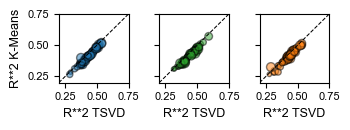

Aged Performance Correlation TSVD vs. KMeans: 
PearsonRResult(statistic=0.9741518970675128, pvalue=2.0484981821989968e-29)
n aged sessions = 45

MA Performance Correlation TSVD vs. KMeans: 
PearsonRResult(statistic=0.9840557871645721, pvalue=2.0662101292473483e-38)
n MA sessions = 51

Young Performance Correlation TSVD vs. KMeans: 
PearsonRResult(statistic=0.9831743312842725, pvalue=1.2939661396744675e-35)
n MA sessions = 48


In [21]:
'''Plot Figure S5A (Right)'''
fig, axes = plt.subplots(1, 3, figsize = (3.6,1.4), sharey=True)
#fig.suptitle('Split Maze (All K)', fontsize = 10)
rax = np.tile(ranks, (n_repeats, 1)).T.ravel()
axes[2].scatter(atsvdr2, akmeansr2, s = ak*10, label = 'Aged', c = 'C1', alpha = 0.5, edgecolor = 'k')
axes[1].scatter(matsvdr2, makmeansr2, s = mak*10, label = 'MA', c = 'C2', alpha = 0.5, edgecolor = 'k')
axes[0].scatter(ytsvdr2, ykmeansr2, s = yk*10, label = 'Young', c = 'C0', alpha = 0.5, edgecolor = 'k')

#label stuff
axes[0].set_ylabel("R**2 K-Means", fontsize = 9)
axes[0].set_xlabel("R**2 TSVD", fontsize = 9)
axes[1].set_xlabel("R**2 TSVD", fontsize = 9)
axes[2].set_xlabel("R**2 TSVD", fontsize = 9)
axes[2].set_xlim([0.2, 0.75])
axes[2].set_ylim([0.2, 0.75])
axes[1].set_xlim([0.2, 0.75])
axes[1].set_ylim([0.2, 0.75])
axes[0].set_xlim([0.2, 0.75])
axes[0].set_ylim([0.2, 0.75])
axes[0].set_yticks([0.25, 0.5, 0.75])
axes[0].set_xticks([0.25, 0.5, 0.75])
axes[1].set_xticks([0.25, 0.5, 0.75])
axes[2].set_xticks([0.25, 0.5, 0.75])
axes[0].tick_params(labelsize = 8)
axes[1].tick_params(labelsize = 8)
axes[2].tick_params(labelsize = 8)

#plot unity lines
xlims = axes[0].get_xlim()
ylims = axes[0].get_ylim()
min_plot = np.min([xlims[0], ylims[0]])
max_plot = np.max([xlims[1], ylims[1]])
axes[0].plot([min_plot, max_plot], [min_plot, max_plot], '--k', lw=0.75, zorder=4, alpha=1)
axes[1].plot([min_plot, max_plot], [min_plot, max_plot], '--k', lw=0.75, zorder=4, alpha=1)
axes[2].plot([min_plot, max_plot], [min_plot, max_plot], '--k', lw=0.75, zorder=4, alpha=1)
#axes[0].legend()
#axes[1].legend()
#axes[2].legend()
#axes[1].set_title('Dot Size ~ Optimal K (1-4)')
plt.tight_layout()

fig.savefig(save_folder + 'S5Aright.svg', dpi = 400)
fig.savefig(save_folder + 'S5Aright.png', dpi = 400)
plt.show()

print('Aged Performance Correlation TSVD vs. KMeans: ')
print(stats.pearsonr(atsvdr2,akmeansr2))
print('n aged sessions = ' + str(len(atsvdr2)))
print('\nMA Performance Correlation TSVD vs. KMeans: ')
print(stats.pearsonr(matsvdr2,makmeansr2))
print('n MA sessions = ' + str(len(matsvdr2)))
print('\nYoung Performance Correlation TSVD vs. KMeans: ')
print(stats.pearsonr(ytsvdr2,ykmeansr2))
print('n MA sessions = ' + str(len(ytsvdr2)))

# Re-label K-Means maps non-arbitrarily & examine alignment across vs. within map similarity.

In [17]:
''' Re-label spatial maps based on occupancy of Context A & B

 - If k = 2, map 0 is the map with the greatest relative number of trials in Block A (map 1 is the other)
 - If k = 3, map 0 & map 1 are the maps with greatest relative number of trials in Blocks A & B (map 2 is the other map)
 - If k = 4, map 0 & map 1 are the maps with greatest relative number of trials in Blocks A & B; between the remaining maps,
 whichever occupies more of blocks + A' is map 2. 
 
'''

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]     
        
        if len(gridcells) >= 10: 
            W = d['kmeans']['W']
            skippedrawtrialfil = d['skippedrawtrialfil'].astype(int)
            VRbackidx = d['VRbackidx'].astype(int)
            trials = skippedrawtrialfil[VRbackidx]

            #assign map 0 to be the one dominating A, map 1 is the other map
            if (d['kmeans']['SilN'] == 2) and (d['kmeans']['onemap'][0] == False):
                # get map indices
                map_idx = W[:, 0].astype(bool)
                map0_idx = np.zeros_like(trials)
                map1_idx = np.zeros_like(trials)
                for i, t in enumerate(np.unique(trials)):
                    if map_idx[i]:
                        map0_idx[trials == t] = 1
                    else:
                        map1_idx[trials == t] = 1
                map0_idx = map0_idx.astype(bool)
                map1_idx = map1_idx.astype(bool)

                # get assign map 0 to be the one with the greate number of trials in Context A
                trials_0inA = np.sum(np.unique(trials[map0_idx]) < 80)
                trials_1inA = np.sum(np.unique(trials[map1_idx]) < 80) 

                if trials_0inA < trials_1inA: # swap labels
                    d['map0_idx'] = 1
                else:
                    d['map0_idx'] = 0
            
            #ditto, assign map 1 to be the one dominating B, map 2 is the other map
            elif (d['kmeans']['SilN'] == 3) and (d['kmeans']['onemap'][0] == False):
                map0_idx = np.zeros_like(trials)
                map1_idx = np.zeros_like(trials)
                map2_idx = np.zeros_like(trials)
                for i, t in enumerate(np.unique(trials)):
                    map_idx = np.where(W[i,:] == 1)[0][0]
                    if map_idx == 0:
                        map0_idx[trials == t] = 1
                    elif map_idx == 1:
                        map1_idx[trials == t] = 1
                    else:
                        map2_idx[trials == t] = 1
                map0_idx = map0_idx.astype(bool)
                map1_idx = map1_idx.astype(bool)
                map2_idx = map2_idx.astype(bool)
                
                # get assign map 0 to be the one with the greate number of trials in Context A
                map0trials = np.unique(trials[map0_idx])
                map1trials = np.unique(trials[map1_idx])
                map2trials = np.unique(trials[map2_idx])
                                       
                trials_0inA = np.sum(map0trials < 80)
                trials_1inA = np.sum(map1trials < 80) 
                trials_2inA = np.sum(map2trials < 80) 
                
                d['map0_idx'] = np.argmax([trials_0inA, trials_1inA, trials_2inA])
                
                # get assign map 1 to be the one with the greate number of trials in Context B
                trials_0inB = len(map0trials[(map0trials >= 80) & (map0trials < 140)])
                trials_1inB = len(map1trials[(map1trials >= 80) & (map1trials < 140)])
                trials_2inB = len(map2trials[(map2trials >= 80) & (map2trials < 140)])

                d['map1_idx'] = np.argmax([trials_0inB, trials_1inB, trials_2inB])
                d['map2_idx'] = np.setdiff1d([0,1,2], [d['map0_idx'], d['map1_idx']])[0]
 
            #ditto but map 2 is the map occupying most of A' map 3 is the other map        
            elif (d['kmeans']['SilN'] == 4) and (d['kmeans']['onemap'][0] == False):
                map0_idx = np.zeros_like(trials)
                map1_idx = np.zeros_like(trials)
                map2_idx = np.zeros_like(trials)
                map3_idx = np.zeros_like(trials)
                for i, t in enumerate(np.unique(trials)):
                    map_idx = np.where(W[i,:] == 1)[0][0]
                    if map_idx == 0:
                        map0_idx[trials == t] = 1
                    elif map_idx == 1:
                        map1_idx[trials == t] = 1
                    elif map_idx == 2:
                        map2_idx[trials == t] = 1
                    else:
                        map3_idx[trials == t] = 1
                map0_idx = map0_idx.astype(bool)
                map1_idx = map1_idx.astype(bool)
                map2_idx = map2_idx.astype(bool)
                map3_idx = map3_idx.astype(bool)
                
                # get assign map 0 to be the one with the greate number of trials in Context A
                map0trials = np.unique(trials[map0_idx])
                map1trials = np.unique(trials[map1_idx])
                map2trials = np.unique(trials[map2_idx])
                map3trials = np.unique(trials[map3_idx])
                
                maptrials = [map0trials, map1trials, map2trials, map3trials]
                                       
                trials_0inA = np.sum(map0trials < 80)
                trials_1inA = np.sum(map1trials < 80) 
                trials_2inA = np.sum(map2trials < 80)
                trials_3inA = np.sum(map3trials < 80)
                
                d['map0_idx'] = np.argmax([trials_0inA, trials_1inA, trials_2inA, trials_3inA])
                
                # get assign map 1 to be the one with the greate number of trials in Context B
                trials_0inB = len(map0trials[(map0trials >= 80) & (map0trials < 140)])
                trials_1inB = len(map1trials[(map1trials >= 80) & (map1trials < 140)])
                trials_2inB = len(map2trials[(map2trials >= 80) & (map2trials < 140)])
                trials_3inB = len(map3trials[(map3trials >= 80) & (map3trials < 140)])
                   
                d['map1_idx'] = np.argmax([trials_0inB, trials_1inB, trials_2inB, trials_3inB])    
                
                #decide which map has more trials before half way point in alternation, that is map 2
                possibleidxs = np.setdiff1d([0,1,2,3], [d['map0_idx'], d['map1_idx']])
                lengths = []
                for n in possibleidxs:
                    althalf = np.max(np.unique(trials)//4) + 140
                    lengths = np.append(lengths, len(maptrials[n][maptrials[n] < althalf]))
                                        
                if lengths[0] > lengths[1]:           
                    d['map2_idx'] = possibleidxs[0]
                    d['map3_idx'] = possibleidxs[1]
                else:
                    d['map2_idx'] = possibleidxs[1]
                    d['map3_idx'] = possibleidxs[0]


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [18]:
'''Compute within vs. across map similarity for k ≥ 2 sessions '''
saged_within = []
saged_across = []
syoung_within = []
syoung_across = []
sMA_within = []
sMA_across = []

countaged = 0
countMA = 0
countyoung = 0

allacross = []
allwithin = []

for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]
        
        if len(gridcells) >= 10: 
            
            sim = d['gridsimilaritybacksorted']
            W = d['kmeans']['W']

            if (d['kmeans']['SilN'] == 2) and (d['kmeans']['onemap'][0] == False):
                
                # split by trial
                map_0 = W[:, d['map0_idx']].astype(bool)
                sim_0 = sim[map_0, :]
                sim_0 = sim_0[:, map_0]
                sim_1 = sim[~map_0, :]
                sim_1 = sim_1[:, ~map_0]
                sim_across = sim[map_0, :]
                sim_across = sim_across[:, ~map_0]

                # calculate the average similarity within vs. across maps
                within = np.append(sim_0[np.triu_indices(n=sim_0.shape[0], k=1)], 
                                   sim_1[np.triu_indices(n=sim_1.shape[0], k=1)])
                avg_within = np.mean(within)
                across = sim_across[np.triu_indices(n=sim_across.shape[0], k=1, m=sim_across.shape[1])]
                avg_across = np.mean(across)

                if m in SM_aged_mice:
                    countaged += 1
                    saged_within = np.append(saged_within, avg_within)
                    saged_across = np.append(saged_across, avg_across)
                elif m in SM_MA_mice:
                    countMA += 1
                    sMA_within = np.append(sMA_within, avg_within)
                    sMA_across = np.append(sMA_across, avg_across)
                else: 
                    countyoung += 1
                    syoung_within = np.append(syoung_within, avg_within)
                    syoung_across = np.append(syoung_across, avg_across)
                
            elif (d['kmeans']['SilN'] == 3) and (d['kmeans']['onemap'][0] == False):
                # split by trial
                map_0 = W[:, d['map0_idx']].astype(bool)
                map_1 = W[:, d['map1_idx']].astype(bool)
                map_2 = W[:, d['map2_idx']].astype(bool)
                
                sim_0 = sim[map_0, :]
                sim_0 = sim_0[:, map_0]
                sim_1 = sim[map_1, :]
                sim_1 = sim_1[:, map_1]
                sim_2 = sim[map_2, :]
                sim_2 = sim_2[:, map_2]
                
                sim_across = sim[map_0, :]
                sim_across = sim_across[:, map_1]
                sim_across1 = sim[map_0, :]
                sim_across1 = sim_across1[:, map_2]
                sim_across2 = sim[map_1, :]
                sim_across2 = sim_across2[:, map_2]

                # calculate the average similarity within vs. across maps
                within = np.concatenate((sim_0[np.triu_indices(n=sim_0.shape[0], k=1)], 
                                   sim_1[np.triu_indices(n=sim_1.shape[0], k=1)],
                                   sim_2[np.triu_indices(n=sim_2.shape[0], k=1)]))
                avg_within = np.mean(within)
                
                across = np.concatenate((sim_across[np.triu_indices(n=sim_across.shape[0], k=1, m=sim_across.shape[1])],
                                   sim_across1[np.triu_indices(n=sim_across1.shape[0], k=1, m=sim_across1.shape[1])],
                                   sim_across2[np.triu_indices(n=sim_across2.shape[0], k=1, m=sim_across2.shape[1])]))
                avg_across = np.mean(across)
                

                if m in SM_aged_mice:
                    countaged += 1
                    saged_within = np.append(saged_within, avg_within)
                    saged_across = np.append(saged_across, avg_across)
                elif m in SM_MA_mice:
                    countMA += 1
                    sMA_within = np.append(sMA_within, avg_within)
                    sMA_across = np.append(sMA_across, avg_across)
                else: 
                    countyoung += 1
                    syoung_within = np.append(syoung_within, avg_within)
                    syoung_across = np.append(syoung_across, avg_across)
            
            elif (d['kmeans']['SilN'] == 4) and (d['kmeans']['onemap'][0] == False):
                # split by trial
                map_0 = W[:, d['map0_idx']].astype(bool)
                map_1 = W[:, d['map1_idx']].astype(bool)
                map_2 = W[:, d['map2_idx']].astype(bool)
                map_3 = W[:, d['map3_idx']].astype(bool)
                
                sim_0 = sim[map_0, :]
                sim_0 = sim_0[:, map_0]
                sim_1 = sim[map_1, :]
                sim_1 = sim_1[:, map_1]
                sim_2 = sim[map_2, :]
                sim_2 = sim_2[:, map_2]
                sim_3 = sim[map_3, :]
                sim_3 = sim_3[:, map_3]
                
                sim_across = sim[map_0, :]
                sim_across = sim_across[:, map_1]
                sim_across1 = sim[map_0, :]
                sim_across1 = sim_across1[:, map_2]
                sim_across2 = sim[map_0, :]
                sim_across2 = sim_across2[:, map_3]
                sim_across3 = sim[map_1, :]
                sim_across3 = sim_across3[:, map_2]
                sim_across4 = sim[map_1, :]
                sim_across4 = sim_across4[:, map_3]
                sim_across5 = sim[map_2, :]
                sim_across5 = sim_across5[:, map_3]

                # calculate the average similarity within vs. across maps
                within = np.concatenate((sim_0[np.triu_indices(n=sim_0.shape[0], k=1)], 
                                   sim_1[np.triu_indices(n=sim_1.shape[0], k=1)],
                                   sim_2[np.triu_indices(n=sim_2.shape[0], k=1)],
                                   sim_3[np.triu_indices(n=sim_3.shape[0], k=1)]))
                avg_within = np.mean(within)
                
                across = np.concatenate((sim_across[np.triu_indices(n=sim_across.shape[0], k=1, m=sim_across.shape[1])],
                                   sim_across1[np.triu_indices(n=sim_across1.shape[0], k=1, m=sim_across1.shape[1])],
                                   sim_across2[np.triu_indices(n=sim_across2.shape[0], k=1, m=sim_across2.shape[1])],
                                   sim_across3[np.triu_indices(n=sim_across3.shape[0], k=1, m=sim_across3.shape[1])],
                                   sim_across4[np.triu_indices(n=sim_across4.shape[0], k=1, m=sim_across4.shape[1])],
                                   sim_across5[np.triu_indices(n=sim_across5.shape[0], k=1, m=sim_across5.shape[1])]))
                
                avg_across = np.mean(across)


                if m in SM_aged_mice:
                    countaged += 1
                    saged_within = np.append(saged_within, avg_within)
                    saged_across = np.append(saged_across, avg_across)
                elif m in SM_MA_mice:
                    countMA += 1
                    sMA_within = np.append(sMA_within, avg_within)
                    sMA_across = np.append(sMA_across, avg_across)
                else: 
                    countyoung += 1
                    syoung_within = np.append(syoung_within, avg_within)
                    syoung_across = np.append(syoung_across, avg_across)    
            else: #one map sessions
                pass
                
print(countyoung, countMA, countaged)

45 44 41


In [19]:
'''In all age groups, are maps more similar to themselves vs. the other map?'''
# % change in aged spatial similarity
d_sima = ((saged_across - saged_within) / saged_within) * 100
print('mean, sem within map similarity: {}, {}'.format(np.round(np.mean(saged_within), 2), np.round(stats.sem(saged_within), 2)))
print('mean, sem across map similarity: {}, {}'.format(np.round(np.nanmean(saged_across), 2), np.round(stats.sem(saged_across,  nan_policy = 'omit'), 2)))
print('pct change in spatial similarity (mean, sem) aged: {}, {}%'.format(np.round(np.nanmean(d_sima), 2), np.round(stats.sem(d_sima, nan_policy = 'omit'), 2)))

# % change in MA spatial similarity
d_simma = ((sMA_across - sMA_within) / sMA_within) * 100
print('\nmean, sem within map similarity: {}, {}'.format(np.round(np.mean(sMA_within), 2), np.round(stats.sem(sMA_within), 2)))
print('mean, sem across map similarity: {}, {}'.format(np.round(np.mean(sMA_across), 2), np.round(stats.sem(sMA_across), 2)))
print('pct change in spatial similarity (mean, sem) MA: {}, {}%'.format(np.round(np.mean(d_simma), 2), np.round(stats.sem(d_simma), 2)))

# % change in young spatial similarity
d_simy = ((syoung_across - syoung_within) / syoung_within) * 100
print('\nmean, sem within map similarity: {}, {}'.format(np.round(np.mean(syoung_within), 2), np.round(stats.sem(syoung_within), 2)))
print('mean, sem across map similarity: {}, {}'.format(np.round(np.mean(syoung_across), 2), np.round(stats.sem(syoung_across), 2)))
print('pct change in spatial similarity (mean, sem) young: {}, {}%'.format(np.round(np.mean(d_simy), 2), np.round(stats.sem(d_simy), 2)))

sameVSdiff_stat, sameVSdiff_p = stats.wilcoxon(saged_within[~np.isnan(saged_across)], saged_across[~np.isnan(saged_across)])
print('\nwithin map vs across map similarity: aged_p = ' + str(sameVSdiff_p))
print('n = ' + str(saged_within.shape[0]) + ' model pairs')

sameVSdiff_stat, sameVSdiff_p = stats.wilcoxon(sMA_within, sMA_across)
print('\nwithin map vs across map similarity: MA_p = ' + str(sameVSdiff_p))
print('n = ' + str(sMA_within.shape[0]) + ' model pairs')

sameVSdiff_stat, sameVSdiff_p = stats.wilcoxon(syoung_within, syoung_across)
print('\nwithin map vs across map similarity: young_p = ' + str(sameVSdiff_p))
print('n = ' + str(syoung_within.shape[0]) + ' model pairs')

mean, sem within map similarity: 0.44, 0.02
mean, sem across map similarity: 0.22, 0.01
pct change in spatial similarity (mean, sem) aged: -50.74, 1.87%

mean, sem within map similarity: 0.46, 0.01
mean, sem across map similarity: 0.24, 0.02
pct change in spatial similarity (mean, sem) MA: -48.07, 2.61%

mean, sem within map similarity: 0.43, 0.02
mean, sem across map similarity: 0.19, 0.01
pct change in spatial similarity (mean, sem) young: -54.91, 2.36%

within map vs across map similarity: aged_p = 9.094947017729282e-13
n = 41 model pairs

within map vs across map similarity: MA_p = 1.1368683772161603e-13
n = 44 model pairs

within map vs across map similarity: young_p = 5.684341886080802e-14
n = 45 model pairs


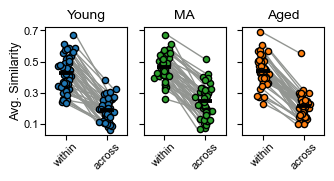

In [20]:
'''Plot Figure S5B (right)'''
f, ax = plt.subplots(1, 3, figsize=(3.6, 1.4), sharey = True)
#f.suptitle('Split Maze (k ≥ 2)', fontsize = 10)
DOT_SIZE = 20
DOT_LW = 1
BAR_SIZE = 10
BAR_WIDTH = 2.8
labels = ['within', 'across']

## PLOT AGED DATA 
j = np.random.randn(saged_within.shape[0]) * .08

# plot connector lines
for k, w in enumerate(saged_within): # plot connector lines
    a = saged_across[k]
    x_vals = [1.08+j[k], 1.92+j[k]]
    y_vals = [w-0.005, a+0.005]
    ax[2].plot(x_vals, y_vals, '-', color='xkcd:gray', lw=DOT_LW, zorder=1,  alpha=1)

# within map similarity
ax[2].scatter(np.full(len(saged_within), 1)+j, saged_within,
           facecolors='C1', edgecolors='k', alpha=1,
           s=DOT_SIZE, lw=DOT_LW, zorder=2, label='Aged') 

# across map similarity
ax[2].scatter(np.full(len(saged_within), 2)+j, saged_across,
           facecolors='C1', edgecolors='k', alpha=1,
           s=DOT_SIZE, lw=DOT_LW, zorder=2, label = 'Aged') 

# plot means
ax[2].plot(1, np.mean(saged_within), '_', c='k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=3)
ax[2].plot(2, np.mean(saged_across), '_', c='k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=3)

## PLOT MA DATA 
j = np.random.randn(sMA_within.shape[0]) * .08

# plot connector lines
for k, w in enumerate(sMA_within): # plot connector lines
    a = sMA_across[k]
    x_vals = [1.08+j[k], 1.92+j[k]]
    y_vals = [w-0.005, a+0.005]
    ax[1].plot(x_vals, y_vals, '-', color='xkcd:gray', lw=DOT_LW, zorder=1,  alpha=1)

# within map similarity
ax[1].scatter(np.full(len(sMA_within), 1)+j, sMA_within,
           facecolors='C2', edgecolors='k', alpha=1,
           s=DOT_SIZE, lw=DOT_LW, zorder=2, label='MA') 

# across map similarity
ax[1].scatter(np.full(len(sMA_within), 2)+j, sMA_across,
           facecolors='C2', edgecolors='k', alpha=1,
           s=DOT_SIZE, lw=DOT_LW, zorder=2) 

# plot means
ax[1].plot(1, np.mean(sMA_within), '_', c='k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=3)
ax[1].plot(2, np.mean(sMA_across), '_', c='k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=3)

## PLOT Young DATA 
j = np.random.randn(syoung_within.shape[0]) * .08

# plot connector lines
for k, w in enumerate(syoung_within): # plot connector lines
    a = syoung_across[k]
    x_vals = [1.08+j[k], 1.92+j[k]]
    y_vals = [w-0.005, a+0.005]
    ax[0].plot(x_vals, y_vals, '-', color='xkcd:gray', lw=DOT_LW, zorder=1,  alpha=1)

# within map similarity
ax[0].scatter(np.full(len(syoung_within), 1)+j, syoung_within,
           facecolors='C0', edgecolors='k', alpha=1,
           s=DOT_SIZE, lw=DOT_LW, zorder=2, label='Young') 

# across map similarity
ax[0].scatter(np.full(len(syoung_within), 2)+j, syoung_across,
           facecolors='C0', edgecolors='k', alpha=1,
           s=DOT_SIZE, lw=DOT_LW, zorder=2) 

# plot means
ax[0].plot(1, np.mean(syoung_within), '_', c='k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=3)
ax[0].plot(2, np.mean(syoung_across), '_', c='k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=3)

ax[2].set_xlim([0.5, 2.5])
ax[2].set_xticks([1, 2])
ax[2].set_yticks([0.1, 0.3, 0.5, 0.7])
ax[2].set_xticklabels(labels, rotation=45)
ax[2].tick_params(which='major', labelsize=8, pad=0.8)
ax[2].set_title('Aged', fontsize = 10)

ax[1].set_xlim([0.5, 2.5])
ax[1].set_xticks([1, 2])
ax[1].set_yticks([0.1, 0.3, 0.5, 0.7])
ax[1].set_xticklabels(labels, rotation=45)
ax[1].tick_params(which='major', labelsize=8, pad=0.8)
#ax[1].set_ylabel('Avg. Correlation', fontsize=10, labelpad=1)
ax[1].set_title('MA', fontsize = 10)

ax[0].set_xlim([0.5, 2.5])
ax[0].set_xticks([1, 2])
ax[0].set_xticklabels(labels, rotation=45)
ax[0].tick_params(which='major', labelsize=8, pad=0.8)
ax[0].set_title('Young', fontsize = 10)
ax[0].set_ylabel('Avg. Similarity', fontsize=9, labelpad=1)
f.savefig(save_folder + 'S5Bright.png', dpi=400, bbox_inches='tight')
f.savefig(save_folder + 'S5Bright.svg', dpi=400, bbox_inches='tight')
plt.show()

In [21]:
''' Statistics to Compare Age Groups Within, Across, Diff (Within - Across) Similarity'''

print('WITHIN RESULTS')
print('withinyoung ± SEM; withinMA ± SEM; withinstab_old ± SEM')
print(str(np.round(np.nanmean(syoung_within), 4)) + ' ± ' + str(np.round(stats.sem(syoung_within), 4)) + ' ; ' 
      + str(np.round(np.nanmean(sMA_within), 4)) + ' ± ' + str(np.round(stats.sem(sMA_within), 4)) + ' ; ' 
      + str(np.round(np.nanmean(saged_within), 4)) + ' ± ' + str(np.round(stats.sem(saged_within), 4)))

stat, p_diff = stats.kruskal(syoung_within, sMA_within, saged_within)
print('stat = ' + str(stat))
print('p_grid_session = ' + str(p_diff))
stat, p_diff = stats.ranksums(syoung_within, saged_within)
print('stat = ' + str(stat))
print('p_grid_sessionyva = ' + str(p_diff))

print('\nACROSS RESULTS:')
print('acrossyoung ± SEM; acrossMA ± SEM; acrossstab_old ± SEM')
print(str(np.round(np.nanmean(syoung_across), 4)) + ' ± ' + str(np.round(stats.sem(syoung_across), 4)) + ' ; ' 
      + str(np.round(np.nanmean(sMA_across), 4)) + ' ± ' + str(np.round(stats.sem(sMA_across), 4)) + ' ; ' 
      + str(np.round(np.nanmean(saged_across), 4)) + ' ± ' + str(np.round(stats.sem(saged_across, nan_policy = 'omit'), 4)))

stat, p_diff = stats.kruskal(syoung_across, sMA_across, saged_across)
print('stat = ' + str(stat))
print('p_grid_session = ' + str(p_diff))
stat, p_diff = stats.ranksums(syoung_across, saged_across)
print('stat = ' + str(stat))
print('p_grid_sessionyva = ' + str(p_diff))

sd_sima = ((saged_across - saged_within) / saged_within) * 100
sd_simma = ((sMA_across - sMA_within) / sMA_within) * 100
sd_simy = ((syoung_across - syoung_within) / syoung_within) * 100

print('\nWithin - Across % Change RESULTS:')
print('changeyoung ± SEM; changeMA ± SEM; changestab_old ± SEM')
print(str(np.round(np.nanmean(sd_simy), 4)) + ' ± ' + str(np.round(stats.sem(sd_simy), 4)) + ' ; ' 
      + str(np.round(np.nanmean(sd_simma), 4)) + ' ± ' + str(np.round(stats.sem(sd_simma), 4)) + ' ; ' 
      + str(np.round(np.nanmean(sd_sima), 4)) + ' ± ' + str(np.round(stats.sem(sd_sima, nan_policy = 'omit'), 4)))

stat, p_diff = stats.kruskal(sd_simy, sd_simma, sd_sima)
print('stat = ' + str(stat))
print('p_grid_session = ' + str(p_diff))

stat, p_diff = stats.ranksums(sd_simy, sd_sima)
print('stat = ' + str(stat))
print('p_grid_sessionyva = ' + str(p_diff))


WITHIN RESULTS
withinyoung ± SEM; withinMA ± SEM; withinstab_old ± SEM
0.4261 ± 0.0171 ; 0.4643 ± 0.0131 ; 0.4409 ± 0.0152
stat = 2.913197275014454
p_grid_session = 0.23302753941022641
stat = -0.5922749748448712
p_grid_sessionyva = 0.5536664707610806

ACROSS RESULTS:
acrossyoung ± SEM; acrossMA ± SEM; acrossstab_old ± SEM
0.1885 ± 0.0114 ; 0.2449 ± 0.0158 ; 0.2181 ± 0.0126
stat = 7.823679928338265
p_grid_session = 0.020003661160241736
stat = -1.69036142455726
p_grid_sessionyva = 0.09095883032717457

Within - Across % Change RESULTS:
changeyoung ± SEM; changeMA ± SEM; changestab_old ± SEM
-54.9148 ± 2.3572 ; -48.0722 ± 2.608 ; -50.7417 ± 1.8715
stat = 4.851677978820078
p_grid_session = 0.08840391796850083
stat = -1.240751224675022
p_grid_sessionyva = 0.21469766465289797


This suggests that maps contain similarly heterogenous spatial information across age groups. 

In [27]:
''' Measure remapping coordination in each age group ''' 
smeancorr = []
bins = np.arange(0, 0.8, 0.05)

for m, session in zip(mice, sessions):
    
    m_correlation = []
    
    for s in tdqm(session):
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]   
        
        if m in SM_aged_mice:
            col = 'C1'
        elif m in SM_MA_mice:
            col = 'C2'
        else:
            col = 'C0'
        
        if len(gridcells) > 2:
            
            allgridsim_file = 'allsim_' + m + '_' + s + '_'+ '.npy'
            allsim = np.load(fig2s3_folder + allgridsim_file)
            
            correlation = []
            for i, c in enumerate(gridcells):
                littlesim = allsim[:,:,i]
                allothersim = np.delete(allsim, i, axis = 2)
                sim = np.mean(allothersim, axis = 2)
                mask = np.triu_indices(sim.shape[0])
            
                #linearize upper triangles of each sim matrix
                uppersim = sim[mask]
                upperlittlesim = littlesim[mask]

                #compute correlation of front & back matrices with each other
                corr, _ = stats.pearsonr(uppersim[~np.isnan(uppersim)], upperlittlesim[~np.isnan(uppersim)])
                correlation = np.append(correlation, corr)
            
            #compute the mean for each session
            smeancorr = np.append(smeancorr, np.mean(correlation))

        else:
            print('less than three grid cells, cannot compute mean corr for this session')
            smeancorr = np.append(smeancorr, np.nan)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

less than three grid cells, cannot compute mean corr for this session


  0%|          | 0/6 [00:00<?, ?it/s]

less than three grid cells, cannot compute mean corr for this session
less than three grid cells, cannot compute mean corr for this session


  0%|          | 0/6 [00:00<?, ?it/s]

less than three grid cells, cannot compute mean corr for this session


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

less than three grid cells, cannot compute mean corr for this session


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

less than three grid cells, cannot compute mean corr for this session


  0%|          | 0/6 [00:00<?, ?it/s]

less than three grid cells, cannot compute mean corr for this session


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

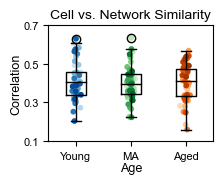

In [28]:
''' Plot Figure S5D '''

#correct plotting indices
nan_idxgrid = np.where((spergrid == 0))[0]
y_sindgrid = np.setdiff1d(y_sind, nan_idxgrid)
ma_sindgrid = np.setdiff1d(ma_sind, nan_idxgrid)
age_sindgrid = np.setdiff1d(age_sind, nan_idxgrid)

# Adjust colormaps for grid plots
yidx = []
maidx = []
aidx = []
for i in nan_idxgrid:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    maidx = np.append(maidx, np.where(ma_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int)) 

col_session_younggrid = np.delete(col_session_young, list(yidx.astype(int)), axis = 0)
col_session_magrid = np.delete(col_session_MA, list(maidx.astype(int)), axis = 0)
col_session_oldgrid = np.delete(col_session_old, list(aidx.astype(int)), axis = 0)
col_sessiongrid = [col_session_younggrid, col_session_magrid, col_session_oldgrid] 

# This will fix session stats & box plots are plotted.

labels = ['Young','MA','Aged']
fig, ax = plt.subplots(1, 1, figsize=(2.125, 1.5))
#f.suptitle('Grid Cell Animal Network Similarity Matrix Correlation, Pooled by Age Group', fontsize=12)

scorr_tog = [smeancorr[y_sindgrid][~np.isnan(smeancorr[y_sindgrid])],smeancorr[ma_sindgrid],smeancorr[age_sindgrid][~np.isnan(smeancorr[age_sindgrid])]]
ax.boxplot(scorr_tog, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax.set_title('Cell vs. Network Similarity', fontsize=10, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('Correlation', fontsize=9, labelpad=1)
ax.set_ylim([0.1,0.70])
ax.set_yticks([0.1,0.3,0.5,0.7])

for i in range(len(scorr_tog)):
    y = scorr_tog[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    ax.scatter(x, y, color = col_sessiongrid[i][:len(y)], edgecolors = col_sessiongrid[i][:len(y)], alpha = 1, s = 10)

ax.tick_params(labelsize = 8)
plt.savefig(save_folder + 'S5D.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S5D.svg', dpi=400, bbox_inches='tight')
plt.show()

In [29]:
''' Perform Statistics Comparing Cell vs. Network Similarity across Age Groups'''

print('\nSESSION:')
print('corryoung ± SEM; corr_MA ± SEM; corr_old ± SEM')
print(str(np.round(np.nanmean(smeancorr[y_sindgrid]), 3)) + ' ± ' + str(np.round(stats.sem(smeancorr[y_sindgrid], nan_policy = 'omit'), 3)) + ' ; ' 
      + str(np.round(np.nanmean(smeancorr[ma_sindgrid]), 3)) + ' ± ' + str(np.round(stats.sem(smeancorr[ma_sindgrid], nan_policy = 'omit'), 3)) + ' ; ' 
      + str(np.round(np.nanmean(smeancorr[age_sindgrid]), 3)) + ' ± ' + str(np.round(stats.sem(smeancorr[age_sindgrid], nan_policy = 'omit'), 3)))

#Non-Parametric version
print('\nn young, MA, aged sessions with ≥3 grid cells')
print(len(smeancorr[y_sindgrid][~np.isnan(smeancorr[y_sindgrid])]), len(smeancorr[ma_sindgrid][~np.isnan(smeancorr[ma_sindgrid])]),len(smeancorr[age_sindgrid][~np.isnan(smeancorr[age_sindgrid])]))

H, p = stats.kruskal(smeancorr[y_sindgrid][~np.isnan(smeancorr[y_sindgrid])],smeancorr[ma_sindgrid][~np.isnan(smeancorr[ma_sindgrid])],smeancorr[age_sindgrid][~np.isnan(smeancorr[age_sindgrid])])
print('\nKW H stat, p-value:')
print(H, p)


SESSION:
corryoung ± SEM; corr_MA ± SEM; corr_old ± SEM
0.415 ± 0.014 ; 0.4 ± 0.011 ; 0.403 ± 0.013

n young, MA, aged sessions with ≥3 grid cells
52 57 51

KW H stat, p-value:
0.5441209475340543 0.7618081902857953


This suggest that remapping is similarly coordinated among co-recorded cells in sessions across age groups. 

However, do mice across age groups attend to the moving tower cue in the front 200 cm of the Split Maze to differentiate Context A and B to the same extent? In other words, does the grid network remap happen at the same place along the track or not across age groups? When we compare grid network remapping and map-context alignment across age groups, this will dictate whether we should use the activity along the entire track or just the back 200 cm where most of the context visual cues are.

# Compare similarity of front vs. back track grid network similarity matrices across age groups (Figure S5I-J).

Highly correlated front vs. back track similarity matrices would suggest remapping occurs in the front 200cm of the track. The less correlated these two matrices are, the more likely it is that grid remapping occurs after seeing the back 200cm of the track. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

A22 012923_record2


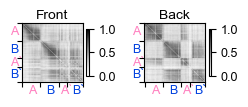

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\Desktop\GitHub\Herber2024\pipeline\process_spikes.py:137: RuntimeWarning: invalid value encountered in divide
  firing_rate[:, :, c] = (firing_rate[:, :, c] - np.min(firing_rate[:, :, c]))/np.max(firing_rate[:, :, c] - np.min(firing_rate[:, :, c]))


  0%|          | 0/6 [00:00<?, ?it/s]

MA6M 110422_record6


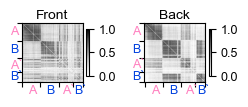

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Y22 093022_record6


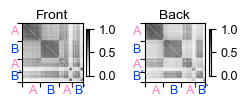

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [30]:
''' Compute Front vs. Back Track Grid Network Similarity Matrices for all Sessions, plotting Figure S5I examples along the way

Run time: ~15-30 seconds / session for 134 sessions w/ ≥ 10 grid cells

''' 

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

dt = 0.02
grid_min = 10 
colors = ['xkcd:pink','xkcd:blue','xkcd:pink', 'xkcd:blue']
labels = ['A', 'B','A`','B`']

# if you want to plot all sessions:
#example_mice = mice
#example_sessions = sessions

# if you want to plot only example sessions from Figure S5I:
example_mice = ['Y22','MA6M','A22']
example_sessions = ['093022_record6','110422_record6','012923_record2']

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        frontonlytrials = []
        backonlytrials = []
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]   
        
        if len(gridcells) >= grid_min:
        
            posx = behaviorfil[:,0]
            trial = behaviorfil[:,2]
            rawtrialfil = raw.item().get('trialfil')

            #Find any skipped trials
            try:
                _ = raw.item().get('correctedtrial').shape
                skippedtrials = get.find_skipped(trial, max_trial_num = 220)
            except:
                skippedtrials = []

            if np.max(np.unique(trial)) < 160: #handles truncated, shorter sessions 
                alltrial = np.arange(0, np.max(np.unique(trial)) + 2, 1)
                #print(m, s)
            else:
                alltrial = np.arange(0,220,1)

            # Load in left vs. right info
            trials = np.unique(trial)
            trialinfo = raw.item().get('trialinfo')
            left = trialinfo['left']

            # Sort trials by context, find sorted skipped trials, num dark skipped trials
            leftsort, allcopy = get.contextsortedtrials(alltrial, left, alt_idx = 140)

            newskippedtrials = []
            for z in skippedtrials:
                newskippedtrials = np.append(newskippedtrials, np.where(allcopy == z)[0][0])

            ndarkskipped = 0
            for z in newskippedtrials:
                if z < 20: 
                    ndarkskipped += 1

            #adjust trialfil so that sorted trials are skipped instead
            skippedrawtrialfil = get.sortedtrialbyframe(rawtrialfil, trial, newskippedtrials)
            numtrial = np.unique(skippedrawtrialfil)

            #sort spike train & position on VR frames by context during alternation
            posxcopy = []
            allcopy= np.append(allcopy, 220)
            for t in allcopy:
                obs_idx = np.where(trial == t)[0]
                posxcopy = np.append(posxcopy, posx[obs_idx])
                if t == 0:
                    Z = Y[obs_idx,:]
                else: 
                    Z = np.append(Z, Y[obs_idx,:], axis = 0)
                
            #remove dark & trial 220 dataframes     
            start_idx = (np.where(skippedrawtrialfil >= 20)[0][0]).astype(int)
            if np.max(skippedrawtrialfil) == 220:
                end_idx = (np.where(skippedrawtrialfil == 220)[0][0])
            else:
                end_idx = len(skippedrawtrialfil) + 1

            #divide observations into front and back halves
            frontidx = np.where(posxcopy < 200)[0].astype(int)
            backidx = np.where(posxcopy >= 200)[0].astype(int)
            VRidx = np.arange(start_idx, end_idx, 1)
            VRfrontidx = np.intersect1d(VRidx, frontidx)
            VRbackidx = np.intersect1d(VRidx, backidx)

            frontonlytrials = np.append(frontonlytrials, np.setdiff1d(np.unique(skippedrawtrialfil[VRfrontidx]), np.unique(skippedrawtrialfil[VRbackidx])))
            frontonlyidx = []
            for t in frontonlytrials:
                frontonlyidx = np.append(frontonlyidx, np.where(np.unique(skippedrawtrialfil[VRfrontidx]) == t)[0])
            d['frontonlytrials'] = frontonlyidx

            backonlytrials = np.append(backonlytrials, np.setdiff1d(np.unique(skippedrawtrialfil[VRbackidx]), np.unique(skippedrawtrialfil[VRfrontidx])))
            backonlyidx = []
            for t in backonlytrials:
                 backonlyidx = np.append(backonlyidx, np.where(np.unique(skippedrawtrialfil[VRbackidx]) == t)[0])
            d['backonlytrials'] = backonlyidx

            #get smoothed by trial FR matrix excluding dark period sorted by context using front half of track
            normFR, _, _ = ps.tuning_curve_bytrial(posxcopy[VRfrontidx], skippedrawtrialfil[VRfrontidx], Z[VRfrontidx,:], dt, sigma = 5, b=2, smooth=True, normalize=True, occupancy=True)

            #get & plot similarity matrix for all grid spatial cells
            gridcell = d['gridcell'].astype(bool)
            gridcells = cell_IDs[gridcell]

            sdx = []
            for i, c in enumerate(gridcells):
                sd = (np.where(cell_IDs == c)[0][0]).astype(int)
                sdx.append(sd)

            normspatialgridFR = normFR[:,:,sdx] 
            normspatialgridFR_unwrapped = np.reshape(normspatialgridFR, (normspatialgridFR.shape[0], -1))
            sim_vec = np.abs(pdist(normspatialgridFR_unwrapped, 'correlation')-1)
            sim1 = squareform(sim_vec)
            d['gridsimilarityfront'] = sim1

            #get smoothed by trial FR matrix excluding dark period sorted by context using front half of track
            normFR, _, _ = ps.tuning_curve_bytrial(posxcopy[VRbackidx], skippedrawtrialfil[VRbackidx], Z[VRbackidx,:], dt, sigma = 5, b=2, smooth=True, normalize=True, occupancy=True)

            #get & plot similarity matrix for all grid cells  
            normspatialgridFR = normFR[:,:,sdx] 
            normspatialgridFR_unwrapped = np.reshape(normspatialgridFR, (normspatialgridFR.shape[0], -1))
            sim_vec = np.abs(pdist(normspatialgridFR_unwrapped, 'correlation')-1)
            sim2 = squareform(sim_vec)        
            d['gridsimilarityback'] = sim2

            #Plot front vs. back sim matrices side by side if an example session/mouse (Figure S5I)
            if (m in example_mice) and (s in example_sessions):
                print(m, s)

                # add ticks to label contexts dynamically
                lengthdark = (20 - ndarkskipped)
                lengthA = len(np.unique(skippedrawtrialfil)[np.unique(skippedrawtrialfil) < (80 - lengthdark)])
                nA_ = np.sum(1 - leftsort[alltrial >= 140])
                lengthB = len(np.unique(skippedrawtrialfil)[(np.unique(skippedrawtrialfil) >= (80 - lengthdark)) & (np.unique(skippedrawtrialfil) < (140 - lengthdark))])
                lengthA_ = len(np.unique(skippedrawtrialfil)[(np.unique(skippedrawtrialfil) >= (140 - lengthdark)) & (np.unique(skippedrawtrialfil) < (140 + nA_ - lengthdark))])
                end =  sim1.shape[0]
                nB_ = end - (lengthA + lengthB + lengthA_) 
                
                ticks = np.array([0, lengthA, (lengthA + lengthB), (lengthA + lengthB + lengthA_), end])
                textloc = np.array([lengthA // 2, (lengthA + lengthB // 2), (lengthA + lengthB + lengthA_//2), (lengthA + lengthB + lengthA_ + nB_//2)])

                if m in SM_aged_mice:
                    col = 'C1'
                elif m in SM_MA_mice:
                    col = 'C2'
                else:
                    col = 'C0'
                
                f, axs = plt.subplots(1,2, figsize=(2.6, 1.25))
                #f.suptitle(str(m) + '_' + str(s[-1]), fontsize = 10, color = col)
                im = axs[0].imshow(sim1, clim=[0, 1.0], aspect='auto', cmap='Greys')
                axs[0].set_title('Front'.format(m, s[-1]), fontsize=10, pad=3)
                axs[0].set_yticks(ticks, labels = [])
                axs[0].set_xticks(ticks, labels = [])
                for n, j in enumerate(labels):
                    axs[0].text(textloc[n] - 10, 240, j, color = colors[n], fontsize = 9)
                    axs[0].text(-40, textloc[n] + 10, j, color = colors[n], fontsize = 9)
                cbar = plt.colorbar(im, shrink = 0.8, ax = axs[0],ticks=np.arange(0,1.1,0.5))
                cbar.ax.tick_params(labelsize = 9)

                im = axs[1].imshow(sim2, clim=[0, 1.0], aspect='auto', cmap='Greys')
                axs[1].set_title('Back'.format(m, s[-1]), fontsize=10, pad=3)
                axs[1].set_yticks(ticks, labels = [])
                axs[1].set_xticks(ticks, labels = [])
                for n, j in enumerate(labels):
                    axs[1].text(textloc[n] - 10, 240, j, color = colors[n], fontsize = 9)
                    axs[1].text(-40, textloc[n] + 10, j, color = colors[n], fontsize = 9)
                cbar = plt.colorbar(im, shrink = 0.8, ax = axs[1],ticks=np.arange(0,1.1,0.5))
                cbar.ax.tick_params(labelsize = 9)

                plt.tight_layout()
                f.savefig(save_folder + str(m) + '_' + str(s) + '_S5I.png', dpi = 400)
                f.savefig(save_folder + str(m) + '_' + str(s) + '_S5I.svg', dpi = 400)
                plt.show()
                plt.close(f)  

In [31]:
''' Compute Magnitude of Correlation btwn Similarity Matrices '''

scorrfb = []
mcorrfb = []
gridmultimapsesh = []

for m, session in zip(mice, sessions):
    
    m_corr = []
    
    for s in tdqm(session):
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]    
        
        if len(gridcells) >= grid_min:
            
            gridmultimapsesh = np.append(gridmultimapsesh, True)
            sim1 = d['gridsimilarityfront'] 
            sim2 = d['gridsimilarityback']
            backonlytrials = np.array(d['backonlytrials']).astype(int)
            frontonlytrials = np.array(d['frontonlytrials']).astype(int)
            
            #ensure that matrices are the same size
            if len(backonlytrials) > 0: #remove trials from sim2 that are only in sim2
                sim2 = np.delete(np.delete(sim2, backonlytrials, 0), backonlytrials,1)
            if len(frontonlytrials) > 0: #remove trials from sim1 that are only in sim1
                sim1 = np.delete(np.delete(sim1, frontonlytrials, 0), frontonlytrials,1)
            
            #linearize upper triangles of each sim matrix
            mask = np.triu_indices(sim1.shape[0])
            uppersim1 = sim1[mask]
            uppersim2 = sim2[mask]
            uppersim = sim[mask]

            #compute correlation of front & back matrices with each other
            corr, _ = stats.pearsonr(uppersim1, uppersim2)
            scorrfb = np.append(scorrfb, corr)
            m_corr = np.append(m_corr,corr)
        
        else:
            gridmultimapsesh = np.append(gridmultimapsesh, False)
            m_corr = np.append(m_corr, np.nan)
            scorrfb = np.append(scorrfb, np.nan)
                
    mcorrfb = np.append(mcorrfb, np.nanmean(m_corr))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

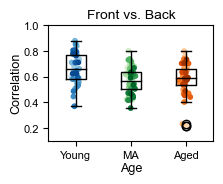

In [32]:
''' Plot Figure S5J'''

nan_idx10grid = np.where((gridmultimapsesh.astype(bool) == 0))[0]

# Adjust y_sind, ma_sind, age_sind for subsequent plots
y_sind10grid = np.setdiff1d(y_sind, nan_idx10grid)
ma_sind10grid = np.setdiff1d(ma_sind, nan_idx10grid)
age_sind10grid = np.setdiff1d(age_sind, nan_idx10grid)

# Adjust colormaps for grid plots
yidx = []
maidx = []
aidx = []
for i in nan_idx10grid:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    maidx = np.append(maidx, np.where(ma_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int)) 

col_session_young10grid = np.delete(col_session_young, list(yidx.astype(int)), axis = 0)
col_session_ma10grid = np.delete(col_session_MA, list(maidx.astype(int)), axis = 0)
col_session_old10grid = np.delete(col_session_old, list(aidx.astype(int)), axis = 0)
col_session10grid = [col_session_young10grid, col_session_ma10grid, col_session_old10grid] 

labels = ['Young','MA','Aged']
fig, ax = plt.subplots(1, 1, figsize=(2.125, 1.5), sharey = False)
#f.suptitle('Grid Cell Session Network Similarity Matrix Correlation, Pooled by Age Group', fontsize=12)

scorr_tog = [scorrfb[y_sind10grid],scorrfb[ma_sind10grid],scorrfb[age_sind10grid]]
ax.boxplot(scorr_tog, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax.set_title('Front vs. Back', fontsize=10, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.tick_params(labelsize=8)
ax.set_ylabel('Correlation', fontsize=9, labelpad=1)
ax.set_ylim([0.1,1.0])

for i in range(len(scorr_tog)):
    y = scorr_tog[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    ax.scatter(x, y, color = col_session10grid[i], edgecolors = col_session10grid[i], alpha = 1, s = 10)
    
plt.savefig(save_folder + 'S5J.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S5J.svg', dpi=400, bbox_inches='tight')
plt.show()

In [33]:
''' Statistically compare correlation of front vs. back grid network similarity matrices '''

import statsmodels.api as sm
import scikit_posthocs as ph

print('Young Front vs. Back Correlation, Mean ± SEM: ')
print(str(np.mean(scorrfb[y_sind10grid])) + ' ± ' + str(stats.sem(scorrfb[y_sind10grid])))

print('MA Front vs. Back Correlation, Mean ± SEM: ')
print(str(np.mean(scorrfb[ma_sind10grid])) + ' ± ' + str(stats.sem(scorrfb[ma_sind10grid])))

print('Aged Front vs. Back Correlation, Mean ± SEM: ')
print(str(np.mean(scorrfb[age_sind10grid])) + ' ± ' + str(stats.sem(scorrfb[age_sind10grid])))

H, p = stats.kruskal(scorrfb[y_sind10grid],scorrfb[ma_sind10grid],scorrfb[age_sind10grid])
print('\nKW H, p-value: ')
print(H, p)

#make into dataframe
sex = list(animalmeta.Sex[mice_ind])
sexes = []
seshmice = []
seshcount = []
seshage = []
for m, session in zip(mice, sessions):
    center = rewarda_centers[np.where(mice == m)[0][0]]
    msex = np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Sex'])
    age =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Age_Group'])
    totalsesh = len(session)
    
    for i, s in enumerate(session):
        sexes = np.append(sexes, msex)
        seshmice = np.append(seshmice, m)
        seshcount = np.append(seshcount, (i + 1))
        seshage = np.append(seshage, age)

# Collect all relevant data into pandas dataframe
allidx = np.concatenate((y_sind10grid,ma_sind10grid,age_sind10grid))
Animal_ID = list(seshmice[allidx])
Session = list(seshcount[allidx])
Sex = list(sexes[allidx])
Age_Group = list(seshage[allidx])
CorrFB = list(scorrfb[allidx])

tuples = list(zip(Animal_ID, Session, Sex, Age_Group, CorrFB))
tuples

df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session', 'Sex', 'AgeGroup','CorrFB'])
df = df.dropna(axis = 0)

#run post hoc tests
ph.posthoc_conover(df, val_col = 'CorrFB', group_col = 'AgeGroup', p_adjust = 'holm')

Young Front vs. Back Correlation, Mean ± SEM: 
0.6633213361328258 ± 0.016618437610048997
MA Front vs. Back Correlation, Mean ± SEM: 
0.5677853254661024 ± 0.013961489381720696
Aged Front vs. Back Correlation, Mean ± SEM: 
0.5766179330186065 ± 0.019691209759825832

KW H, p-value: 
16.95983880812861 0.00020759543339169664


,1.0,2.0,3.0
1.0,1.000000,0.000143,0.004605
2.0,0.000143,1.000000,0.330214
3.0,0.004605,0.330214,1.000000


Given the observed differences in front and back track activity, reviewers asked to investigate front track spatial map content a measure of the influence of the front track cue tower on remapping frequency and alignment to context. Reviewer Figure 2 includes the analyses below in full. Reviewer Figure 2D was included in the manuscript Figure S5K. 

In [17]:
''' Compute & Save Sorted Normalized FR Tensor for Grid Network in Front of Track, excluding Dark & Gain Change Periods '''

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

dt = 0.02

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        spatialcell99 = d['spatialcell99']
        spatialcells = cell_IDs[spatialcell99]
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]     
        
        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        rawtrialfil = raw.item().get('trialfil')
        
        #Find any skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            skippedtrials = get.find_skipped(trial, max_trial_num = 220)
            
        except:
            skippedtrials = []
        
        if np.max(np.unique(trial)) < 160: #handles truncated, shorter sessions 
            alltrial = np.arange(0, np.max(np.unique(trial)) + 2, 1)
        else:
            alltrial = np.arange(0,220,1)

        # Load in left vs. right info
        trials = np.unique(trial)
        trialinfo = raw.item().get('trialinfo')
        left = trialinfo['left']
        
        # Sort trials by context, find sorted skipped trials, num dark skipped trials
        leftsort, allcopy = get.contextsortedtrials(alltrial, left, alt_idx = 140)
        
        newskippedtrials = []
        for z in skippedtrials:
            newskippedtrials = np.append(newskippedtrials, np.where(allcopy == z)[0][0])

        ndarkskipped = 0
        for z in newskippedtrials:
            if z < 20: 
                ndarkskipped += 1
                
        #adjust trialfil so that sorted trials are skipped instead
        skippedrawtrialfil = get.sortedtrialbyframe(rawtrialfil, trial, newskippedtrials)
        numtrial = np.unique(skippedrawtrialfil)

        #sort spike train & position on VR frames by context during alternation
        posxcopy = []
        allcopy= np.append(allcopy, 220)
        for t in allcopy:
            obs_idx = np.where(trial == t)[0]
            posxcopy = np.append(posxcopy, posx[obs_idx])
            if t == 0:
                Z = Y[obs_idx,:]
            else: 
                Z = np.append(Z, Y[obs_idx,:], axis = 0)

        #binary context vector, excluding skipped trials, dark, & gain periods, 1 = Map A
        context = []
        for i, t in enumerate(np.unique(skippedrawtrialfil)):
            if t < 220:
                context = np.append(context, leftsort[t.astype(int)])
            
        #remove dark & trial 220 dataframes     
        start_idx = (np.where(skippedrawtrialfil >= 20)[0][0]).astype(int)
        if np.max(skippedrawtrialfil) > 200:
            end_idx = (np.where(skippedrawtrialfil >= 200)[0][0])
        else:
            end_idx = len(skippedrawtrialfil) + 1

        #divide observations into front and back halves
        frontidx = np.where(posxcopy < 200)[0].astype(int)
        backidx = np.where(posxcopy >= 200)[0].astype(int)
        VRidx = np.arange(start_idx, end_idx, 1)
        VRfrontidx = np.intersect1d(VRidx, frontidx)
        VRbackidx = np.intersect1d(VRidx, backidx)
        
        d['VRfrontidx'] = VRfrontidx
        VRfrontidx_file = 'VRfrontidx_' + m + '_' + s + '.npy'
        np.save(save_folder + VRfrontidx_file, VRfrontidx)
        
        d['skippedrawtrialfil'] = skippedrawtrialfil
        #skippedrawtrialfil_file = 'skippedrawtrialfil_' + m + '_' + s + '.npy'
        #np.save(save_folder + skippedrawtrialfil_file, skippedrawtrialfil)
        
        #get smoothed by trial FR matrix excluding dark period sorted by context using front half of track
        normFR, _, _ = ps.tuning_curve_bytrial(posxcopy[VRfrontidx], skippedrawtrialfil[VRfrontidx], Z[VRfrontidx,:], dt, sigma = 5, b=2, smooth=True, normalize=True, occupancy=True)
        
        #get & plot similarity matrix for all grid spatial cells
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]
        
        sdx = []
        for i, c in enumerate(gridcells):
            sd = (np.where(cell_IDs == c)[0][0]).astype(int)
            sdx.append(sd)
            
        normspatialgridFR = normFR[:,:,sdx] 
        
        if len(gridcells) >= 10:
            #save grid network FR tensor 
            d['FRtensorfrontsorted'] = normspatialgridFR
            FRtensor_file = 'SM_FRtensorfrontsorted_' + m + '_' + s + '.npy'
            np.save(save_folder + FRtensor_file, d['FRtensorfrontsorted'])
            
            #save grid network trial by trial sim matrix 
            normspatialgridFR_unwrapped = np.reshape(normspatialgridFR, (normspatialgridFR.shape[0], -1))
            sim_vec = np.abs(pdist(normspatialgridFR_unwrapped, 'correlation')-1)
            sim = squareform(sim_vec)  
            d['gridsimilarityfrontsorted'] = sim
        else:
            print('too few grid cells in session: ' + str(m) + ', ' + str(s))

  0%|          | 0/3 [00:00<?, ?it/s]

too few grid cells in session: A14, 083022_record1


  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: A15, 083022_record1


  0%|          | 0/4 [00:00<?, ?it/s]

too few grid cells in session: A16, 090122_record3


  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: A17, 082322_record1
too few grid cells in session: A17, 082422_record2


  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: A18, 082822_record6


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: A20, 012623_record1
too few grid cells in session: A20, 013123_record6


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: A23, 020923_record1
too few grid cells in session: A23, 021223_record4


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: MA1F, 102622_record4


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: MA3M, 102322_record1


  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: MA4M, 110222_record4


  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: MA5M, 110922_record4


  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: MA6M, 110222_record4


  0%|          | 0/4 [00:00<?, ?it/s]

too few grid cells in session: MA7M, 110222_record4


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: MA9F, 111622_record4


  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: Y20, 092522_record1


  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: Y21, 092322_record6


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: Y25, 021623_record1


  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: Y26, 021923_record4
too few grid cells in session: Y26, 022123_record6


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

too few grid cells in session: Y28, 022623_record1


In [18]:
''' Load in optimal k & perform K-means on front of track activity '''

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
                
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]     
        
        if len(gridcells) >= 10: 
            
            #Load stuff I have saved previously
            SilN_file = 'SilN_' + m + '_' + s + '.npy'
            SilN = np.load(fig3s4_folder + SilN_file)
            
            #fit K-means
            Y = d['FRtensorfrontsorted'].copy()
            Y = Y.transpose(0, 2, 1)
            Y_unwrapped = np.reshape(Y, (Y.shape[0], -1))
            
            model_kmeans = lvl_kmeans(n_components = SilN, n_restarts = 100)
            model_kmeans.fit(Y_unwrapped)
            W, H = model_kmeans.factors
            Y_hat = model_kmeans.predict()
            score = model_kmeans.score(Y_unwrapped)
            d['kmeans'] = {}
            d['kmeans']['SilN'] = SilN
            d['kmeans']['W'] = W
            d['kmeans']['H'] = H
            d['kmeans']['Y_hat'] = Y_hat 
            d['kmeans']['Y_hat'] = Y_hat 
            d['kmeans']['score'] = score
            
            #load boolean to determine if I should keep k-means map in dataset (better than shuffle at chosen k)
            onemapfile = 'onemap' + m + '_' + s + '.npy'
            onemap = np.load(fig3s4_folder + onemapfile)
            d['kmeans']['onemap'] = onemap

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [84]:
''' Get remapping frequency by task phase across age groups in front of track '''

#get remap indices not requiring minimum map size
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]
        
        if len(gridcells) >= 10: 
            
            W = d['kmeans']['W']
            trials = np.arange(0, W.shape[0]-1)
            
            # define remaps
            remap_idx = np.asarray([])
            for w in range(W.shape[1]):
                remaps = np.where(np.abs(np.diff(W[:, w])))[0]
                remap_idx = np.append(remap_idx, remaps)
            remap_idx = np.unique(remap_idx)
            stable_idx = np.setdiff1d(trials,remap_idx)
            
            # save remap vs. stable indices
            d['remap_idx'] = [stable_idx.astype(int), remap_idx.astype(int)]

# get remapping frequency            
sblockremaps = []
saltremaps = []
gridmultimapsesh = []

alt_idx = 140

for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]
        
        if len(gridcells) >= 10: 
            onemap = d['kmeans']['onemap']
            
            if onemap[0].astype(bool) == True:
                gridmultimapsesh = np.append(gridmultimapsesh, False)
                print('skipping remapping assessment for one-map sesh ' + str(m) + ', ' + str(s))
                
                sblockremaps = np.append(sblockremaps, np.nan)
                saltremaps = np.append(saltremaps, np.nan)
                
            else:
                W = d['kmeans']['W']
                trials = np.arange(0, W.shape[0]-1)
                remap_idx = d['remap_idx'][1]
                gridmultimapsesh = np.append(gridmultimapsesh, True)

                # Load in left vs. right info
                trialinfo = raw.item().get('trialinfo')
                left = trialinfo['left']

                skippedrawtrialfil = d['skippedrawtrialfil'].astype(int)
                VRfrontidx = d['VRfrontidx'].astype(int)

                #binary context vector, excluding skipped trials, dark, & gain periods, 1 = Map A
                leftsort = left.copy()
                lefttail = left[alt_idx:]
                leftsort[alt_idx:] = lefttail[np.argsort(-1*lefttail, kind = 'stable')]

                context = []
                for i, t in enumerate(np.unique(skippedrawtrialfil[VRfrontidx])):
                    context = np.append(context, leftsort[t.astype(int)])
                altcontextidx = np.where(np.diff(context) == 1.)[0][0] + 1 #index where alternation begins in context vectors

                #get n_switches & remap_idx for block only
                blockremap_idx = remap_idx[remap_idx < altcontextidx]
                sblockremaps = np.append(sblockremaps, blockremap_idx.shape[0]/len(trials[:altcontextidx]))
                   
                altremap_idx = remap_idx[remap_idx >= altcontextidx]
                saltremaps = np.append(saltremaps, altremap_idx.shape[0]/len(trials[altcontextidx:]))
        else:
            gridmultimapsesh = np.append(gridmultimapsesh, False)
            sblockremaps = np.append(sblockremaps, np.nan)
            saltremaps = np.append(saltremaps, np.nan)

skipping remapping assessment for one-map sesh A14, 083122_record2
skipping remapping assessment for one-map sesh A14, 090122_record3
skipping remapping assessment for one-map sesh A16, 090222_record4
skipping remapping assessment for one-map sesh A23, 021023_record2
skipping remapping assessment for one-map sesh MA10F, 111522_record3
skipping remapping assessment for one-map sesh MA10F, 111622_record4
skipping remapping assessment for one-map sesh MA4M, 110122_record3
skipping remapping assessment for one-map sesh MA5M, 110722_record2
skipping remapping assessment for one-map sesh MA6M, 110322_record5
skipping remapping assessment for one-map sesh MA8F, 111422_record2
skipping remapping assessment for one-map sesh MA9F, 111322_record1
skipping remapping assessment for one-map sesh Y21, 091922_record2
skipping remapping assessment for one-map sesh Y24, 092022_record3
skipping remapping assessment for one-map sesh Y26, 022023_record5


In [85]:
''' Find where nan and ignore for plotting '''
nan_idx10grid = np.where((gridmultimapsesh.astype(bool) == 0))[0]

# Adjust y_sind, ma_sind, age_sind for subsequent plots
y_sind10grid = np.setdiff1d(y_sind, nan_idx10grid)
ma_sind10grid = np.setdiff1d(ma_sind, nan_idx10grid)
age_sind10grid = np.setdiff1d(age_sind, nan_idx10grid)

# Adjust colormaps for grid plots
yidx = []
maidx = []
aidx = []
for i in nan_idx10grid:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    maidx = np.append(maidx, np.where(ma_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int)) 

col_session_young10grid = np.delete(col_session_young, list(yidx.astype(int)), axis = 0)
col_session_ma10grid = np.delete(col_session_MA, list(maidx.astype(int)), axis = 0)
col_session_old10grid = np.delete(col_session_old, list(aidx.astype(int)), axis = 0)
col_session10grid = [col_session_young10grid, col_session_ma10grid, col_session_old10grid] 

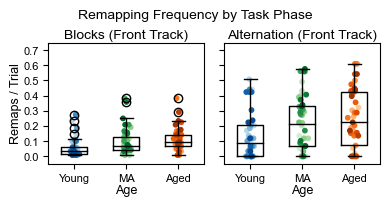

In [87]:
''' Plot Remapping Frequency in Front Track across Age Groups (Reviewer Figuer 2B)'''

fig, ax = plt.subplots(1,2, figsize = (4,2.25), sharey = True)
fig.suptitle('Remapping Frequency by Task Phase', fontsize = 10, y = 0.9)

sblockremaps_tog = [sblockremaps[y_sind10grid], sblockremaps[ma_sind10grid],sblockremaps[age_sind10grid]]
labels = ['Young','MA','Aged']
w = 0.5
ax[0].boxplot(sblockremaps_tog, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax[0].set_xlabel('Age', fontsize=9, labelpad=1)
ax[0].set_xticklabels(labels = labels, fontsize = 9)
ax[0].tick_params(labelsize = 8)
ax[0].set_ylabel('Remaps / Trial', fontsize=9, labelpad=1)
ax[0].set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])
ax[0].set_ylim([-0.05,0.75])
ax[0].set_title('Blocks (Front Track)', fontsize = 10, pad = 3)

for i in range(len(sblockremaps_tog)):
    y = sblockremaps_tog[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    ax[0].scatter(x, y, color = col_session10grid[i][:len(y)], edgecolors = col_session10grid[i][:len(y)], alpha = 1, s = 10)
    
saltremaps_tog = [saltremaps[y_sind10grid], saltremaps[ma_sind10grid],saltremaps[age_sind10grid]]
labels = ['Young','MA','Aged']
w = 0.5
ax[1].boxplot(saltremaps_tog, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax[1].set_xlabel('Age', fontsize=9, labelpad=1)
#ax[1].set_ylabel('Remaps / Trial', fontsize=9, labelpad=1)
ax[1].set_xticklabels(labels = labels, fontsize = 8)
ax[1].tick_params(labelsize = 8)
ax[1].set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])
ax[1].set_title('Alternation (Front Track)', fontsize = 10, pad = 3)

for i in range(len(saltremaps_tog)):
    y = saltremaps_tog[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    ax[1].scatter(x, y, color = col_session10grid[i][:len(y)], edgecolors = col_session10grid[i][:len(y)], alpha = 1, s = 10)
    
#ax[1].legend(handles = handles, labels = label_mice, ncol = 2, bbox_to_anchor=(1.2, 1))
plt.tight_layout()
#plt.savefig(save_folder + 'ReviewerFigure2B.png', dpi=400, bbox_inches='tight')
#plt.savefig(save_folder + 'ReviewerFigure2B.svg', dpi=400, bbox_inches='tight')
plt.show()

In [88]:
''' Perform Kruskal Wallis Test on Remapping Frequency in each Task Phase w/ Multiple Comparisons Correcition'''

print('n young, MA, aged sessions: ')
print(len(y_sind10grid), len(ma_sind10grid), len(age_sind10grid))

import statsmodels.api as sm
import scikit_posthocs as ph

H, p = stats.kruskal(sblockremaps[y_sind10grid],sblockremaps[ma_sind10grid],sblockremaps[age_sind10grid])
print('block remapping freq KW test H, p = ')
print(H, p)

print('\nmean ± SEM young block remap freq:')
print(str(np.mean(sblockremaps[y_sind10grid])) + ' ± '+ str(stats.sem(sblockremaps[y_sind10grid]))) 

print('mean ± SEM MA block remap freq:')
print(str(np.mean(sblockremaps[ma_sind10grid])) + ' ± '+ str(stats.sem(sblockremaps[ma_sind10grid]))) 

print('mean ± SEM age block remap freq:')
print(str(np.mean(sblockremaps[age_sind10grid])) + ' ± '+ str(stats.sem(sblockremaps[age_sind10grid]))) 

#make into dataframe
sex = list(animalmeta.Sex[mice_ind])
sexes = []
seshmice = []
seshcount = []
seshage = []
for m, session in zip(mice, sessions):
    msex = np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Sex'])
    age =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Age_Group'])
    totalsesh = len(session)
    
    for i, s in enumerate(session):
        sexes = np.append(sexes, msex)
        seshmice = np.append(seshmice, m)
        seshcount = np.append(seshcount, (i + 1))
        seshage = np.append(seshage, age)

# Collect all relevant data into pandas dataframe
allidx = np.concatenate((y_sind10grid,ma_sind10grid,age_sind10grid))
Animal_ID = list(seshmice[allidx])
Session = list(seshcount[allidx])
Sex = list(sexes[allidx])
Age_Group = list(seshage[allidx])
BlockFreq = list(sblockremaps[allidx])
AltFreq = list(saltremaps[allidx])

tuples = list(zip(Animal_ID, Session, Sex, Age_Group, BlockFreq, AltFreq))
tuples

df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session', 'Sex', 'AgeGroup','BlockFreq','AltFreq'])
df = df.dropna(axis = 0)

#Run Post Hoc Tests on Block Remapping Frequency
ph.posthoc_conover(df, val_col = 'BlockFreq', group_col = 'AgeGroup', p_adjust = 'holm')

n young, MA, aged sessions: 
45 44 41
block remapping freq KW test H, p = 
20.69563957818361 3.2062616898211854e-05

mean ± SEM young block remap freq:
0.0551663834526358 ± 0.008822868535539999
mean ± SEM MA block remap freq:
0.09867424242424243 ± 0.01257740650566647
mean ± SEM age block remap freq:
0.11101930538720779 ± 0.012147111342994212


,1.0,2.0,3.0
1.0,1.000000,0.000896,0.000021
2.0,0.000896,1.000000,0.256413
3.0,0.000021,0.256413,1.000000


In [89]:
#Run Post Hoc Tests on Alt Remapping Frequency
H, p = stats.kruskal(saltremaps[y_sind10grid],saltremaps[ma_sind10grid],saltremaps[age_sind10grid])
print('alt remapping freq KW test H, p = ')
print(H, p)

print('\nmean ± SEM young alt remap freq:')
print(str(np.mean(saltremaps[y_sind10grid])) + ' ± '+ str(stats.sem(saltremaps[y_sind10grid]))) 

print('mean ± SEM MA alt remap freq:')
print(str(np.mean(saltremaps[ma_sind10grid])) + ' ± '+ str(stats.sem(saltremaps[ma_sind10grid]))) 

print('mean ± SEM age alt remap freq:')
print(str(np.mean(saltremaps[age_sind10grid])) + ' ± '+ str(stats.sem(saltremaps[age_sind10grid]))) 

ph.posthoc_conover(df, val_col = 'AltFreq', group_col = 'AgeGroup', p_adjust = 'holm')

alt remapping freq KW test H, p = 
8.514046027635262 0.01416440695052393

mean ± SEM young alt remap freq:
0.13449074627893484 ± 0.022135368197081253
mean ± SEM MA alt remap freq:
0.21461096554147707 ± 0.02652742394754072
mean ± SEM age alt remap freq:
0.24761292608787377 ± 0.030059136706472644


,1.0,2.0,3.0
1.0,1.000000,0.065726,0.014667
2.0,0.065726,1.000000,0.459463
3.0,0.014667,0.459463,1.000000


In [90]:
''' Re-label spatial maps based on occupancy of Context A & B

 - If k = 2, map 0 is the map with the greatest relative number of trials in Block A (map 1 is the other)
 - If k = 3, map 0 & map 1 are the maps with greatest relative number of trials in Blocks A & B (map 2 is the other map)
 - If k = 4, map 0 & map 1 are the maps with greatest relative number of trials in Blocks A & B; between the remaining maps,
 whichever occupies more of blocks + A' is map 2. 
 
'''

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]     
        
        if len(gridcells) >= 10: 
            W = d['kmeans']['W']
            skippedrawtrialfil = d['skippedrawtrialfil'].astype(int)
            VRfrontidx = d['VRfrontidx'].astype(int)
            trials = skippedrawtrialfil[VRfrontidx]

            #assign map 0 to be the one dominating A, map 1 is the other map
            if (d['kmeans']['SilN'] == 2) and (d['kmeans']['onemap'][0] == False):
                # get map indices
                map_idx = W[:, 0].astype(bool)
                map0_idx = np.zeros_like(trials)
                map1_idx = np.zeros_like(trials)
                for i, t in enumerate(np.unique(trials)):
                    if map_idx[i]:
                        map0_idx[trials == t] = 1
                    else:
                        map1_idx[trials == t] = 1
                map0_idx = map0_idx.astype(bool)
                map1_idx = map1_idx.astype(bool)

                # get assign map 0 to be the one with the greate number of trials in Context A
                trials_0inA = np.sum(np.unique(trials[map0_idx]) < 80)
                trials_1inA = np.sum(np.unique(trials[map1_idx]) < 80) 

                if trials_0inA < trials_1inA: # swap labels
                    d['map0_idx'] = 1
                else:
                    d['map0_idx'] = 0
            
            #ditto, assign map 1 to be the one dominating B, map 2 is the other map
            elif (d['kmeans']['SilN'] == 3) and (d['kmeans']['onemap'][0] == False):
                map0_idx = np.zeros_like(trials)
                map1_idx = np.zeros_like(trials)
                map2_idx = np.zeros_like(trials)
                for i, t in enumerate(np.unique(trials)):
                    map_idx = np.where(W[i,:] == 1)[0][0]
                    if map_idx == 0:
                        map0_idx[trials == t] = 1
                    elif map_idx == 1:
                        map1_idx[trials == t] = 1
                    else:
                        map2_idx[trials == t] = 1
                map0_idx = map0_idx.astype(bool)
                map1_idx = map1_idx.astype(bool)
                map2_idx = map2_idx.astype(bool)
                
                # get assign map 0 to be the one with the greate number of trials in Context A
                map0trials = np.unique(trials[map0_idx])
                map1trials = np.unique(trials[map1_idx])
                map2trials = np.unique(trials[map2_idx])
                                       
                trials_0inA = np.sum(map0trials < 80)
                trials_1inA = np.sum(map1trials < 80) 
                trials_2inA = np.sum(map2trials < 80) 
                
                d['map0_idx'] = np.argmax([trials_0inA, trials_1inA, trials_2inA])
                
                # get assign map 1 to be the one with the greate number of trials in Context B
                trials_0inB = len(map0trials[(map0trials >= 80) & (map0trials < 140)])
                trials_1inB = len(map1trials[(map1trials >= 80) & (map1trials < 140)])
                trials_2inB = len(map2trials[(map2trials >= 80) & (map2trials < 140)])

                d['map1_idx'] = np.argmax([trials_0inB, trials_1inB, trials_2inB])
                d['map2_idx'] = np.setdiff1d([0,1,2], [d['map0_idx'], d['map1_idx']])[0]
 
            #ditto but map 2 is the map occupying most of A' map 3 is the other map        
            elif (d['kmeans']['SilN'] == 4) and (d['kmeans']['onemap'][0] == False):
                map0_idx = np.zeros_like(trials)
                map1_idx = np.zeros_like(trials)
                map2_idx = np.zeros_like(trials)
                map3_idx = np.zeros_like(trials)
                for i, t in enumerate(np.unique(trials)):
                    map_idx = np.where(W[i,:] == 1)[0][0]
                    if map_idx == 0:
                        map0_idx[trials == t] = 1
                    elif map_idx == 1:
                        map1_idx[trials == t] = 1
                    elif map_idx == 2:
                        map2_idx[trials == t] = 1
                    else:
                        map3_idx[trials == t] = 1
                map0_idx = map0_idx.astype(bool)
                map1_idx = map1_idx.astype(bool)
                map2_idx = map2_idx.astype(bool)
                map3_idx = map3_idx.astype(bool)
                
                # get assign map 0 to be the one with the greate number of trials in Context A
                map0trials = np.unique(trials[map0_idx])
                map1trials = np.unique(trials[map1_idx])
                map2trials = np.unique(trials[map2_idx])
                map3trials = np.unique(trials[map3_idx])
                
                maptrials = [map0trials, map1trials, map2trials, map3trials]
                                       
                trials_0inA = np.sum(map0trials < 80)
                trials_1inA = np.sum(map1trials < 80) 
                trials_2inA = np.sum(map2trials < 80)
                trials_3inA = np.sum(map3trials < 80)
                
                d['map0_idx'] = np.argmax([trials_0inA, trials_1inA, trials_2inA, trials_3inA])
                
                # get assign map 1 to be the one with the greate number of trials in Context B
                trials_0inB = len(map0trials[(map0trials >= 80) & (map0trials < 140)])
                trials_1inB = len(map1trials[(map1trials >= 80) & (map1trials < 140)])
                trials_2inB = len(map2trials[(map2trials >= 80) & (map2trials < 140)])
                trials_3inB = len(map3trials[(map3trials >= 80) & (map3trials < 140)])
                   
                d['map1_idx'] = np.argmax([trials_0inB, trials_1inB, trials_2inB, trials_3inB])    
                
                #decide which map has more trials before half way point in alternation, that is map 2
                possibleidxs = np.setdiff1d([0,1,2,3], [d['map0_idx'], d['map1_idx']])
                lengths = []
                for n in possibleidxs:
                    althalf = np.max(np.unique(trials)//4) + 140
                    lengths = np.append(lengths, len(maptrials[n][maptrials[n] < althalf]))
                                        
                if lengths[0] > lengths[1]:           
                    d['map2_idx'] = possibleidxs[0]
                    d['map3_idx'] = possibleidxs[1]
                else:
                    d['map2_idx'] = possibleidxs[1]
                    d['map3_idx'] = possibleidxs[0]


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [91]:
''' Assign identities to each now non-arbitrarily labeled spatial map as follows:

Map 0 is the map dominating A trials and is therefore assumed to represent Context A. Therefore, map0context = A by default.
Map 1 is the map dominating B trials and is therefore assumed to represent Context B. Therefore, map1context = B by default.

For k > 2 sessions, to align context, map 2/3 represents either Context A or B based on its relative Block A or B similarity.

This means that for k = 4 sessions there could be up to three maps associated with a particular context. 

'''

for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]
        
        if len(gridcells) >= 10: 
            sim = d['gridsimilarityfrontsorted']
            W = d['kmeans']['W']
            skippedrawtrialfil = d['skippedrawtrialfil'].astype(int)
            VRfrontidx = d['VRfrontidx'].astype(int)
            trials = np.unique(skippedrawtrialfil[VRfrontidx])
            Aidx = np.where(trials < 80)[0]
            Bidx = np.where((trials >= 80) & (trials < 140))[0]
        
            if (d['kmeans']['SilN'] == 3) and (d['kmeans']['onemap'][0] == False):
                print('\nfor mouse ' + str(m) + ', session ' + str(s[-1]) + ', k = ' + str(d['kmeans']['SilN']) + '... ')
            
                # get matrices comparing across each possible pair
                map2_idx = d['map2_idx']
                map_2 = W[:, d['map2_idx']].astype(bool)
                 
                sim_across1 = sim[Aidx, :]
                sim_across1 = sim_across1[:, map_2]
                simA = np.mean(sim_across1[np.triu_indices(n=sim_across1.shape[0], k=1, m=sim_across1.shape[1])])
                sim_across2 = sim[Bidx, :]
                sim_across2 = sim_across2[:, map_2]
                simB = np.mean(sim_across2[np.triu_indices(n=sim_across2.shape[0], k=1, m=sim_across2.shape[1])])
                
                if simB > simA:
                    d['map2context'] = 1 #1 = B
                    print('map 2 context = B')
                else: 
                    d['map2context'] = 0 #0 = A
                    print('map 2 context = A')
                    
            elif (d['kmeans']['SilN'] == 4) and (d['kmeans']['onemap'][0] == False):
                print('\nfor mouse ' + str(m) + ', session ' + str(s[-1]) + ' k = ' + str(d['kmeans']['SilN']) + '...')
                 
                # get matrices comparing across each possible pair
                map2_idx = d['map2_idx']
                map3_idx = d['map3_idx']
                map_2 = W[:, d['map2_idx']].astype(bool)
                map_3 = W[:, d['map3_idx']].astype(bool)
                 
                sim_across1 = sim[Aidx, :]
                sim_across1 = sim_across1[:, map_2]
                sim2A = np.mean(sim_across1[np.triu_indices(n=sim_across1.shape[0], k=1, m=sim_across1.shape[1])])
                sim_across2 = sim[Bidx, :]
                sim_across2 = sim_across2[:, map_2]
                sim2B = np.mean(sim_across2[np.triu_indices(n=sim_across2.shape[0], k=1, m=sim_across2.shape[1])])
                
                sim_across3 = sim[Aidx, :]
                sim_across3 = sim_across3[:, map_3]
                sim3A = np.mean(sim_across3[np.triu_indices(n=sim_across3.shape[0], k=1, m=sim_across3.shape[1])])
                sim_across4 = sim[Bidx, :]
                sim_across4 = sim_across4[:, map_3]
                sim3B = np.mean(sim_across4[np.triu_indices(n=sim_across4.shape[0], k=1, m=sim_across4.shape[1])])
               
                if sim2B > sim2A:
                    d['map2context'] = 1 #1 = B
                    print('map 2 context = B')
                else: 
                    d['map2context'] = 0 #0 = A
                    print('map 2 context = A')
                
                if sim3B > sim3A:
                    d['map3context'] = 1 #1 = B
                    print('map 3 context = B')
                else: 
                    d['map3context'] = 0 #0 = A
                    print('map 3 context = A')


for mouse A15, session 3 k = 4...
map 2 context = B
map 3 context = A

for mouse A15, session 4 k = 4...
map 2 context = B
map 3 context = B

for mouse A15, session 6 k = 4...
map 2 context = B
map 3 context = A

for mouse A16, session 1 k = 4...
map 2 context = B
map 3 context = B

for mouse A16, session 2, k = 3... 
map 2 context = A

for mouse A17, session 3, k = 3... 
map 2 context = B

for mouse A17, session 5, k = 3... 
map 2 context = A

for mouse A17, session 6 k = 4...
map 2 context = B
map 3 context = B

for mouse A18, session 2 k = 4...
map 2 context = B
map 3 context = B

for mouse A18, session 3 k = 4...
map 2 context = B
map 3 context = B

for mouse A18, session 4 k = 4...
map 2 context = B
map 3 context = A

for mouse A18, session 5 k = 4...
map 2 context = A
map 3 context = B

for mouse A19, session 2, k = 3... 
map 2 context = A

for mouse A19, session 4, k = 3... 
map 2 context = B

for mouse A19, session 6, k = 3... 
map 2 context = B

for mouse A20, session 2, k = 

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



for mouse A22, session 6 k = 4...
map 2 context = B
map 3 context = B

for mouse A23, session 3 k = 4...
map 2 context = B
map 3 context = B

for mouse A23, session 5 k = 4...
map 2 context = A
map 3 context = B

for mouse A23, session 6, k = 3... 
map 2 context = B

for mouse A24, session 2, k = 3... 
map 2 context = A

for mouse A24, session 3 k = 4...
map 2 context = A
map 3 context = A

for mouse A24, session 4, k = 3... 
map 2 context = B

for mouse A24, session 5 k = 4...
map 2 context = B
map 3 context = B

for mouse A24, session 6, k = 3... 
map 2 context = B

for mouse MA10F, session 2 k = 4...
map 2 context = A
map 3 context = B

for mouse MA1F, session 1, k = 3... 
map 2 context = A

for mouse MA1F, session 6, k = 3... 
map 2 context = A

for mouse MA2F, session 3 k = 4...
map 2 context = A
map 3 context = B

for mouse MA2F, session 5, k = 3... 
map 2 context = B

for mouse MA2F, session 6 k = 4...
map 2 context = B
map 3 context = A

for mouse MA3M, session 3 k = 4...
map 

mouse A19
session 2, k = 3


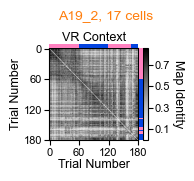

mouse A19
session 7, k = 2


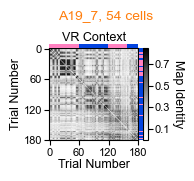

mouse MA1F
session 1, k = 3


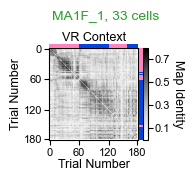

mouse MA1F
session 6, k = 3


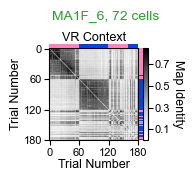

mouse Y27
session 1, k = 4


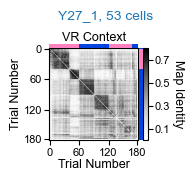

mouse Y27
session 6, k = 4


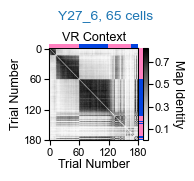

In [93]:
''' Plot examples of map identity vs. context aligned to grid network similarity matrices (Reviewer Figure 2A) 

Notes:
1. In the figure panel, we retained the left y-axis label and tick labels and the right y-axis label only on the first panel. 
2. In the figure panel, we retained the colorbar only on the last matrix.
3. In the first panel, the right y-axis label was moved closer to the matrix in Illustrator after removing the colorbar. 
4. Plotting is done this way to ensure that all matrices are equally sized.
5. For clarity in the manuscript, A19_2 and _7 were relabeled A19_1 and _6 because session 2 was the first real recording 
session from this mouse. 
6. Arrows were added in Illustrator to indicate the location of expected map identity transitions given VR context changes 
on the right y-axis.
7. Middle aged animals were named with their sex (F/M) in the recording files and metadata. For clarity, this flag was removed 
from MA animal names in the manuscript. 

'''

all_colors = ['xkcd:pink','xkcd:blue','xkcd:orchid','xkcd:azure']
CLU_W = 3
alt_idx = 140

# if you want to assess map labeling for all sessions and plot all grid network firing similarity as in Figure S4G:
#example_mice = mice
#example_sessions = sessions
#ex_sesh_only = False

# if you want to assess map labeling for & plot only the example sessions in Figure S4G:
example_mice = ['Y27','MA1F','A19']
example_sessions = ['021623_record1','022123_record6','102322_record1','102822_record6','012723_record2','020123_record7']
ex_sesh_only = True

for m, session in zip(mice, sessions):
    
    for s in session:
        d = data[m][s]

        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]     
        
        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        rawtrialfil = raw.item().get('trialfil')   

        if (m in example_mice) and (s in example_sessions) and (ex_sesh_only == True):
            W = d['kmeans']['W']
            skippedrawtrialfil = d['skippedrawtrialfil'].astype(int)
            VRfrontidx = d['VRfrontidx'].astype(int)

            # Load in left vs. right info
            trialinfo = raw.item().get('trialinfo')
            left = trialinfo['left']

            #binary context vector, excluding skipped trials, dark, & gain periods, 1 = Map A
            leftsort = left.copy()
            lefttail = left[alt_idx:]
            leftsort[alt_idx:] = lefttail[np.argsort(-1*lefttail, kind = 'stable')]

            context = []
            for i, t in enumerate(np.unique(skippedrawtrialfil[VRfrontidx])):
                context = np.append(context, leftsort[t.astype(int)])
            altcontextidx = np.where(np.diff(context) == 1.)[0][0] + 1 #index where alternation begins in context vectors
            
            if m in SM_aged_mice:
                col = 'C1'
            elif m in SM_MA_mice:
                col = 'C2'
            else:
                col = 'C0'
    
            SilN = d['kmeans']['SilN']

            print('mouse ' + m + '\nsession ' + s[-1] + ', k = ' + str(SilN))
            fig = plt.figure(figsize = (1.5,1.25))
            fig.suptitle(m + '_S' + s[-1] + ', ' + str(len(gridcells)) + ' cells', y = 1.15, fontsize=10, color = col)
            gs = gridspec.GridSpec(21, 21, figure=fig)

            # plot Euclidean similarity score
            ax1 = fig.add_subplot(gs[1:, :-1])
            sim = d['gridsimilarityfrontsorted']
            im = ax1.imshow(sim, aspect='auto', cmap='Greys')
            ax1.tick_params(labelleft=True)
            ax1.tick_params(labelbottom=True)
            ax1.set_xticks(ticks = [0,60,120,180])
            ax1.set_yticks(ticks = [0,60,120,180])
            ax1.set_xticks(ticks = [0,60,120,sim.shape[0]])
            ax1.set_yticks(ticks = [0,60,120,sim.shape[0]])
            ax1.set_xticklabels(labels = [0,60,120,180])
            ax1.set_yticklabels(labels = [0,60,120,180])
            ax1.set_ylabel('Trial Number', labelpad = 1, fontsize = 9)
            ax1.set_xlabel('Trial Number', labelpad = 1, fontsize = 9)
            ax1.set_title('VR Context', fontsize = 9, pad = 5)
            ax1.tick_params('both',which='both', labelsize=8, pad=0.5)
            ax1.text(250,150,'Map Identity', rotation = 270, fontsize = 9)
            ax1.tick_params('both', which='both', labelsize=8, pad=2)

            #colorbar
            cbar = fig.colorbar(im, shrink=1.0, ticks=np.arange(0.1, 0.8, 0.2))
            cbar.ax.tick_params(labelsize=8, pad=1)

            # k-means map identities
            ax2 = fig.add_subplot(gs[1:, 16])
            W = d['kmeans']['W'].copy()

            if SilN == 2:
                map_0 = W[:, d['map0_idx']].astype(bool)

                for i, t in enumerate(map_0):
                    if t == True:
                        ax2.vlines(1, i, i + 1, colors='xkcd:pink', lw= CLU_W, linestyles= 'solid', alpha = 1)
                    else:
                        ax2.vlines(1, i, i + 1, colors='xkcd:blue', lw= CLU_W, linestyles='solid', alpha = 1)
            elif SilN == 3:
                map_0 = W[:, d['map0_idx']].astype(bool)
                map_1 = W[:, d['map1_idx']].astype(bool)
                map_2 = W[:, d['map2_idx']].astype(bool)

                if d['map2context'] == 0:
                    map_A = map_0 + map_2
                else:
                    map_A = map_0

                for i, t in enumerate(map_A):
                    if t == True:
                        ax2.vlines(1, i, i + 1, colors='xkcd:pink', lw= CLU_W, linestyles= 'solid', alpha = 1)
                    else:
                        ax2.vlines(1, i, i + 1, colors='xkcd:blue', lw= CLU_W, linestyles= 'solid', alpha = 1)        

            else:
                map_0 = W[:, d['map0_idx']].astype(bool)
                map_1 = W[:, d['map1_idx']].astype(bool)
                map_2 = W[:, d['map2_idx']].astype(bool)
                map_3 = W[:, d['map3_idx']].astype(bool)

                if d['map2context'] == 0 and d['map3context'] == 0:
                    map_A = map_0 + map_2 + map_3
                elif d['map2context'] == 1 and d['map3context'] == 0:
                    map_A = map_0 + map_3
                elif d['map2context'] == 0 and d['map3context'] == 1:
                    map_A = map_0 + map_2
                else:
                    map_A = map_0

                for i, t in enumerate(map_A):
                    if t == True:
                        ax2.vlines(1, i, i + 1, colors='xkcd:pink', lw= CLU_W, linestyles= 'solid', alpha = 1)
                    else:
                        ax2.vlines(1, i, i + 1, colors='xkcd:blue', lw= CLU_W, linestyles= 'solid', alpha = 1)  

            ax2.set_xlim([0.5, 1.5])
            ax2.set_ylim([W.shape[0], 0])
            plt.axis('off')    

            # VR context labels
            ax3 = fig.add_subplot(gs[0, 0:16])
            for i, t in enumerate(context.astype(bool)):
                if t == True:
                    ax3.hlines(1, i, i + 1, colors='xkcd:pink', lw = CLU_W, linestyles= 'solid', alpha = 1)
                else:
                    ax3.hlines(1, i, i + 1, colors='xkcd:blue', lw = CLU_W, linestyles='solid', alpha = 1)

            ax3.set_ylim([0.5, 1.5])
            ax3.set_xlim([0, W.shape[0]])
            plt.axis('off')

            fig.savefig(save_folder + m + '_' + s + '_ReviewerFigure2A.png', dpi=400, bbox_inches='tight')
            fig.savefig(save_folder + m + '_' + s + '_ReviewerFigure2A.svg', dpi=400, bbox_inches='tight')
            plt.show()

In [94]:
''' Calculate fraction of trials during blocks with context-map alignment '''

sblockfrac = []
mblockfrac = []
alt_idx = 140

for m, session in zip(mice, sessions):
    
    m_contextblock = []
    m_mapAblock = []
    
    for s in session:
        d = data[m][s]

        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]     
        
        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        rawtrialfil = raw.item().get('trialfil')   

        if len(gridcells) >= 10:
            W = d['kmeans']['W']
            skippedrawtrialfil = d['skippedrawtrialfil'].astype(int)
            VRfrontidx = d['VRfrontidx'].astype(int)

            # Load in left vs. right info
            trialinfo = raw.item().get('trialinfo')
            left = trialinfo['left']

            #binary context vector, excluding skipped trials, dark, & gain periods, 1 = Map A
            leftsort = left.copy()
            lefttail = left[alt_idx:]
            leftsort[alt_idx:] = lefttail[np.argsort(-1*lefttail, kind = 'stable')]

            context = []
            for i, t in enumerate(np.unique(skippedrawtrialfil[VRfrontidx])):
                context = np.append(context, leftsort[t.astype(int)])
            altcontextidx = np.where(np.diff(context) == 1.)[0][0] #index where alternation begins in context vectors
            
            if (d['kmeans']['SilN'] == 2) and (d['kmeans']['onemap'][0] == False):
                map_A = W[:, d['map0_idx']].astype(bool)
                
                #save out to be able to compute at animal level
                m_mapAblock = np.append(m_mapAblock, map_A[:altcontextidx])
                m_contextblock = np.append(m_contextblock, context[:altcontextidx])

                #compute fraction trials in map = context
                sblockfrac = np.append(sblockfrac, np.sum(map_A[:altcontextidx] == context[:altcontextidx])/len(context[:altcontextidx]))
           
            elif (d['kmeans']['SilN'] == 3) and (d['kmeans']['onemap'][0] == False):
                if d['map2context'] == 0: #if map 2 is closer to representing context A, combine map 0 and 2 trials into context A trials
                    map_A = W[:, d['map0_idx']] + W[:, d['map2_idx']]
                    map_A = map_A.astype(bool)
                else:
                    map_A = W[:, d['map0_idx']].astype(bool)
                
                #save out to be able to compute at animal level
                m_mapAblock = np.append(m_mapAblock, map_A[:altcontextidx])
                m_contextblock = np.append(m_contextblock, context[:altcontextidx])

                #compute fraction trials in map = context
                sblockfrac = np.append(sblockfrac, np.sum(map_A[:altcontextidx] == context[:altcontextidx])/len(context[:altcontextidx]))
            
            elif (d['kmeans']['SilN'] == 4) and (d['kmeans']['onemap'][0] == False):
                if (d['map2context'] == 0) and (d['map3context'] == 0): #if map 2 & 3 are closer to representing context A, combine them into context A trials
                    map_A = W[:, d['map0_idx']] + W[:, d['map2_idx']] + W[:, d['map3_idx']]
                    map_A = map_A.astype(bool)
                elif (d['map2context'] == 0) and (d['map3context'] == 1):
                    map_A = W[:, d['map0_idx']] +  W[:, d['map2_idx']]
                    map_A = map_A.astype(bool)    
                elif (d['map2context'] == 1) and (d['map3context'] == 0):
                    map_A = W[:, d['map0_idx']] +  W[:, d['map3_idx']]
                    map_A = map_A.astype(bool)
                else: #only map 0 represents A
                    map_A = W[:, d['map0_idx']].astype(bool)
                    
                #save out to be able to compute at animal level
                m_mapAblock = np.append(m_mapAblock, map_A[:altcontextidx])
                m_contextblock = np.append(m_contextblock, context[:altcontextidx])

                #compute fraction trials in map = context
                sblockfrac = np.append(sblockfrac, np.sum(map_A[:altcontextidx] == context[:altcontextidx])/len(context[:altcontextidx]))     
            
            else:
                sblockfrac = np.append(sblockfrac, np.nan)
        
        else:
            sblockfrac = np.append(sblockfrac, np.nan)

    #compute fraction trials in map = context
    if len(m_contextblock) > 0:
        mblockfrac = np.append(mblockfrac, np.sum(m_mapAblock == m_contextblock)/len(m_contextblock))
    else:
        mblockfrac = np.append(mblockfrac, np.nan)

In [95]:
''' Calculate fraction of trials during alternation with context-map alignment '''

saltfrac = []
maltfrac = []
alt_idx = 140

for m, session in zip(mice, sessions):
    
    m_contextalt = []
    m_mapAalt = []
    
    for s in session:
        d = data[m][s]

        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]     
        
        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        rawtrialfil = raw.item().get('trialfil')   

        if len(gridcells) >= 10:
            W = d['kmeans']['W']
            skippedrawtrialfil = d['skippedrawtrialfil'].astype(int)
            VRfrontidx = d['VRfrontidx'].astype(int)

            # Load in left vs. right info
            trialinfo = raw.item().get('trialinfo')
            left = trialinfo['left']

            #binary context vector, excluding skipped trials, dark, & gain periods, 1 = Map A
            leftsort = left.copy()
            lefttail = left[alt_idx:]
            leftsort[alt_idx:] = lefttail[np.argsort(-1*lefttail, kind = 'stable')]

            context = []
            for i, t in enumerate(np.unique(skippedrawtrialfil[VRfrontidx])):
                context = np.append(context, leftsort[t.astype(int)])
            altcontextidx = np.where(np.diff(context) == 1.)[0][0] #index where alternation begins in context vectors
            
            if (d['kmeans']['SilN'] == 2) and (d['kmeans']['onemap'][0] == False):
                map_A = W[:, d['map0_idx']].astype(bool)
                
                #save out to be able to compute at animal level
                m_mapAalt = np.append(m_mapAalt, map_A[altcontextidx:])
                m_contextalt = np.append(m_contextalt, context[altcontextidx:])

                #compute fraction trials in map = context
                saltfrac = np.append(saltfrac, np.sum(map_A[altcontextidx:] == context[altcontextidx:])/len(context[altcontextidx:]))
           
            elif (d['kmeans']['SilN'] == 3) and (d['kmeans']['onemap'][0] == False):
                if d['map2context'] == 0: #if map 2 is closer to representing context A, combine map 0 and 2 trials into context A trials
                    map_A = W[:, d['map0_idx']] + W[:, d['map2_idx']]
                    map_A = map_A.astype(bool)
                else:
                    map_A = W[:, d['map0_idx']].astype(bool)
                
                #save out to be able to compute at animal level
                m_mapAalt = np.append(m_mapAalt, map_A[altcontextidx:])
                m_contextalt = np.append(m_contextalt, context[altcontextidx:])

                #compute fraction trials in map = context
                saltfrac = np.append(saltfrac, np.sum(map_A[altcontextidx:] == context[altcontextidx:])/len(context[altcontextidx:]))
            
            elif (d['kmeans']['SilN'] == 4) and (d['kmeans']['onemap'][0] == False):
                if (d['map2context'] == 0) and (d['map3context'] == 0): #if map 2 & 3 are closer to representing context A, combine them into context A trials
                    map_A = W[:, d['map0_idx']] + W[:, d['map2_idx']] + W[:, d['map3_idx']]
                    map_A = map_A.astype(bool)
                elif (d['map2context'] == 0) and (d['map3context'] == 1):
                    map_A = W[:, d['map0_idx']] +  W[:, d['map2_idx']]
                    map_A = map_A.astype(bool)    
                elif (d['map2context'] == 1) and (d['map3context'] == 0):
                    map_A = W[:, d['map0_idx']] +  W[:, d['map3_idx']]
                    map_A = map_A.astype(bool)
                else: #only map 0 represents A
                    map_A = W[:, d['map0_idx']].astype(bool)
                    
                #save out to be able to compute at animal level
                m_mapAalt = np.append(m_mapAalt, map_A[altcontextidx:])
                m_contextalt = np.append(m_contextalt, context[altcontextidx:])

                #compute fraction trials in map = context
                saltfrac = np.append(saltfrac, np.sum(map_A[altcontextidx:] == context[altcontextidx:])/len(context[altcontextidx:]))     
            
            else:
                saltfrac = np.append(saltfrac, np.nan)
        
        else:
            saltfrac = np.append(saltfrac, np.nan)

    #compute fraction trials in map = context
    if len(m_contextalt) > 0:
        maltfrac = np.append(maltfrac, np.sum(m_mapAalt == m_contextalt)/len(m_contextalt))
    else:
        maltfrac = np.append(maltfrac, np.nan)

In [96]:
''' Find where nan and ignore for plotting '''
nan_idx = np.where(np.isnan(saltfrac) == True)[0]

# Adjust y_sind, ma_sind, age_sind for subsequent plots
y_sind10grid = np.asarray(np.setdiff1d(y_sind, nan_idx).astype(int))
ma_sind10grid = np.asarray(np.setdiff1d(ma_sind, nan_idx).astype(int))
age_sind10grid = np.asarray(np.setdiff1d(age_sind, nan_idx).astype(int))

# Adjust colormaps for grid plots
yidx = []
maidx = []
aidx = []
for i in nan_idx:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    maidx = np.append(maidx, np.where(ma_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int)) 

col_session_young10grid = np.delete(col_session_young, list(yidx.astype(int)), axis = 0)
col_session_ma10grid = np.delete(col_session_MA, list(maidx.astype(int)), axis = 0)
col_session_old10grid = np.delete(col_session_old, list(aidx.astype(int)), axis = 0)
col_session10grid = [col_session_young10grid, col_session_ma10grid, col_session_old10grid] 

Association btwn Young, MA, Aged, & All Alt Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.24500659306638184 0.10938503886565974 0.09976376336590487 0.11989644195470882
P [Young, MA, Aged, All]: 
0.10477439643549911 0.4796812386007424 0.53486548031918 0.1742310583303376
Association btwn Young, MA, Aged, & All Task Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.5381141645655168 0.4558406226844666 0.6665452776110472 0.5246305841548742
P [Young, MA, Aged, All]: 
4.502700664602068e-08 8.083217599923313e-06 8.184132390828196e-12 8.646276060342627e-20
n young task halves: 90
n MA task halves: 88
n aged task halves: 82


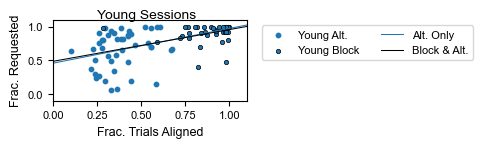

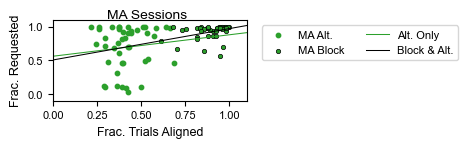

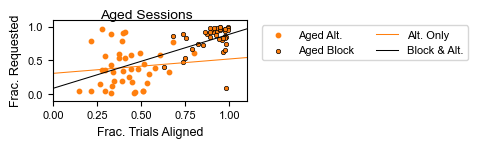

In [97]:
''' Plot Reviewer Figure 2E for Front of Track Activity'''
reqalt_rates = np.asarray(reqalt_rates)
reqblock_rates = np.asarray(reqblock_rates)

#Linear regression just for alternation
res = stats.linregress(saltfrac[y_sind10grid],reqalt_rates[y_sind10grid])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(saltfrac[ma_sind10grid],reqalt_rates[ma_sind10grid])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(saltfrac[age_sind10grid],reqalt_rates[age_sind10grid])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

allidx = np.concatenate((y_sind10grid,ma_sind10grid,age_sind10grid))
res = stats.linregress(saltfrac[allidx],reqalt_rates[allidx])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('Association btwn Young, MA, Aged, & All Alt Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

#Linear regression for block and alternation together
res = stats.linregress(np.hstack((sblockfrac[y_sind10grid],saltfrac[y_sind10grid])),np.hstack((reqblock_rates[y_sind10grid],reqalt_rates[y_sind10grid])))
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(np.hstack((sblockfrac[ma_sind10grid],saltfrac[ma_sind10grid])),np.hstack((reqblock_rates[ma_sind10grid],reqalt_rates[ma_sind10grid])))
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(np.hstack((sblockfrac[age_sind10grid],saltfrac[age_sind10grid])),np.hstack((reqblock_rates[age_sind10grid],reqalt_rates[age_sind10grid])))
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

allidx = np.concatenate((y_sind10grid,ma_sind10grid,age_sind10grid))
res = stats.linregress(np.hstack((sblockfrac[allidx],saltfrac[allidx])),np.hstack((reqblock_rates[allidx],reqalt_rates[allidx])))
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('Association btwn Young, MA, Aged, & All Task Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

print('n young task halves: ' + str(len(np.hstack((sblockfrac[y_sind10grid],saltfrac[y_sind10grid])))))
print('n MA task halves: ' + str(len(np.hstack((sblockfrac[ma_sind10grid],saltfrac[ma_sind10grid])))))
print('n aged task halves: ' + str(len(np.hstack((sblockfrac[age_sind10grid],saltfrac[age_sind10grid])))))
        
#Plot Figure 3E
fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Young Sessions', fontsize = 10)
ax.scatter(saltfrac[y_sind10grid],reqalt_rates[y_sind10grid], color = 'C0', s = 10, label = 'Young Alt.')
ax.scatter(sblockfrac[y_sind10grid],reqblock_rates[y_sind10grid], color = 'C0', s = 10, edgecolor = 'k', lw = 0.5, label = 'Young Block')
ax.set_xlabel('Frac. Trials Aligned', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0,1.1])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, yslope1*X_plot + yint1, '-', color = 'C0', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, yslope2*X_plot + yint2, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8,bbox_to_anchor = (1.05,1.0), ncol = 2)
plt.savefig(save_folder + 'ReviewerFigure2Eleft.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure2Eleft.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('MA Sessions', fontsize = 10)
ax.scatter(saltfrac[ma_sind10grid],reqalt_rates[ma_sind10grid], color = 'C2', s = 10, label = 'MA Alt.')
ax.scatter(sblockfrac[ma_sind10grid],reqblock_rates[ma_sind10grid], color = 'C2', s = 10, edgecolor = 'k', lw = 0.5, label = 'MA Block')
ax.set_xlabel('Frac. Trials Aligned', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0,1.1])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, maslope1*X_plot + maint1, '-', color = 'C2', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, maslope2*X_plot + maint2, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8,bbox_to_anchor = (1.05,1.0), ncol = 2)
plt.savefig(save_folder + 'ReviewerFigure2Emiddle.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure2Emiddle.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Aged Sessions', fontsize = 10)
ax.scatter(saltfrac[age_sind10grid],reqalt_rates[age_sind10grid], color = 'C1', s = 10, label = 'Aged Alt.')
ax.scatter(sblockfrac[age_sind10grid],reqblock_rates[age_sind10grid], color = 'C1', s = 10, edgecolor = 'k', lw = 0.5, label = 'Aged Block')
ax.set_xlabel('Frac. Trials Aligned', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0,1.1])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, aslope1*X_plot + aint1, '-', linewidth = 0.75, color = 'C1', label = 'Alt. Only')
ax.plot(X_plot, aslope2*X_plot + aint2, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8,bbox_to_anchor = (1.05,1.0), ncol = 2)
plt.savefig(save_folder + 'ReviewerFigure2Eright.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure2Eright.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

Optimization terminated successfully.
         Current function value: 0.593968
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                Aligned   No. Observations:                 7818
Model:                          Logit   Df Residuals:                     7803
Method:                           MLE   Df Model:                           14
Date:                Wed, 07 Aug 2024   Pseudo R-squ.:                  0.1206
Time:                        11:12:02   Log-Likelihood:                -4643.6
converged:                       True   LL-Null:                       -5280.8
Covariance Type:            nonrobust   LLR p-value:                1.884e-263
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               0.1015      0.100 

<Figure size 200x1000 with 0 Axes>

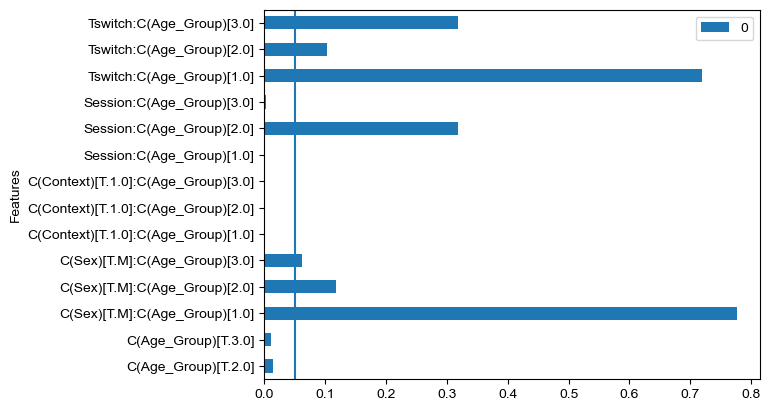

<Figure size 200x1000 with 0 Axes>

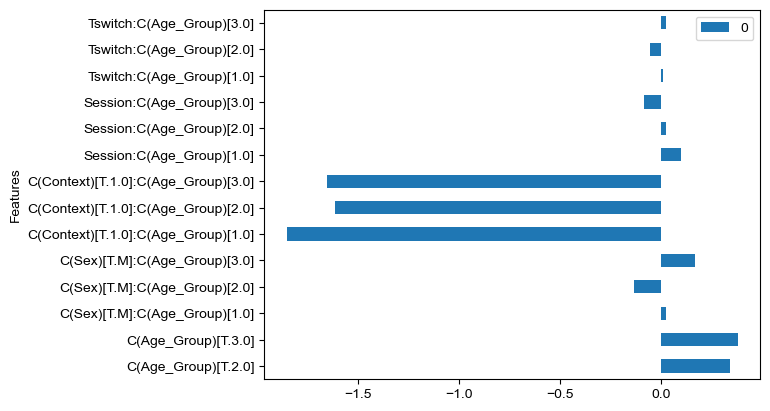

In [143]:
'''Model Probability of a Context:Aligned Trial in Front of Track'''

import statsmodels.api as sm
from patsy import dmatrices

#gather fixed effects into lists & then into dataframe
Animal_ID = list(allmice)
Session = list(allsesh)
Sex = list(allsex)
Age_Group = list(allage)
Trial_ID = list(alltrialid)
Cohort = list(allcohort)
K = list(allk)

Req = list(allreq)
Aligned = list(allaligned)
Context = list(allcontext)
Tswitch = list(alltswitch)
Switch = list(allswitch)

tuples = list(zip(Animal_ID, Session, Sex, Age_Group, Trial_ID, Cohort, K, Req, Aligned, Context, Tswitch, Switch))
tuples

df = pd.DataFrame(tuples, columns = ['Animal_ID', 'Session', 'Sex', 'Age_Group', 'Trial_ID', 'Cohort', 'K','Req', 'Aligned', 'Context', 'Tswitch', 'Switch'])
df = df.dropna(axis = 0)

# model probability of a correct response
y,X = dmatrices('Aligned ~ 1 + C(Age_Group) + C(Sex):C(Age_Group) + Session:C(Age_Group) + C(Context):C(Age_Group) + Tswitch:C(Age_Group)', data = df, return_type = 'dataframe')
#y,X = dmatrices('Aligned ~ 1 + C(Age_Group) + C(Sex):C(Age_Group) + C(Remap) + C(Remap):C(Age_Group) + Session:C(Age_Group) + C(Context):C(Age_Group) + Switch:C(Age_Group)', data = df, return_type = 'dataframe')
maligned = sm.Logit(y,X).fit()
print(maligned.summary())

#plot fitted values
pvalues = pd.concat([maligned.pvalues[1:].T.to_frame()], 
                   ignore_index=False)
pvalues.index.name = 'Features'
pvalues.reset_index()

params = pd.concat([maligned.params[1:].T.to_frame()], 
                   ignore_index=False)
params.index.name = 'Features'
params.reset_index()

results = pd.merge(params, pvalues, how = "left", on = "Features",suffixes=("params","pvalues")).fillna(0).reset_index()
results = results.rename(columns={'0params': 'Params', "0pvalues":'Pvalues'})

plt.figure(figsize=(2,10))
pvalues.plot.barh()
plt.axvline(x = 0.05)
plt.show()

plt.figure(figsize=(2,10))
params.plot.barh()
plt.show()

final = results.loc[(results['Pvalues'] < 0.05)].reset_index(drop=True)
final['Odds'] = np.exp(final['Params'])
final['Percent'] = (final['Odds'] - 1)*100
final.sort_values(by=['Odds'], ascending = False).reset_index(drop=True)

#plot fitted values
hue_order = [1.0, 3.0, 2.0]
df['predicted'] = maligned.predict(X)
new_palette =  sns.color_palette(n_colors = 3)
new_palette[1], new_palette[2] = new_palette[2], new_palette[1]

In [144]:
''' Table of All Predictors '''

results

,Features,Params,Pvalues
0,C(Age_Group)[T.2.0],0.344184,1.419418e-02
1,C(Age_Group)[T.3.0],0.381961,1.002261e-02
2,C(Sex)[T.M]:C(Age_Group)[1.0],0.025026,7.763397e-01
3,C(Sex)[T.M]:C(Age_Group)[2.0],-0.133476,1.179104e-01
4,C(Sex)[T.M]:C(Age_Group)[3.0],0.171409,6.204670e-02
5,C(Context)[T.1.0]:C(Age_Group)[1.0],-1.853203,4.959027e-95
6,C(Context)[T.1.0]:C(Age_Group)[2.0],-1.616244,3.013599e-78
7,C(Context)[T.1.0]:C(Age_Group)[3.0],-1.652381,1.241472e-74
8,Session:C(Age_Group)[1.0],0.099555,2.060225e-04
9,Session:C(Age_Group)[2.0],0.023491,3.187319e-01


In [145]:
''' Table of only Significant Predictors with OR'''

final

,Features,Params,Pvalues,Odds,Percent
0,C(Age_Group)[T.2.0],0.344184,1.419418e-02,1.410839,41.083864
1,C(Age_Group)[T.3.0],0.381961,1.002261e-02,1.465154,46.515422
2,C(Context)[T.1.0]:C(Age_Group)[1.0],-1.853203,4.959027e-95,0.156734,-84.326574
3,C(Context)[T.1.0]:C(Age_Group)[2.0],-1.616244,3.013599e-78,0.198643,-80.135662
4,C(Context)[T.1.0]:C(Age_Group)[3.0],-1.652381,1.241472e-74,0.191593,-80.840681
5,Session:C(Age_Group)[1.0],0.099555,2.060225e-04,1.104679,10.467895
6,Session:C(Age_Group)[3.0],-0.082697,2.854036e-03,0.920630,-7.936964



n aged, MA, young mice on day 1
5 8 6

n aged, MA, young mice on day 2
7 7 8

n aged, MA, young mice on day 3
8 8 8

n aged, MA, young mice on day 4
7 4 8

n aged, MA, young mice on day 5
8 8 8

n aged, MA, young mice on day 6
6 9 7


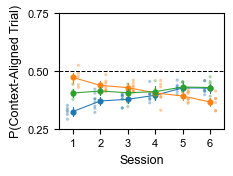


n aged, MA, young mice on day 1
5 8 6

n aged, MA, young mice on day 2
7 7 8

n aged, MA, young mice on day 3
8 8 8

n aged, MA, young mice on day 4
7 4 8

n aged, MA, young mice on day 5
8 8 8

n aged, MA, young mice on day 6
6 9 7


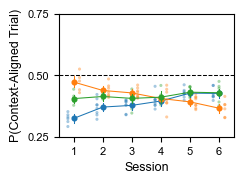

In [146]:
''' Plot Figure S5K right (alternation context alignment probability by age & session)'''
#GATHER RESULTS
results = df.groupby(by = ['Animal_ID','Session'], as_index = False)['predicted'].aggregate('mean')
seshanimal = np.asarray(results['Animal_ID'])
seshcount = np.asarray(results['Session'])
seshmean = np.asarray(results['predicted'])

r = 6
salignedprobfitted_seg_aged = [[] * r for i in range(r)]
salignedprobfitted_seg_MA = [[] * r for i in range(r)]
salignedprobfitted_seg_young = [[] * r for i in range(r)]

sessioncount_fitted_aged = [[] * r for i in range(r)]
sessioncount_fitted_MA = [[] * r for i in range(r)]
sessioncount_fitted_young = [[] * r for i in range(r)]

for m, session in zip(mice, sessions): 
    
    if m in seshanimal: 
        animalidx = np.where(seshanimal == m)[0][0]
        session_idx = np.where(seshanimal == m)[0]

        if m in SM_aged_mice:
            for i, c in enumerate(seshcount[session_idx]):
                idx = c.astype(int)
                salignedprobfitted_seg_aged[idx] = np.append(salignedprobfitted_seg_aged[idx], seshmean[session_idx][i])
                sessioncount_fitted_aged[idx] = np.append(sessioncount_fitted_aged[idx], c)
        elif m in SM_MA_mice:
            for i, c in enumerate(seshcount[session_idx]):
                idx = c.astype(int)
                salignedprobfitted_seg_MA[idx] = np.append(salignedprobfitted_seg_MA[idx], seshmean[session_idx][i])
                sessioncount_fitted_MA[idx] = np.append(sessioncount_fitted_MA[idx], c)
        else:
            for i, c in enumerate(seshcount[session_idx]):
                idx = c.astype(int)
                salignedprobfitted_seg_young[idx] = np.append(salignedprobfitted_seg_young[idx], seshmean[session_idx][i])
                sessioncount_fitted_young[idx] = np.append(sessioncount_fitted_young[idx], c)
    else:
        #print(m, session)
        pass   
    
## PLOT
fig, ax = plt.subplots(figsize = (2.125,1.50))
#scatter plot fitted data:
for i in range(0,len(salignedprobfitted_seg_aged)):
    print('\nn aged, MA, young mice on day ' + str(i + 1))
    print(len(sessioncount_fitted_aged[i]),len(sessioncount_fitted_MA[i]), len(sessioncount_fitted_young[i]))
    ax.scatter(sessioncount_fitted_aged[i] + 0.2, salignedprobfitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax.scatter(sessioncount_fitted_MA[i], salignedprobfitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax.scatter(sessioncount_fitted_young[i] - 0.2, salignedprobfitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

g =  sns.pointplot(x = df['Session'], y = maligned.predict(X), hue = df['Age_Group'], hue_order = hue_order, scale = 0.5)
ax.set_ylabel('P(Context-Aligned Trial)', fontsize = 9)
ax.set_xlabel('Session', fontsize = 9)
ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels(labels = [1,2,3,4,5,6])
ax.set_xlim([-0.5,5.5])
ax.set_yticks([0.25,0.5,0.75])
ax.set_ylim([0.25,0.75])
ax.tick_params(labelsize = 8)
ax.hlines(y = 0.5,xmin = -0.5, xmax = 5.5, linestyle = '--', lw = 0.75, color = 'k')
#plt.legend(bbox_to_anchor = (1.02,1), fontsize = 9)
g.legend_.remove()
for l in g.lines:
    plt.setp(l,linewidth = 0.75)
fig.savefig(save_folder + 'S5Kleft.png', dpi = 400, bbox_inches='tight')
fig.savefig(save_folder + 'S5Kleft.svg', dpi = 400, bbox_inches='tight')
fig.savefig(save_folder + 'ReviewerFigure2Dleft.png', dpi = 400, bbox_inches='tight')
fig.savefig(save_folder + 'ReviewerFigure2Dleft.svg', dpi = 400, bbox_inches='tight')
plt.show()


n aged, MA, young mice on trials from switch 0
9 10 9

n aged, MA, young mice on trials from switch 1
9 10 9

n aged, MA, young mice on trials from switch 2
9 10 9

n aged, MA, young mice on trials from switch 3
9 10 9

n aged, MA, young mice on trials from switch 4
9 10 9

n aged, MA, young mice on trials from switch 5
9 10 8

n aged, MA, young mice on trials from switch 6
9 7 8

n aged, MA, young mice on trials from switch 7
6 3 6


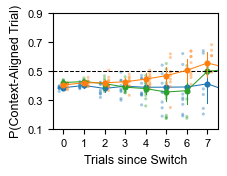


n aged, MA, young mice on trials from switch 0
9 10 9

n aged, MA, young mice on trials from switch 1
9 10 9

n aged, MA, young mice on trials from switch 2
9 10 9

n aged, MA, young mice on trials from switch 3
9 10 9

n aged, MA, young mice on trials from switch 4
9 10 9

n aged, MA, young mice on trials from switch 5
9 10 8

n aged, MA, young mice on trials from switch 6
9 7 8

n aged, MA, young mice on trials from switch 7
6 3 6


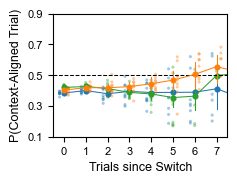

In [147]:
''' Check Relationship of Recency of Switch & Alignment during Alternation (Front of Track)'''

## COLLECT RESULTS
results = df.groupby(by = ['Animal_ID','Tswitch'], as_index = False)['predicted'].aggregate('mean')
seshanimal = np.asarray(results['Animal_ID'])
seshcount = np.asarray(results['Tswitch'])
seshmean = np.asarray(results['predicted'])

r = 8
salignedprobfitted_seg_aged = [[] * r for i in range(r)]
salignedprobfitted_seg_MA = [[] * r for i in range(r)]
salignedprobfitted_seg_young = [[] * r for i in range(r)]

sessioncount_fitted_aged = [[] * r for i in range(r)]
sessioncount_fitted_MA = [[] * r for i in range(r)]
sessioncount_fitted_young = [[] * r for i in range(r)]

for m, session in zip(mice, sessions): 
    
    if m in seshanimal: 
        animalidx = np.where(seshanimal == m)[0][0]
        max_tswitch = len(np.where(seshanimal == m)[0])
        if max_tswitch <= 8:
            session_idx = np.arange(animalidx, max_tswitch + animalidx)
        else:
            session_idx = np.arange(animalidx, 8 + animalidx)

        if m in SM_aged_mice:
            for i, c in enumerate(seshcount[session_idx]):
                idx = c.astype(int)
                salignedprobfitted_seg_aged[idx] = np.append(salignedprobfitted_seg_aged[idx], seshmean[session_idx][i])
                sessioncount_fitted_aged[idx] = np.append(sessioncount_fitted_aged[idx], c)
        elif m in SM_MA_mice:
            for i, c in enumerate(seshcount[session_idx]):
                idx = c.astype(int)
                salignedprobfitted_seg_MA[idx] = np.append(salignedprobfitted_seg_MA[idx], seshmean[session_idx][i])
                sessioncount_fitted_MA[idx] = np.append(sessioncount_fitted_MA[idx], c)
        else:
            for i, c in enumerate(seshcount[session_idx]):
                idx = c.astype(int)
                salignedprobfitted_seg_young[idx] = np.append(salignedprobfitted_seg_young[idx], seshmean[session_idx][i])
                sessioncount_fitted_young[idx] = np.append(sessioncount_fitted_young[idx], c)
    else:
        pass

## PLOT
fig, ax = plt.subplots(figsize = (2.125,1.50))
g = sns.pointplot(data = df, x = 'Tswitch', y = 'predicted', ax = ax, hue = 'Age_Group', palette = new_palette, scale = 0.5)
ax.set_ylabel('P(Context-Aligned Trial)', fontsize = 9)
ax.set_xlabel('Trials since Switch', fontsize = 9)
ax.set_xlim([-0.5,7.5])
#ax.set_title('Age x Aligned Trial', fontsize = 10)
ax.set_xticks([0,1,2,3,4,5,6,7])
ax.set_yticks([0.1,0.3,0.5,0.7,0.9])
ax.set_ylim([0.1,0.9])
ax.set_xticklabels([0,1,2,3,4,5,6,7])
ax.tick_params(labelsize = 8)
ax.hlines(y = 0.5,xmin = -0.5, xmax = 7.5, linestyle = '--', lw = 0.75, color = 'k')
#plt.legend(bbox_to_anchor = (1.02,1), fontsize = 9)
g.legend_.remove()
for l in g.lines:
    plt.setp(l,linewidth = 0.75)

#scatter plot actual raw data:
for i in range(0,len(salignedprobfitted_seg_aged)):
    print('\nn aged, MA, young mice on trials from switch ' + str(i))
    print(len(sessioncount_fitted_aged[i]),len(sessioncount_fitted_MA[i]), len(sessioncount_fitted_young[i]))
    ax.scatter(sessioncount_fitted_aged[i] + 0.2, salignedprobfitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax.scatter(sessioncount_fitted_MA[i], salignedprobfitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax.scatter(sessioncount_fitted_young[i] - 0.2, salignedprobfitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

fig.savefig(save_folder + 'S5Kright.png', dpi = 400, bbox_inches='tight')
fig.savefig(save_folder + 'S5Kright.svg', dpi = 400, bbox_inches='tight')
fig.savefig(save_folder + 'ReviewerFigure2Dright.png', dpi = 400, bbox_inches='tight')
fig.savefig(save_folder + 'ReviewerFigure2Dright.svg', dpi = 400, bbox_inches='tight')
plt.show()

In [132]:
''' Assemble data frame with reward request, context-map alignment, mouse age/sex/cohort/ID, VR context, & num trials
since a switch data for each block trial '''

total_trials = 0

allreq = []
allaligned = []
allcontext = []
alltswitch = []
allswitch = []

alltrialid = []
allsesh = []
allage = []
allsex = []
allcohort = []
allmice = []
allk = []

alt_idx = 140

for m, session in zip(mice, sessions):
    
    msex = np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Sex'])
    age =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Age_Group'])
    cohort =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Cohort'])
    totalsesh = len(session)
    sesh_count = 0
    
    for s in tdqm(session):
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]     
        
        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        rawtrialfil = raw.item().get('trialfil')  
        
        if len(gridcells) >= 10:
            W = d['kmeans']['W']
            skippedrawtrialfil = d['skippedrawtrialfil'].astype(int)
            VRfrontidx = d['VRfrontidx'].astype(int)

            # Load in left vs. right info
            trialinfo = raw.item().get('trialinfo')
            left = trialinfo['left']

            trials = np.unique(skippedrawtrialfil[VRfrontidx])
            blocktrials = trials[trials < 139]
            
            #get distance in trials since a context switch for each alternation trial
            distswitch = []
            switch = []
            countsinceswitch = 0 
            
            allswitchtrials = np.where(np.diff(left) != 0)[0] + 1
            altswitchtrials = allswitchtrials[allswitchtrials < 139]
            for i, t in enumerate(blocktrials):
                if t in altswitchtrials:
                    countsinceswitch = 0
                    distswitch = np.append(distswitch, countsinceswitch)
                    switch = np.append(switch, 1)
                else:
                    countsinceswitch += 1
                    distswitch = np.append(distswitch, countsinceswitch)
                    switch = np.append(switch, 0)
                    
            #reward requests as binary vector for alternation trials
            reward = raw.item().get('reward')
            reward['trials'] = np.arange(0,len(reward['trials']),1) # fixes occassional Unity error numbering of rewards 
            
            blockreq = []
            for i, t in enumerate(blocktrials):
                blockreq = np.append(blockreq, ~reward['missed'][reward['trials'] == t].astype(bool))
            
            #sort alternation context to retrieve alignment     
            leftsort = left.copy()
            lefttail = left[alt_idx:]
            leftsort[alt_idx:] = lefttail[np.argsort(-1*lefttail, kind = 'stable')]

            context = []
            unsortcontext = []
            for i, t in enumerate(trials):
                context = np.append(context, leftsort[t.astype(int)])
                unsortcontext = np.append(unsortcontext, left[t.astype(int)])
    
            #altcontextidx = np.where(np.diff(context) == 1.)[0][0] #index where alternation begins in context vectors
            blockcontextunsort = unsortcontext[trials < 139]
            
            leftsmall = left[blocktrials]
            sortindices = np.argsort(-1*leftsmall, kind = 'stable')

            if (d['kmeans']['SilN'] == 2) and (d['kmeans']['onemap'][0] == False):
                
                map_A = W[:, d['map0_idx']].astype(bool)

                #compute fraction trials in map = context
                sortedaligned = map_A[trials < 139] == context[trials < 139]
                aligned = np.empty(sortedaligned.shape)
                aligned[sortindices] = sortedaligned
                
                #append info about trials & reward requests
                allreq = np.append(allreq, blockreq)
                alltswitch = np.append(alltswitch, distswitch)
                allswitch = np.append(allswitch, switch)
                allaligned = np.append(allaligned, aligned)
                allcontext = np.append(allcontext, blockcontextunsort)
                
                #save out info for each trial 
                for j in range(0,len(blockreq)):
                    alltrialid = np.append(alltrialid, total_trials)
                    allsex = np.append(allsex, msex)
                    allmice = np.append(allmice, m)
                    allsesh = np.append(allsesh, sesh_count)
                    allage = np.append(allage, age)
                    allcohort = np.append(allcohort, cohort)
                    allk = np.append(allk, d['kmeans']['SilN'])

                    total_trials += 1
           
            elif (d['kmeans']['SilN'] == 3) and (d['kmeans']['onemap'][0] == False):
                
                if d['map2context'] == 0: #if map 2 is closer to representing context A, combine map 0 and 2 trials into context A trials
                    map_A = W[:, d['map0_idx']] + W[:, d['map2_idx']]
                    map_A = map_A.astype(bool)
                else:
                    map_A = W[:, d['map0_idx']].astype(bool)
                
                sortedaligned = map_A[trials < 139] == context[trials < 139]
                aligned = np.empty(sortedaligned.shape)
                aligned[sortindices] = sortedaligned
                
                #append info about trials & reward requests
                allreq = np.append(allreq, blockreq)
                alltswitch = np.append(alltswitch, distswitch)
                allswitch = np.append(allswitch, switch)
                allaligned = np.append(allaligned, aligned)
                allcontext = np.append(allcontext, blockcontextunsort)
                
                #save out info for each trial 
                for j in range(0,len(blockreq)):
                    alltrialid = np.append(alltrialid, total_trials)
                    allsex = np.append(allsex, msex)
                    allmice = np.append(allmice, m)
                    allsesh = np.append(allsesh, sesh_count)
                    allage = np.append(allage, age)
                    allcohort = np.append(allcohort, cohort)
                    allk = np.append(allk, d['kmeans']['SilN'])

                    total_trials += 1

            elif (d['kmeans']['SilN'] == 4) and (d['kmeans']['onemap'][0] == False):
                
                if (d['map2context'] == 0) and (d['map3context'] == 0): #if map 2 & 3 are closer to representing context A, combine them into context A trials
                    map_A = W[:, d['map0_idx']] + W[:, d['map2_idx']] + W[:, d['map3_idx']]
                    map_A = map_A.astype(bool)
                elif (d['map2context'] == 0) and (d['map3context'] == 1):
                    map_A = W[:, d['map0_idx']] +  W[:, d['map2_idx']]
                    map_A = map_A.astype(bool)    
                elif (d['map2context'] == 1) and (d['map3context'] == 0):
                    map_A = W[:, d['map0_idx']] +  W[:, d['map3_idx']]
                    map_A = map_A.astype(bool)
                else: #only map 0 represents A
                    map_A = W[:, d['map0_idx']].astype(bool)

                sortedaligned = map_A[trials < 139] == context[trials < 139]
                aligned = np.empty(sortedaligned.shape)
                aligned[sortindices] = sortedaligned
                
                #append info about trials & reward requests
                allreq = np.append(allreq, blockreq)
                alltswitch = np.append(alltswitch, distswitch)
                allswitch = np.append(allswitch, switch)
                allaligned = np.append(allaligned, aligned)
                allcontext = np.append(allcontext, blockcontextunsort)
                
                #save out info for each trial 
                for j in range(0,len(blockreq)):
                    alltrialid = np.append(alltrialid, total_trials)
                    allsex = np.append(allsex, msex)
                    allmice = np.append(allmice, m)
                    allsesh = np.append(allsesh, sesh_count)
                    allage = np.append(allage, age)
                    allcohort = np.append(allcohort, cohort)
                    allk = np.append(allk, d['kmeans']['SilN'])

                    total_trials += 1

        sesh_count += 1

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Optimization terminated successfully.
         Current function value: 0.327263
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                Aligned   No. Observations:                15426
Model:                          Logit   Df Residuals:                    15411
Method:                           MLE   Df Model:                           14
Date:                Wed, 07 Aug 2024   Pseudo R-squ.:                0.008584
Time:                        09:51:54   Log-Likelihood:                -5048.4
converged:                       True   LL-Null:                       -5092.1
Covariance Type:            nonrobust   LLR p-value:                 1.162e-12
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               2.0895      0.126 

<Figure size 200x1000 with 0 Axes>

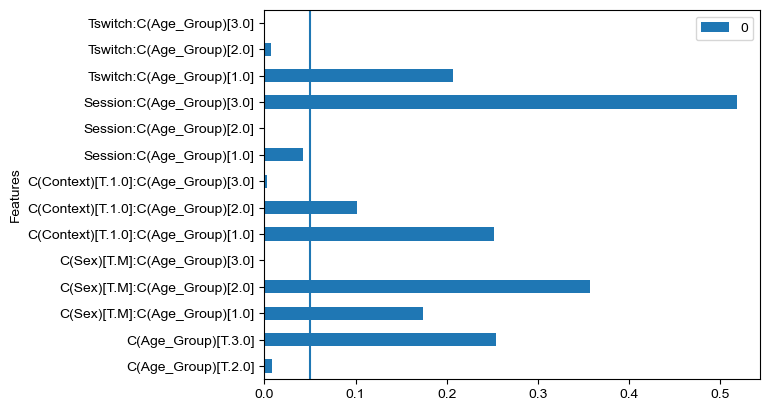

<Figure size 200x1000 with 0 Axes>

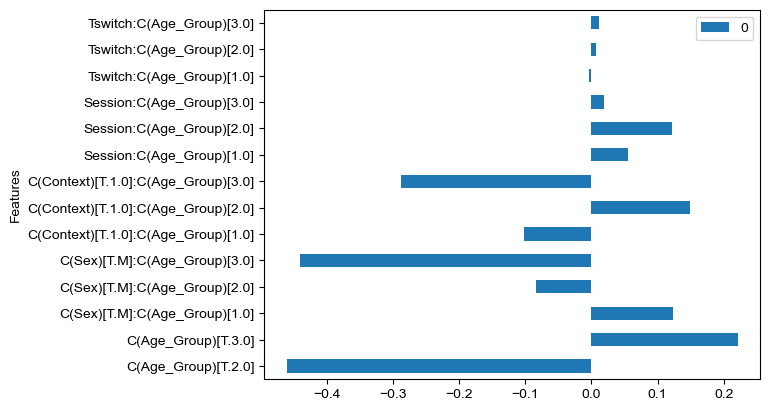

In [133]:
'''Model Probability of a Context:Aligned Block Trial using Front Track Activity'''

import statsmodels.api as sm
from patsy import dmatrices

#gather fixed effects into lists & then into dataframe
Animal_ID = list(allmice)
Session = list(allsesh)
Sex = list(allsex)
Age_Group = list(allage)
Trial_ID = list(alltrialid)
Cohort = list(allcohort)
K = list(allk)

Req = list(allreq)
Aligned = list(allaligned)
Context = list(allcontext)
Tswitch = list(alltswitch)
Switch = list(allswitch)

tuples = list(zip(Animal_ID, Session, Sex, Age_Group, Trial_ID, Cohort, K, Req, Aligned, Context, Tswitch, Switch))
tuples

df = pd.DataFrame(tuples, columns = ['Animal_ID', 'Session', 'Sex', 'Age_Group', 'Trial_ID', 'Cohort', 'K','Req', 'Aligned', 'Context', 'Tswitch', 'Switch'])
df = df.dropna(axis = 0)

# model probability of a correct response
y,X = dmatrices('Aligned ~ 1 + C(Age_Group) + C(Sex):C(Age_Group) + Session:C(Age_Group) + C(Context):C(Age_Group) + Tswitch:C(Age_Group)', data = df, return_type = 'dataframe')
#y,X = dmatrices('Aligned ~ 1 + C(Age_Group) + C(Sex):C(Age_Group) + C(Remap) + C(Remap):C(Age_Group) + Session:C(Age_Group) + C(Context):C(Age_Group) + Switch:C(Age_Group)', data = df, return_type = 'dataframe')
maligned = sm.Logit(y,X).fit()
print(maligned.summary())

#plot fitted values
pvalues = pd.concat([maligned.pvalues[1:].T.to_frame()], 
                   ignore_index=False)
pvalues.index.name = 'Features'
pvalues.reset_index()

params = pd.concat([maligned.params[1:].T.to_frame()], 
                   ignore_index=False)
params.index.name = 'Features'
params.reset_index()

results = pd.merge(params, pvalues, how = "left", on = "Features",suffixes=("params","pvalues")).fillna(0).reset_index()
results = results.rename(columns={'0params': 'Params', "0pvalues":'Pvalues'})

plt.figure(figsize=(2,10))
pvalues.plot.barh()
plt.axvline(x = 0.05)
plt.show()

plt.figure(figsize=(2,10))
params.plot.barh()
plt.show()

final = results.loc[(results['Pvalues'] < 0.05)].reset_index(drop=True)
final['Odds'] = np.exp(final['Params'])
final['Percent'] = (final['Odds'] - 1)*100
final.sort_values(by=['Odds'], ascending = False).reset_index(drop=True)

#plot fitted values
hue_order = [1.0, 3.0, 2.0]
df['predicted'] = maligned.predict(X)
new_palette =  sns.color_palette(n_colors = 3)
new_palette[1], new_palette[2] = new_palette[2], new_palette[1]

In [134]:
''' Table of All Predictors '''

results

,Features,Params,Pvalues
0,C(Age_Group)[T.2.0],-0.461010,0.008237
1,C(Age_Group)[T.3.0],0.221624,0.253928
2,C(Sex)[T.M]:C(Age_Group)[1.0],0.123224,0.174085
3,C(Sex)[T.M]:C(Age_Group)[2.0],-0.083988,0.357339
4,C(Sex)[T.M]:C(Age_Group)[3.0],-0.441367,0.000031
5,C(Context)[T.1.0]:C(Age_Group)[1.0],-0.102077,0.251894
6,C(Context)[T.1.0]:C(Age_Group)[2.0],0.149350,0.101664
7,C(Context)[T.1.0]:C(Age_Group)[3.0],-0.288601,0.003390
8,Session:C(Age_Group)[1.0],0.055111,0.041904
9,Session:C(Age_Group)[2.0],0.121682,0.000002


In [135]:
''' Table of Final Predictors '''

final

,Features,Params,Pvalues,Odds,Percent
0,C(Age_Group)[T.2.0],-0.461010,0.008237,0.630647,-36.935338
1,C(Sex)[T.M]:C(Age_Group)[3.0],-0.441367,0.000031,0.643156,-35.684367
2,C(Context)[T.1.0]:C(Age_Group)[3.0],-0.288601,0.003390,0.749311,-25.068874
3,Session:C(Age_Group)[1.0],0.055111,0.041904,1.056658,5.665782
4,Session:C(Age_Group)[2.0],0.121682,0.000002,1.129395,12.939543
5,Tswitch:C(Age_Group)[2.0],0.007117,0.007469,1.007142,0.714232
6,Tswitch:C(Age_Group)[3.0],0.011228,0.000092,1.011292,1.129164



n aged, MA, young mice on day 1
5 8 6

n aged, MA, young mice on day 2
7 7 8

n aged, MA, young mice on day 3
8 8 8

n aged, MA, young mice on day 4
7 4 8

n aged, MA, young mice on day 5
8 8 8

n aged, MA, young mice on day 6
6 9 7


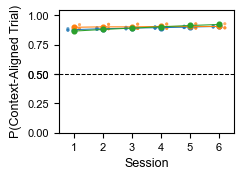

In [136]:
''' Plot Figure S5K (Left) for Block Trials w/ Front Track Activity'''
#GATHER RESULTS
results = df.groupby(by = ['Animal_ID','Session'], as_index = False)['predicted'].aggregate('mean')
seshanimal = np.asarray(results['Animal_ID'])
seshcount = np.asarray(results['Session'])
seshmean = np.asarray(results['predicted'])

r = 6
salignedprobfitted_seg_aged = [[] * r for i in range(r)]
salignedprobfitted_seg_MA = [[] * r for i in range(r)]
salignedprobfitted_seg_young = [[] * r for i in range(r)]

sessioncount_fitted_aged = [[] * r for i in range(r)]
sessioncount_fitted_MA = [[] * r for i in range(r)]
sessioncount_fitted_young = [[] * r for i in range(r)]

for m, session in zip(mice, sessions): 
    
    if m in seshanimal: 
        animalidx = np.where(seshanimal == m)[0][0]
        session_idx = np.where(seshanimal == m)[0]

        if m in SM_aged_mice:
            for i, c in enumerate(seshcount[session_idx]):
                idx = c.astype(int)
                salignedprobfitted_seg_aged[idx] = np.append(salignedprobfitted_seg_aged[idx], seshmean[session_idx][i])
                sessioncount_fitted_aged[idx] = np.append(sessioncount_fitted_aged[idx], c)
        elif m in SM_MA_mice:
            for i, c in enumerate(seshcount[session_idx]):
                idx = c.astype(int)
                salignedprobfitted_seg_MA[idx] = np.append(salignedprobfitted_seg_MA[idx], seshmean[session_idx][i])
                sessioncount_fitted_MA[idx] = np.append(sessioncount_fitted_MA[idx], c)
        else:
            for i, c in enumerate(seshcount[session_idx]):
                idx = c.astype(int)
                salignedprobfitted_seg_young[idx] = np.append(salignedprobfitted_seg_young[idx], seshmean[session_idx][i])
                sessioncount_fitted_young[idx] = np.append(sessioncount_fitted_young[idx], c)
    else:
        #print(m, session)
        pass   
    
## PLOT
fig, ax = plt.subplots(figsize = (2.25,1.60))

#scatter plot actual raw data:
for i in range(0,len(salignedprobfitted_seg_aged)):
    print('\nn aged, MA, young mice on day ' + str(i + 1))
    print(len(sessioncount_fitted_aged[i]),len(sessioncount_fitted_MA[i]), len(sessioncount_fitted_young[i]))
    ax.scatter(sessioncount_fitted_aged[i] + 0.2, salignedprobfitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax.scatter(sessioncount_fitted_MA[i], salignedprobfitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax.scatter(sessioncount_fitted_young[i] - 0.2, salignedprobfitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

g =  sns.pointplot(x = df['Session'], y = maligned.predict(X), hue = df['Age_Group'], hue_order = hue_order, scale = 0.5)
ax.set_ylabel('P(Context-Aligned Trial)', fontsize = 9)
ax.set_xlabel('Session', fontsize = 9)
ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels(labels = [1,2,3,4,5,6])
ax.set_xlim([-0.5,5.5])
ax.set_yticks([0,0.25,0.5,0.5,0.75,1])
ax.set_ylim([0,1.05])
ax.tick_params(labelsize = 8)
ax.hlines(y = 0.5,xmin = -0.5, xmax = 5.5, linestyle = '--', lw = 0.75, color = 'k')
#plt.legend(bbox_to_anchor = (1.02,1), fontsize = 9)
g.legend_.remove()
for l in g.lines:
    plt.setp(l,linewidth = 0.75)
fig.savefig(save_folder + 'ReviewerFigure2Cleft.png', dpi = 400, bbox_inches='tight')
fig.savefig(save_folder + 'ReviewerFigure2Clef.svg', dpi = 400, bbox_inches='tight')
plt.show()


n aged, MA, young mice on trials from switch 0
9 10 9

n aged, MA, young mice on trials from switch 1
9 10 9

n aged, MA, young mice on trials from switch 2
9 10 9

n aged, MA, young mice on trials from switch 3
9 10 9

n aged, MA, young mice on trials from switch 4
9 10 9

n aged, MA, young mice on trials from switch 5
9 10 9

n aged, MA, young mice on trials from switch 6
9 10 9

n aged, MA, young mice on trials from switch 7
9 10 9


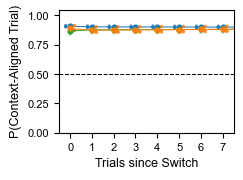

In [137]:
''' Check Figure 3C (right) for Block Trials Front Track Activity'''

## COLLECT RESULTS
results = df.groupby(by = ['Animal_ID','Tswitch'], as_index = False)['predicted'].aggregate('mean')
seshanimal = np.asarray(results['Animal_ID'])
seshcount = np.asarray(results['Tswitch'])
seshmean = np.asarray(results['predicted'])

r = 8
salignedprobfitted_seg_aged = [[] * r for i in range(r)]
salignedprobfitted_seg_MA = [[] * r for i in range(r)]
salignedprobfitted_seg_young = [[] * r for i in range(r)]

sessioncount_fitted_aged = [[] * r for i in range(r)]
sessioncount_fitted_MA = [[] * r for i in range(r)]
sessioncount_fitted_young = [[] * r for i in range(r)]

for m, session in zip(mice, sessions): 
    
    if m in seshanimal: 
        animalidx = np.where(seshanimal == m)[0][0]
        max_tswitch = len(np.where(seshanimal == m)[0])
        if max_tswitch <= 8:
            session_idx = np.arange(animalidx, max_tswitch + animalidx)
        else:
            session_idx = np.arange(animalidx, 8 + animalidx)

        if m in SM_aged_mice:
            for i, c in enumerate(seshcount[session_idx]):
                idx = c.astype(int)
                salignedprobfitted_seg_aged[idx] = np.append(salignedprobfitted_seg_aged[idx], seshmean[session_idx][i])
                sessioncount_fitted_aged[idx] = np.append(sessioncount_fitted_aged[idx], c)
        elif m in SM_MA_mice:
            for i, c in enumerate(seshcount[session_idx]):
                idx = c.astype(int)
                salignedprobfitted_seg_MA[idx] = np.append(salignedprobfitted_seg_MA[idx], seshmean[session_idx][i])
                sessioncount_fitted_MA[idx] = np.append(sessioncount_fitted_MA[idx], c)
        else:
            for i, c in enumerate(seshcount[session_idx]):
                idx = c.astype(int)
                salignedprobfitted_seg_young[idx] = np.append(salignedprobfitted_seg_young[idx], seshmean[session_idx][i])
                sessioncount_fitted_young[idx] = np.append(sessioncount_fitted_young[idx], c)
    else:
        pass

## PLOT
fig, ax = plt.subplots(figsize = (2.25,1.60))
g = sns.pointplot(data = df, x = 'Tswitch', y = 'predicted', ax = ax, hue = 'Age_Group', palette = new_palette, scale = 0.5)
ax.set_ylabel('P(Context-Aligned Trial)', fontsize = 9)
ax.set_xlabel('Trials since Switch', fontsize = 9)
ax.set_xlim([-0.5,7.5])
#ax.set_title('Age x Aligned Trial', fontsize = 10)
ax.set_xticks([0,1,2,3,4,5,6,7])
ax.set_yticks([0,0.25,0.5,0.75,1.0])
ax.set_ylim([0,1.05])
ax.set_xticklabels([0,1,2,3,4,5,6,7])
ax.tick_params(labelsize = 8)
ax.hlines(y = 0.5,xmin = -0.5, xmax = 7.5, linestyle = '--', lw = 0.75, color = 'k')
#plt.legend(bbox_to_anchor = (1.02,1), fontsize = 9)
g.legend_.remove()
for l in g.lines:
    plt.setp(l,linewidth = 0.75)

#scatter plot actual raw data:
for i in range(0,len(salignedprobfitted_seg_aged)):
    print('\nn aged, MA, young mice on trials from switch ' + str(i))
    print(len(sessioncount_fitted_aged[i]),len(sessioncount_fitted_MA[i]), len(sessioncount_fitted_young[i]))
    ax.scatter(sessioncount_fitted_aged[i] + 0.2, salignedprobfitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax.scatter(sessioncount_fitted_MA[i], salignedprobfitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax.scatter(sessioncount_fitted_young[i] - 0.2, salignedprobfitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

fig.savefig(save_folder + 'ReviewerFigure2Cright.png', dpi = 400, bbox_inches='tight')
fig.savefig(save_folder + 'ReviewerFigure2Cright.svg', dpi = 400, bbox_inches='tight')
plt.show()

# Reviewer Figure 2 Analysis Summary

In this analysis, we compared remapping and context representation by the front track grid network activity across age groups. These results are reported above (Reviewer Figure 2). Reviewer Figure 2D was also added to the revised manuscript (Figure S5K). Here, we examined the relationship between VR context and spatial map identity, determined by k-means clustering front track grid network activity across trials (Reviewer Figure 2A, top vs. right axes). This recapitulated key results, including increased remapping frequency with age (Reviewer Figure 2B vs. Figure 3B) and the general relationship between task performance and context-aligned spatial maps (Reviewer Figure 2E vs. Figure 3E). Moreover, consistent with back track results (Figure 3C), all age groups showed similarly high map-context alignment on block trials (Reviewer Figure 2C), well above the chance level of VR context and spatial map identity alignment for a given trial of 50%. Contrasting back track results (Figure 3D), front track alignment probability on alternation trials remained below chance for all age groups across sessions (Reviewer Figure 2D, also Figure S5K). This suggests that back track visual cues generally drive map-context alignment and context discrimination in alternation. Notably, front track alignment probability on alternation trials only improved over sessions in young mice, whereas back track alternation alignment probability improved over sessions for both young and MA mice. Taken together with Figure S5J, this provides some evidence that the cue tower may modestly support alternation context discrimination by only young mice as they learn the association between its location and back track cues over sessions. 

# Compare heterogeneity of grid network spatial information in context-matched task epochs across age groups (Figure S5G-H).

Here, we use a circular position decoder to compare accuracy of position decoding score when trained/tested on grid network activity from different pairs of Split Maze task epochs (e.g. Train on Block A and Test on Block A vs. Block B). If remapping is occuring between epochs, grid network spatial information should heterogenous across epochs, resulting in better decoder performance when trained / tested on the same epoch vs. a different one. Similarly, decoders trained/tested on context-matched epochs should outperform those trained/tested on context-mismatched epochs if grid network spatial information is more homogenous across context-matched epochs. The goal of this analysis was to verify these expectations about grid network information content across Split Maze task epochs. 

In [34]:
''' DECODER ANALYSIS '''
import scipy.stats 
from scipy.ndimage import gaussian_filter1d
normcdf = scipy.stats.norm.cdf
normpdf = scipy.stats.norm.pdf

SMOOTHNESS = 10.0
REGULARIZATION = 1e-4

## REGRESSION MODEL ##

from scipy.linalg import cho_factor, cho_solve
from sklearn.base import BaseEstimator

class CircularRegression(BaseEstimator):
    
    def __init__(self, alpha=0.0, tol=1e-5, max_iter=100):
        self.alpha = alpha
        self.tol = tol
        self.max_iter = max_iter
    
    def fit(self, X, y):
        """
        Parameters
        ----------
        X : array
            Independent variables, has shape (n_timepoints x n_neurons)
        y : array
            Circular dependent variable, has shape (n_timepoints x 1),
            all data should lie on the interval [-pi, +pi].
        """
        
        # Convert 1d circular variable to 2d representation
        u = np.column_stack([np.sin(y), np.cos(y)])

        # Randomly initialize weights. Ensure scaling does
        W = np.random.randn(X.shape[1], 2)
        W /= np.max(np.sum(np.abs(X @ W), axis=1))
        
        # Cache neuron x neuron gram matrix. This is used below
        # in the M-step to solve a linear least squares problem
        # in the form inv(XtX) @ XtY. Add regularization term to
        # the diagonal.
        XtX = X.T @ X
        XtX[np.diag_indices_from(XtX)] += self.alpha
        XtX = cho_factor(XtX)

        # Compute model prediction in 2d space, and projection onto
        # each observed u.
        XW = (X @ W)
        t = np.sum(u * XW, axis=1)
        tcdf = normcdf(t)
        tpdf = normpdf(t)

        self.log_like_hist_ = [
            np.log(2 * np.pi) - 
            0.5 * np.mean(np.sum(XW * XW, axis=1), axis=0) +
            np.mean(np.log(1 + t * tcdf / tpdf))
        ]

        for itr in range(self.max_iter):

            # E-step.
            m = t + (tcdf / ((tpdf + t * tcdf)))
            XtY = X.T @ (m[:, None] * u)

            # M-step.
            W = cho_solve(XtX, XtY)
            
            # Recompute model prediction.
            XW = X @ W
            t = np.sum(u * XW, axis=1)
            tcdf = normcdf(t)
            tpdf = normpdf(t)

            # Store log-likelihood.
            self.log_like_hist_.append(
                np.log(2 * np.pi) - 
                0.5 * np.mean(np.sum(XW * XW, axis=1), axis=0) +
                np.mean(np.log(1 + t * tcdf / tpdf))
            )
            
            # Check convergence.
            if (self.log_like_hist_[-1] - self.log_like_hist_[-2]) < self.tol:
                break
    
        self.weights_ = W
    
    def predict(self, X):
        u_pred = X @ self.weights_
        return np.arctan2(u_pred[:, 0], u_pred[:, 1])

    def score(self, X, y):
        """
        Returns 1 minus mean angular similarity between y and model prediction.
        
        score == 1 for perfect prediction
        score == 0 in expectation for random prediction
        score == -1 if prediction is off by 180 degrees.
        """
        y_pred = self.predict(X)
        return np.mean(np.cos(y - y_pred))

In [35]:
'''Define Function to Split Train & Test Blocks'''
def train_vs_test_blocks(X, y, train_data_idx, test_data_idx, n_repeats=10, train_pct=0.9):
    test_scores = []    
    test_folds = np.array_split(test_data_idx, n_repeats)

    for i in range(n_repeats):        
        # Get train and test indices
        test_idx = test_folds[i]
        train_idx = np.random.choice(np.setdiff1d(train_data_idx, test_idx),
                                     replace=False, size=int(train_data_idx.size * train_pct))

        # Train model
        model.fit(X[train_idx], y[train_idx])

        # Compute test error
        test_scores.append(model.score(X[test_idx], y[test_idx]))
        
    return np.asarray(test_scores)

In [36]:
''' Get X (instantaneous FR of grid cells) and y (circular position)'''

dt = 0.02
track_len = 400

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]

        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-errorcorrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]
        
        if len(gridcells) >= 10:
            # convert spikes to instantaneous FR and smooth, then select only the grid cell data
            X = Y / dt # convert spike count to FR
            X = gaussian_filter1d(X, SMOOTHNESS, axis=0)

            sdx = []
            for i, c in enumerate(gridcells):
                sd = (np.where(cell_IDs == c)[0][0]).astype(int)
                sdx.append(sd)

            X = X[:,sdx]

            # format position s.t. 0 = -pi = +pi = 400
            y_raw = behaviorfil[:, 0]
            y = (y_raw / np.max(y_raw)) * 2 * np.pi - np.pi

            d['X'] = X
            d['y'] = y

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [114]:
''' Find & save binary map indices corresponding to quarters of the task sorted by context, making sure skipped trials are excluded''' 

for m, session in zip(mice,sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)        
        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        
        #find context A / B trials in alternation, removing skipped trials
        trialinfo = raw.item().get('trialinfo')
        left = trialinfo['left']
               
        A_trials = np.where((left == 1))[0]
        Atrials = list(A_trials[(A_trials >= 20) & (A_trials < 140)])
        A_trials = list(A_trials[A_trials >= 140])
        B_trials = np.where((left == 0))[0]
        Btrials = list(B_trials[(B_trials >= 20) & (B_trials < 140)])
        B_trials = list(B_trials[B_trials >= 140])
    
        # Find skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            skippedtrials = get.find_skipped(trial, max_trial_num = 220)
        except:
            skippedtrials = []
            
        for n, t in enumerate(skippedtrials):
            if t in A_trials:
                A_trials.remove(t)
            elif t in B_trials:
                B_trials.remove(t)
            elif t in Atrials:
                Atrials.remove(t)
            elif t in Btrials: 
                Btrials.remove(t)
            else:
                pass
    
        Aidx = np.zeros_like(trial)
        Bidx = np.zeros_like(trial)
        A_idx = np.zeros_like(trial)
        B_idx = np.zeros_like(trial)
        
        for t in Atrials:
            Aidx[trial == t] = 1 
        
        for t in Btrials:
            Bidx[trial == t] = 1 
        
        for t in A_trials:
            A_idx[trial == t] = 1 
        
        for t in B_trials:
            B_idx[trial == t] = 1 
        
        Aidx = Aidx.astype(int)
        Bidx = Bidx.astype(int)
        A_idx = A_idx.astype(int)
        B_idx = B_idx.astype(int)
            
        #save indices for session section
        d['Aidx'] = Aidx
        d['Bidx'] = Bidx
        d['A_idx'] = A_idx
        d['B_idx'] = B_idx
                
        # get non-gain change A' and B' indices 
        gain = trialinfo['gain']
        
        #check if mouse reached gain period; if not append NaN to all arrays & continue 
        if len(gain) < 200:
            print(str(m) + str(s) + ' did not reach gain change')
            
            d['A_ngidx'] = A_idx
            d['B_ngidx'] = B_idx
            
            continue 
            
        #get count of gain in each context & select equal number of last Context A or B alt trials before gain
        gain_trials = np.where((gain == 0.7))[0]
        gain_trials = list(gain_trials)

        Agtrials = np.intersect1d(A_trials, np.asarray(gain_trials))
        Agtrials = list(np.sort(Agtrials.astype(int)))
        Bgtrials = np.intersect1d(B_trials, np.asarray(gain_trials))                   
        Bgtrials = list(np.sort(Bgtrials.astype(int)))
    
        #reset indices of gain change trials to 0
        A_ngidx = A_idx
        B_ngidx = B_idx
        
        for t in Agtrials:
            A_ngidx[trial == t] = 0 
            
        for t in Bgtrials:
            B_ngidx[trial == t] = 0 
        
        A_ngidx = A_ngidx.astype(int)
        B_ngidx = B_ngidx.astype(int)
        
        d['A_ngidx'] = A_ngidx
        d['B_ngidx'] = B_ngidx
        
        #check if capturing indices correctly
        #print(len(trial[(trial >= 20) & (trial < 200)]))
        #print(np.sum(Aidx) + np.sum(Bidx) + np.sum(A_ngidx) + np.sum(B_ngidx))
        

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

A20013123_record6 did not reach gain change


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [39]:
''' Downsample to Match Speed and Num Observations (A vs A')'''
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]
        
        if len(gridcells) >= 10:
            speed = behaviorfil[:, 1]
            y = d['y']
            map0_idx = d['Aidx']
            map1_idx = d['A_ngidx']

            # bin speed into 10cm/s bins
            edges = np.arange(10, np.max(speed), 10)
            speed_idx = np.digitize(speed, edges)

            # get indices for each map's observations
            obs_0 = np.arange(y.shape[0])[map0_idx]
            obs_1 = np.arange(y.shape[0])[map1_idx]

            # array to hold indices for downsampling
            ds_0 = np.asarray([]) # array to hold indices for downsampling map 0
            ds_1 = np.asarray([]) # array to hold indices for downsampling map 1

            # match occupancy of each bin for each map
            bins, ct = np.unique(speed_idx, return_counts=True)
            for b in bins:
                occupancy_0 = np.sum(map0_idx[speed_idx == b])
                occupancy_1 = np.sum(map1_idx[speed_idx == b])  
                idx_0 = np.where(map0_idx & (speed_idx == b))[0]
                idx_1 = np.where(map1_idx & (speed_idx == b))[0]

                if occupancy_0 > occupancy_1:
                    # need to downsample map 0 for this speed bin
                    n_timepts = occupancy_1        
                    ds_0 = np.append(ds_0, np.random.choice(idx_0, n_timepts, replace=False))
                    ds_1 = np.append(ds_1, idx_1)
                else:
                    # need to downsample map 1 for this speed bin
                    n_timepts = occupancy_0
                    ds_0 = np.append(ds_0, idx_0)
                    ds_1 = np.append(ds_1, np.random.choice(idx_1, n_timepts, replace=False)) 
            ds_0 = ds_0.astype(int)
            ds_1 = ds_1.astype(int)

            d['ds_idx'] = np.row_stack((ds_0, ds_1))

In [40]:
''' Fit model on each map0 = Context A, map1 = Context A_'''

model = CircularRegression(alpha=REGULARIZATION)

# cross-validate the model
for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]
        
        if len(gridcells) >= 10:
            X = d['X']
            y = d['y']

            # randomly split all trials into training vs. test sets & identify their indices
            ds_0 = d['ds_idx'][0, :]
            ds_1 = d['ds_idx'][1, :]

            # get CV scores for each train and test combo - save these!
            train0_test0_scores = train_vs_test_blocks(X, y, ds_0, ds_0)
            train0_test1_scores = train_vs_test_blocks(X, y, ds_0, ds_1)
            train1_test1_scores = train_vs_test_blocks(X, y, ds_1, ds_1)
            train1_test0_scores = train_vs_test_blocks(X, y, ds_1, ds_0)
            d['AA_scores'] = np.row_stack((train0_test0_scores, train0_test1_scores, 
                                        train1_test1_scores, train1_test0_scores))
           
            AA_scores_file = 'AA_scores_decoder_' + m + '_' + s + '.npy'
            np.save(save_folder + AA_scores_file, d['AA_scores'])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [41]:
''' Downsample to Match Speed and Num Observations (B vs B')'''
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]
        
        if len(gridcells) >= 10:
            speed = behaviorfil[:, 1]
            y = d['y']
            map0_idx = d['Bidx']
            map1_idx = d['B_ngidx']

            # bin speed into 10cm/s bins
            edges = np.arange(10, np.max(speed), 10)
            speed_idx = np.digitize(speed, edges)

            # get indices for each map's observations
            obs_0 = np.arange(y.shape[0])[map0_idx]
            obs_1 = np.arange(y.shape[0])[map1_idx]

            # array to hold indices for downsampling
            ds_0 = np.asarray([]) # array to hold indices for downsampling map 0
            ds_1 = np.asarray([]) # array to hold indices for downsampling map 1

            # match occupancy of each bin for each map
            bins, ct = np.unique(speed_idx, return_counts=True)
            for b in bins:
                occupancy_0 = np.sum(map0_idx[speed_idx == b])
                occupancy_1 = np.sum(map1_idx[speed_idx == b])  
                idx_0 = np.where(map0_idx & (speed_idx == b))[0]
                idx_1 = np.where(map1_idx & (speed_idx == b))[0]

                if occupancy_0 > occupancy_1:
                    # need to downsample map 0 for this speed bin
                    n_timepts = occupancy_1        
                    ds_0 = np.append(ds_0, np.random.choice(idx_0, n_timepts, replace=False))
                    ds_1 = np.append(ds_1, idx_1)
                else:
                    # need to downsample map 1 for this speed bin
                    n_timepts = occupancy_0
                    ds_0 = np.append(ds_0, idx_0)
                    ds_1 = np.append(ds_1, np.random.choice(idx_1, n_timepts, replace=False)) 
            ds_0 = ds_0.astype(int)
            ds_1 = ds_1.astype(int)

            d['ds_idx'] = np.row_stack((ds_0, ds_1))

In [42]:
''' Fit model on each map0 = Context B, map1 = Context B_'''

model = CircularRegression(alpha=REGULARIZATION)

# cross-validate the model
for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]
        
        if len(gridcells) >= 10:
            X = d['X']
            y = d['y']

            # randomly split all trials into training vs. test sets & identify their indices
            ds_0 = d['ds_idx'][0, :]
            ds_1 = d['ds_idx'][1, :]

            # get CV scores for each train and test combo - save these!
            train0_test0_scores = train_vs_test_blocks(X, y, ds_0, ds_0)
            train0_test1_scores = train_vs_test_blocks(X, y, ds_0, ds_1)
            train1_test1_scores = train_vs_test_blocks(X, y, ds_1, ds_1)
            train1_test0_scores = train_vs_test_blocks(X, y, ds_1, ds_0)
            d['BB_scores'] = np.row_stack((train0_test0_scores, train0_test1_scores, 
                                        train1_test1_scores, train1_test0_scores))
            BB_scores_file = 'BB_scores_decoder_' + m + '_' + s + '.npy'
            np.save(save_folder + BB_scores_file, d['BB_scores'])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [43]:
''' Downsample to Match Speed and Num Observations (A vs B)'''
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]
        
        if len(gridcells) >= 10:
            speed = behaviorfil[:, 1]
            y = d['y']
            map0_idx = d['Aidx']
            map1_idx = d['Bidx']

            # bin speed into 10cm/s bins
            edges = np.arange(10, np.max(speed), 10)
            speed_idx = np.digitize(speed, edges)

            # get indices for each map's observations
            obs_0 = np.arange(y.shape[0])[map0_idx]
            obs_1 = np.arange(y.shape[0])[map1_idx]

            # array to hold indices for downsampling
            ds_0 = np.asarray([]) # array to hold indices for downsampling map 0
            ds_1 = np.asarray([]) # array to hold indices for downsampling map 1

            # match occupancy of each bin for each map
            bins, ct = np.unique(speed_idx, return_counts=True)
            for b in bins:
                occupancy_0 = np.sum(map0_idx[speed_idx == b])
                occupancy_1 = np.sum(map1_idx[speed_idx == b])  
                idx_0 = np.where(map0_idx & (speed_idx == b))[0]
                idx_1 = np.where(map1_idx & (speed_idx == b))[0]

                if occupancy_0 > occupancy_1:
                    # need to downsample map 0 for this speed bin
                    n_timepts = occupancy_1        
                    ds_0 = np.append(ds_0, np.random.choice(idx_0, n_timepts, replace=False))
                    ds_1 = np.append(ds_1, idx_1)
                else:
                    # need to downsample map 1 for this speed bin
                    n_timepts = occupancy_0
                    ds_0 = np.append(ds_0, idx_0)
                    ds_1 = np.append(ds_1, np.random.choice(idx_1, n_timepts, replace=False)) 
            ds_0 = ds_0.astype(int)
            ds_1 = ds_1.astype(int)

            d['ds_idx'] = np.row_stack((ds_0, ds_1))

In [44]:
''' Fit model on each map0 = Context A, map1 = Context B'''

model = CircularRegression(alpha=REGULARIZATION)

# cross-validate the model
for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]
        
        if len(gridcells) >= 10:
            X = d['X']
            y = d['y']

            # randomly split all trials into training vs. test sets & identify their indices
            ds_0 = d['ds_idx'][0, :]
            ds_1 = d['ds_idx'][1, :]

            # get CV scores for each train and test combo - save these!
            train0_test0_scores = train_vs_test_blocks(X, y, ds_0, ds_0)
            train0_test1_scores = train_vs_test_blocks(X, y, ds_0, ds_1)
            train1_test1_scores = train_vs_test_blocks(X, y, ds_1, ds_1)
            train1_test0_scores = train_vs_test_blocks(X, y, ds_1, ds_0)
            d['ABscores'] = np.row_stack((train0_test0_scores, train0_test1_scores, 
                                        train1_test1_scores, train1_test0_scores))
            ABscores_file = 'ABscores_decoder_' + m + '_' + s + '.npy'
            np.save(save_folder + ABscores_file, d['ABscores'])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [45]:
''' Downsample to Match Speed and Num Observations (A_ vs B_)'''
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]
        
        if len(gridcells) >= 10:
            speed = behaviorfil[:, 1]
            y = d['y']
            map0_idx = d['A_ngidx']
            map1_idx = d['B_ngidx']

            # bin speed into 10cm/s bins
            edges = np.arange(10, np.max(speed), 10)
            speed_idx = np.digitize(speed, edges)

            # get indices for each map's observations
            obs_0 = np.arange(y.shape[0])[map0_idx]
            obs_1 = np.arange(y.shape[0])[map1_idx]

            # array to hold indices for downsampling
            ds_0 = np.asarray([]) # array to hold indices for downsampling map 0
            ds_1 = np.asarray([]) # array to hold indices for downsampling map 1

            # match occupancy of each bin for each map
            bins, ct = np.unique(speed_idx, return_counts=True)
            for b in bins:
                occupancy_0 = np.sum(map0_idx[speed_idx == b])
                occupancy_1 = np.sum(map1_idx[speed_idx == b])  
                idx_0 = np.where(map0_idx & (speed_idx == b))[0]
                idx_1 = np.where(map1_idx & (speed_idx == b))[0]

                if occupancy_0 > occupancy_1:
                    # need to downsample map 0 for this speed bin
                    n_timepts = occupancy_1        
                    ds_0 = np.append(ds_0, np.random.choice(idx_0, n_timepts, replace=False))
                    ds_1 = np.append(ds_1, idx_1)
                else:
                    # need to downsample map 1 for this speed bin
                    n_timepts = occupancy_0
                    ds_0 = np.append(ds_0, idx_0)
                    ds_1 = np.append(ds_1, np.random.choice(idx_1, n_timepts, replace=False)) 
            ds_0 = ds_0.astype(int)
            ds_1 = ds_1.astype(int)

            d['ds_idx'] = np.row_stack((ds_0, ds_1))

In [46]:
''' Fit model on each map0 = Context A_, map1 = Context B_'''

model = CircularRegression(alpha=REGULARIZATION)

# cross-validate the model
for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]
        
        if len(gridcells) >= 10:
            X = d['X']
            y = d['y']

            # randomly split all trials into training vs. test sets & identify their indices
            ds_0 = d['ds_idx'][0, :]
            ds_1 = d['ds_idx'][1, :]

            # get CV scores for each train and test combo - save these!
            train0_test0_scores = train_vs_test_blocks(X, y, ds_0, ds_0)
            train0_test1_scores = train_vs_test_blocks(X, y, ds_0, ds_1)
            train1_test1_scores = train_vs_test_blocks(X, y, ds_1, ds_1)
            train1_test0_scores = train_vs_test_blocks(X, y, ds_1, ds_0)
            d['A_B_scores'] = np.row_stack((train0_test0_scores, train0_test1_scores, 
                                        train1_test1_scores, train1_test0_scores))
            A_B_scores_file = 'A_B_scores_decoder_' + m + '_' + s + '.npy'
            np.save(save_folder + A_B_scores_file, d['A_B_scores'])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [47]:
''' Downsample to Match Speed and Num Observations (B vs A')'''
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]
        
        if len(gridcells) >= 10:
            speed = behaviorfil[:, 1]
            y = d['y']
            map0_idx = d['Bidx']
            map1_idx = d['A_ngidx']

            # bin speed into 10cm/s bins
            edges = np.arange(10, np.max(speed), 10)
            speed_idx = np.digitize(speed, edges)

            # get indices for each map's observations
            obs_0 = np.arange(y.shape[0])[map0_idx]
            obs_1 = np.arange(y.shape[0])[map1_idx]

            # array to hold indices for downsampling
            ds_0 = np.asarray([]) # array to hold indices for downsampling map 0
            ds_1 = np.asarray([]) # array to hold indices for downsampling map 1

            # match occupancy of each bin for each map
            bins, ct = np.unique(speed_idx, return_counts=True)
            for b in bins:
                occupancy_0 = np.sum(map0_idx[speed_idx == b])
                occupancy_1 = np.sum(map1_idx[speed_idx == b])  
                idx_0 = np.where(map0_idx & (speed_idx == b))[0]
                idx_1 = np.where(map1_idx & (speed_idx == b))[0]

                if occupancy_0 > occupancy_1:
                    # need to downsample map 0 for this speed bin
                    n_timepts = occupancy_1        
                    ds_0 = np.append(ds_0, np.random.choice(idx_0, n_timepts, replace=False))
                    ds_1 = np.append(ds_1, idx_1)
                else:
                    # need to downsample map 1 for this speed bin
                    n_timepts = occupancy_0
                    ds_0 = np.append(ds_0, idx_0)
                    ds_1 = np.append(ds_1, np.random.choice(idx_1, n_timepts, replace=False)) 
            ds_0 = ds_0.astype(int)
            ds_1 = ds_1.astype(int)

            d['ds_idx'] = np.row_stack((ds_0, ds_1))

In [48]:
''' Fit model on each map0 = Context B, map1 = Context A_'''

model = CircularRegression(alpha=REGULARIZATION)

# cross-validate the model
for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]
        
        if len(gridcells) >= 10:
            X = d['X']
            y = d['y']

            # randomly split all trials into training vs. test sets & identify their indices
            ds_0 = d['ds_idx'][0, :]
            ds_1 = d['ds_idx'][1, :]

            # get CV scores for each train and test combo - save these!
            train0_test0_scores = train_vs_test_blocks(X, y, ds_0, ds_0)
            train0_test1_scores = train_vs_test_blocks(X, y, ds_0, ds_1)
            train1_test1_scores = train_vs_test_blocks(X, y, ds_1, ds_1)
            train1_test0_scores = train_vs_test_blocks(X, y, ds_1, ds_0)
            d['BA_scores'] = np.row_stack((train0_test0_scores, train0_test1_scores, 
                                        train1_test1_scores, train1_test0_scores))
            BA_scores_file = 'BA_scores_decoder_' + m + '_' + s + '.npy'
            np.save(save_folder + BA_scores_file, d['BA_scores'])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [49]:
''' Downsample to Match Speed and Num Observations (A vs B')'''
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]
        
        if len(gridcells) >= 10:
            speed = behaviorfil[:, 1]
            y = d['y']
            map0_idx = d['Aidx']
            map1_idx = d['B_ngidx']

            # bin speed into 10cm/s bins
            edges = np.arange(10, np.max(speed), 10)
            speed_idx = np.digitize(speed, edges)

            # get indices for each map's observations
            obs_0 = np.arange(y.shape[0])[map0_idx]
            obs_1 = np.arange(y.shape[0])[map1_idx]

            # array to hold indices for downsampling
            ds_0 = np.asarray([]) # array to hold indices for downsampling map 0
            ds_1 = np.asarray([]) # array to hold indices for downsampling map 1

            # match occupancy of each bin for each map
            bins, ct = np.unique(speed_idx, return_counts=True)
            for b in bins:
                occupancy_0 = np.sum(map0_idx[speed_idx == b])
                occupancy_1 = np.sum(map1_idx[speed_idx == b])  
                idx_0 = np.where(map0_idx & (speed_idx == b))[0]
                idx_1 = np.where(map1_idx & (speed_idx == b))[0]

                if occupancy_0 > occupancy_1:
                    # need to downsample map 0 for this speed bin
                    n_timepts = occupancy_1        
                    ds_0 = np.append(ds_0, np.random.choice(idx_0, n_timepts, replace=False))
                    ds_1 = np.append(ds_1, idx_1)
                else:
                    # need to downsample map 1 for this speed bin
                    n_timepts = occupancy_0
                    ds_0 = np.append(ds_0, idx_0)
                    ds_1 = np.append(ds_1, np.random.choice(idx_1, n_timepts, replace=False)) 
            ds_0 = ds_0.astype(int)
            ds_1 = ds_1.astype(int)

            d['ds_idx'] = np.row_stack((ds_0, ds_1))

In [50]:
''' Fit model on each map0 = Context A, map1 = Context B_'''

model = CircularRegression(alpha=REGULARIZATION)

# cross-validate the model
for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]
        
        if len(gridcells) >= 10:
            X = d['X']
            y = d['y']

            # randomly split all trials into training vs. test sets & identify their indices
            ds_0 = d['ds_idx'][0, :]
            ds_1 = d['ds_idx'][1, :]
            
            # get CV scores for each train and test combo - save these!
            train0_test0_scores = train_vs_test_blocks(X, y, ds_0, ds_0)
            train0_test1_scores = train_vs_test_blocks(X, y, ds_0, ds_1)
            train1_test1_scores = train_vs_test_blocks(X, y, ds_1, ds_1)
            train1_test0_scores = train_vs_test_blocks(X, y, ds_1, ds_0)
            d['AB_scores'] = np.row_stack((train0_test0_scores, train0_test1_scores, 
                                        train1_test1_scores, train1_test0_scores))
            AB_scores_file = 'AB_scores_decoder_' + m + '_' + s + '.npy'
            np.save(save_folder + AB_scores_file, d['AB_scores'])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [51]:
''' Collate Results from 6x Decoder Analyses Above '''

#get total number of sessions that meet criteria
count = 0
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]
        
        if len(gridcells) >= 10:
            count += 1

#train test same arrays
AA = np.zeros((3, count))
BB = np.zeros((3, count))
A_A_ = np.zeros((3, count))
B_B_ = np.zeros((3, count))

#train/test context-matched
AA_ = []
A_A = []
BB_ = []
B_B = []

#train/test context-mismatched
AB = []
BA = []
A_B_ = []
B_A_ = []
BA_ = []
A_B = []
AB_ = []
B_A = []

ysesh = []
masesh = []
agesesh = []

count = -1
for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]
        
        if len(gridcells) >= 10:
            
            #decoder run 1 A vs. A'
            AA_scores_file = 'AA_scores_decoder_' + m + '_' + s + '.npy'
            d['AA_scores'] = np.load(save_folder + AA_scores_file) 
            scores = d['AA_scores']

            AA[0,count] = np.mean(scores[0,:])
            A_A_[0, count] =  np.mean(scores[2,:])   
            AA_ = np.append(AA_, np.mean(scores[1,:]))       
            A_A = np.append(A_A, np.mean(scores[3,:]))
            
            #decoder run 2 B vs. B'
            BB_scores_file = 'BB_scores_decoder_' + m + '_' + s + '.npy'
            d['BB_scores'] = np.load(save_folder + BB_scores_file) 
            scores = d['BB_scores']

            BB[0,count] = np.mean(scores[0,:])
            B_B_[0, count] =  np.mean(scores[2,:])   
            BB_ = np.append(BB_, np.mean(scores[1,:]))       
            B_B = np.append(B_B, np.mean(scores[3,:]))
            
            #decoder run 3 A vs. B
            ABscores_file = 'ABscores_decoder_' + m + '_' + s + '.npy'
            d['ABscores'] = np.load(save_folder + ABscores_file)
            scores = d['ABscores']
            
            AA[1,count] = np.mean(scores[0,:])
            BB[1,count] = np.mean(scores[2,:]) 
            AB = np.append(AB, np.mean(scores[1,:]))       
            BA = np.append(BA, np.mean(scores[3,:]))
            
            #decoder run 4 A' x B'
            A_B_scores_file = 'A_B_scores_decoder_' + m + '_' + s + '.npy'
            d['A_B_scores'] = np.load(save_folder + A_B_scores_file)
            scores = d['A_B_scores']
            
            A_A_[1,count] = np.mean(scores[0,:])
            B_B_[1,count] = np.mean(scores[2,:]) 
            A_B_ = np.append(A_B_, np.mean(scores[1,:]))       
            B_A_ = np.append(B_A_, np.mean(scores[3,:]))
            
            #decoder run 5 B x A'
            BA_scores_file = 'BA_scores_decoder_' + m + '_' + s + '.npy'
            d['BA_scores'] = np.load(save_folder + BA_scores_file)
            scores = d['BA_scores']
            
            BB[2,count] = np.mean(scores[0,:])
            BA_ = np.append(BA_, np.mean(scores[1,:]))
            A_A_[2,count] = np.mean(scores[2,:])
            A_B = np.append(A_B, np.mean(scores[3,:]))
            
            #decoder run 6 A x B'
            AB_scores_file = 'AB_scores_decoder_' + m + '_' + s + '.npy'
            d['AB_scores'] = np.load(save_folder + AB_scores_file)
            scores = d['AB_scores'] 
                             
            AA[2,count] = np.mean(scores[0,:])
            AB_ = np.append(AB_, np.mean(scores[1,:]))
            B_B_[2,count] = np.mean(scores[2,:])
            B_A = np.append(B_A, np.mean(scores[3,:]))
              
            count += 1
            if m in SM_aged_mice:
                agesesh = np.append(agesesh, count)
            elif m in SM_MA_mice:
                masesh = np.append(masesh, count)
            else: 
                ysesh = np.append(ysesh, count)
                
ysesh = ysesh.astype(int)
masesh = masesh.astype(int)
agesesh = agesesh.astype(int)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

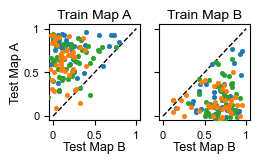

In [52]:
''' Plot Scatter of Decoder Scores Train/Test Same vs. Different Epoch (Split Maze Block Phase) (Figure S5G)'''

# plot performance same train/test vs. different train/test
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(2.6, 1.25), sharey = True) 
#f.suptitle('Decoder Performance by Train/Test Pairing & Age Group')

DOT_SIZE = 10
DOT_LW = 0.5
UNITY_WIDTH = 1
SEM_WIDTH = 0.8

avg_0to0 = np.mean(AA, axis = 0)
avg_0to1 = AB
avg_1to1 = np.mean(BB, axis = 0)
avg_1to0 = BA

# train on map 0, test on map 0 vs. test on map 1
ax0.scatter(avg_0to1[ysesh], avg_0to0[ysesh],
            facecolors='C0', edgecolors='C0', 
            s=DOT_SIZE, lw=DOT_LW, zorder=3, label = 'Young')   

ax0.scatter(avg_0to1[masesh], avg_0to0[masesh],
            facecolors='C2', edgecolors='C2', 
            s=DOT_SIZE, lw=DOT_LW, zorder=3, label = 'MA')   

ax0.scatter(avg_0to1[agesesh], avg_0to0[agesesh],
            facecolors='C1', edgecolors='C1', 
            s=DOT_SIZE, lw=DOT_LW, zorder=3, label = 'Aged')   

# train on map 1, test on map 1 vs. test on map 0
ax1.scatter(avg_1to1[ysesh], avg_1to0[ysesh],
            facecolors='C0', edgecolors='C0', 
            s=DOT_SIZE, lw=DOT_LW, zorder=3, label = 'Young')

ax1.scatter(avg_1to1[masesh], avg_1to0[masesh],
            facecolors='C2', edgecolors='C2', 
            s=DOT_SIZE, lw=DOT_LW, zorder=3, label = 'MA')  

ax1.scatter(avg_1to1[agesesh], avg_1to0[agesesh],
            facecolors='C1', edgecolors='C1', 
            s=DOT_SIZE, lw=DOT_LW, zorder=3, label = 'Aged')

# plot unity lines + shuffle/best lines
ax0.plot([0, 1], [0, 1], '--k', lw=UNITY_WIDTH, alpha=1)
ax1.plot([0, 1], [0, 1], '--k', lw=UNITY_WIDTH, alpha=1)

# label everything
ax0.set_title('Train Map A', fontsize=10, pad=4)
ax0.set_ylabel('Test Map A', fontsize=9, labelpad=1)
ax0.set_xlabel('Test Map B', fontsize=9, labelpad=1)
ax0.set_ylim([-0.05, 1.05])
ax0.set_xlim([-0.05, 1.05])
ax0.set_xticks([0, 0.5, 1])
ax0.set_xticklabels([0, 0.5, 1])
ax0.set_yticks([0, 0.5, 1])
ax0.set_yticklabels([0, 0.5, 1])

ax1.set_title('Train Map B', fontsize=10, pad=4)
#ax1.set_ylabel('Test Map 1', fontsize=9, labelpad=1)
ax1.set_xlabel('Test Map B', fontsize=9, labelpad=1)
ax1.set_ylim([-0.05, 1.05])
ax1.set_xlim([-0.05, 1.05])
ax1.set_xticks([0, 0.5, 1])
ax1.set_xticklabels([0, 0.5, 1])
ax1.set_yticks([0, 0.5, 1])
ax1.set_yticklabels([0, 0.5, 1])

ax0.tick_params(which='major', labelsize=8)
ax1.tick_params(which='major', labelsize=8)
#ax1.legend(fontsize = 8)
#ax0.legend(fontsize = 8)

f.savefig(save_folder + 'S5G.png', dpi=400, bbox_inches='tight')
f.savefig(save_folder + 'S5G.svg', dpi=400, bbox_inches='tight')
plt.show()

In [53]:
'''Statistical Comparison of Decoder Scores Train/Test Same vs. Different by Age Group & Together'''
allsind = np.concatenate((ysesh, masesh, agesesh))

# train/test map 0 vs. map 1 on young mice
m0vsm1_stat, m0vsm1_p = stats.ranksums(avg_0to0[ysesh], avg_1to1[ysesh])
print('mean ± SEM train/test A: ' + str(np.mean(avg_0to0[ysesh])) + ', ' + str(stats.sem(avg_0to0[ysesh])))
print('mean ± SEM train/test B: ' + str(np.mean(avg_1to1[ysesh])) + ', ' + str(stats.sem(avg_1to1[ysesh])))
print('YOUNG train/test map A vs. map B: p = ' + str(m0vsm1_p))

# train/test map 0 vs. map 1 on MA mice
m0vsm1_stat, m0vsm1_p = stats.ranksums(avg_0to0[masesh], avg_1to1[masesh])
print('\nmean ± SEM train/test A: ' + str(np.mean(avg_0to0[masesh])) + ', ' + str(stats.sem(avg_0to0[masesh])))
print('mean ± SEM train/test B: ' + str(np.mean(avg_1to1[masesh])) + ', ' + str(stats.sem(avg_1to1[masesh])))
print('MA train/test map A vs. map B: p = ' + str(m0vsm1_p))

# train/test map 0 vs. map 1 on aged mice
m0vsm1_stat, m0vsm1_p = stats.ranksums(avg_0to0[agesesh], avg_1to1[agesesh])
print('\nmean ± SEM train/test A: ' + str(np.mean(avg_0to0[agesesh])) + ', ' + str(stats.sem(avg_0to0[agesesh])))
print('mean ± SEM train/test B: ' + str(np.mean(avg_1to1[agesesh])) + ', ' + str(stats.sem(avg_1to1[agesesh])))
print('AGED train/test map A vs. map B: p = ' + str(m0vsm1_p))

# train/test map 0 vs. map 1 on both age groups of mice
m0vsm1_stat, m0vsm1_p = stats.ranksums(avg_0to0[allsind], avg_1to1[allsind])
print('ALL train/test map A vs. map B: p = ' + str(m0vsm1_p))

# train/test same map vs. other map
same_to_same = np.append(avg_0to0[ysesh], avg_1to1[ysesh])
diff_to_diff = np.append(avg_0to1[ysesh], avg_1to0[ysesh])
sameVSdiff_stat, sameVSdiff_p = stats.wilcoxon(same_to_same, diff_to_diff, alternative = 'greater')
print('\nYOUNG train/test same vs. train/test different: p = ' + str(sameVSdiff_p))
print('mean ± SEM test same: ' + str(np.mean(same_to_same)) + ', ' + str(stats.sem(same_to_same)))
print('mean ± SEM test diff: ' + str(np.mean(diff_to_diff)) + ', ' + str(stats.sem(diff_to_diff)))
print('n = ' + str(same_to_same.shape[0]) + ' model pairs')

same_to_same = np.append(avg_0to0[masesh], avg_1to1[masesh])
diff_to_diff = np.append(avg_0to1[masesh], avg_1to0[masesh])
sameVSdiff_stat, sameVSdiff_p = stats.wilcoxon(same_to_same, diff_to_diff, alternative = 'greater')
print('\nMA train/test same vs. train/test different: p = ' + str(sameVSdiff_p))
print('mean ± SEM test same: ' + str(np.mean(same_to_same)) + ', ' + str(stats.sem(same_to_same)))
print('mean ± SEM test diff: ' + str(np.mean(diff_to_diff)) + ', ' + str(stats.sem(diff_to_diff)))
print('n = ' + str(same_to_same.shape[0]) + ' model pairs')

same_to_same = np.append(avg_0to0[agesesh], avg_1to1[agesesh])
diff_to_diff = np.append(avg_0to1[agesesh], avg_1to0[agesesh])
sameVSdiff_stat, sameVSdiff_p = stats.wilcoxon(same_to_same, diff_to_diff, alternative = 'greater')
print('\nAGED train/test same vs. train/test different: p = ' + str(sameVSdiff_p))
print('mean ± SEM test same: ' + str(np.mean(same_to_same)) + ', ' + str(stats.sem(same_to_same)))
print('mean ± SEM test diff: ' + str(np.mean(diff_to_diff)) + ', ' + str(stats.sem(diff_to_diff)))
print('n = ' + str(same_to_same.shape[0]) + ' model pairs')

same_to_same = np.append(avg_0to0[allsind], avg_1to1[allsind])
diff_to_diff = np.append(avg_0to1[allsind], avg_1to0[allsind])
sameVSdiff_stat, sameVSdiff_p = stats.wilcoxon(same_to_same, diff_to_diff, alternative = 'greater')
print('\nALL train/test same vs. train/test different: p = ' + str(sameVSdiff_p))
print('mean ± SEM test same: ' + str(np.mean(same_to_same)) + ', ' + str(stats.sem(same_to_same)))
print('mean ± SEM test diff: ' + str(np.mean(diff_to_diff)) + ', ' + str(stats.sem(diff_to_diff)))
print('n = ' + str(same_to_same.shape[0]) + ' model pairs')

#age group effects
stat, p = stats.kruskal(avg_0to0[ysesh],avg_0to0[masesh],avg_0to0[agesesh])
print('\nYOUNG vs. MA vs. AGED train/test map A : p = ' + str(p))

stat, p = stats.kruskal(avg_1to1[ysesh],avg_1to1[masesh],avg_1to1[agesesh])
print('YOUNG vs. MA vs. AGED train/test map B: p = ' + str(p))

stat, p = stats.kruskal(avg_1to0[ysesh],avg_1to0[masesh],avg_1to0[agesesh])
print('YOUNG vs. MA vs. AGED train/test map B/A: p = ' + str(p))

stat, p = stats.kruskal(avg_0to1[ysesh],avg_0to1[masesh],avg_0to1[agesesh])
print('YOUNG vs. MA vs. AGED train/test map A/B: p = ' + str(p))

mean ± SEM train/test A: 0.7335740777820284, 0.026664457820052844
mean ± SEM train/test B: 0.6809523142484782, 0.02867899806847948
YOUNG train/test map A vs. map B: p = 0.13882489247566804

mean ± SEM train/test A: 0.6425490317161192, 0.025569109795979615
mean ± SEM train/test B: 0.681193853271414, 0.02199720683545283
MA train/test map A vs. map B: p = 0.27678721415561813

mean ± SEM train/test A: 0.6210000939819158, 0.031773158908886295
mean ± SEM train/test B: 0.6243675141831, 0.03248500200008704
AGED train/test map A vs. map B: p = 0.7807017388446356
ALL train/test map A vs. map B: p = 0.8584878909577698

YOUNG train/test same vs. train/test different: p = 9.788792723651038e-18
mean ± SEM test same: 0.7072631960152531, 0.019662682036900057
mean ± SEM test diff: 0.16429907108817224, 0.024337616863256435
n = 96 model pairs

MA train/test same vs. train/test different: p = 1.6943948963546656e-18
mean ± SEM test same: 0.6618714424937666, 0.016890669891068542
mean ± SEM test diff: 0.1923

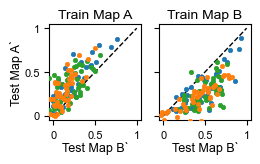

In [54]:
''' Plot Scatter of Decoder Scores Train/Test Context-Matched vs. -Mismatched (across Split Maze Block vs. Alt Phases) (Figure S5H)'''

# plot performance context-matched train/test vs. -mismatched train/test
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(2.6, 1.25), sharey = True) 
#f.suptitle('Decoder Performance by Train/Test Pairing & Age Group')

DOT_SIZE = 10
DOT_LW = 0.5
UNITY_WIDTH = 1
SEM_WIDTH = 0.8

avg_0to0 = AA_
avg_0to1 = AB_
avg_1to1 = BB_
avg_1to0 = BA_

# train on map 0, test on map 0 vs. test on map 1
ax0.scatter(avg_0to1[ysesh], avg_0to0[ysesh],
            facecolors='C0', edgecolors='C0', 
            s=DOT_SIZE, lw=DOT_LW, zorder=3, label = 'Young')   

ax0.scatter(avg_0to1[masesh], avg_0to0[masesh],
            facecolors='C2', edgecolors='C2', 
            s=DOT_SIZE, lw=DOT_LW, zorder=3, label = 'MA')   

ax0.scatter(avg_0to1[agesesh], avg_0to0[agesesh],
            facecolors='C1', edgecolors='C1', 
            s=DOT_SIZE, lw=DOT_LW, zorder=3, label = 'Aged')   

# train on map 1, test on map 1 vs. test on map 0
ax1.scatter(avg_1to1[ysesh], avg_1to0[ysesh],
            facecolors='C0', edgecolors='C0', 
            s=DOT_SIZE, lw=DOT_LW, zorder=3, label = 'Young')

ax1.scatter(avg_1to1[masesh], avg_1to0[masesh],
            facecolors='C2', edgecolors='C2', 
            s=DOT_SIZE, lw=DOT_LW, zorder=3, label = 'MA')  

ax1.scatter(avg_1to1[agesesh], avg_1to0[agesesh],
            facecolors='C1', edgecolors='C1', 
            s=DOT_SIZE, lw=DOT_LW, zorder=3, label = 'Aged')

# plot unity lines + shuffle/best lines
ax0.plot([0, 1], [0, 1], '--k', lw=UNITY_WIDTH, alpha=1)
ax1.plot([0, 1], [0, 1], '--k', lw=UNITY_WIDTH, alpha=1)

# label everything
ax0.set_title('Train Map A', fontsize=10, pad=4)
ax0.set_ylabel('Test Map A`', fontsize=9, labelpad=1)
ax0.set_xlabel('Test Map B`', fontsize=9, labelpad=1)
ax0.set_ylim([-0.05, 1.05])
ax0.set_xlim([-0.05, 1.05])
ax0.set_xticks([0, 0.5, 1])
ax0.set_xticklabels([0, 0.5, 1])
ax0.set_yticks([0, 0.5, 1])
ax0.set_yticklabels([0, 0.5, 1])

ax1.set_title('Train Map B', fontsize=10, pad=4)
#ax1.set_ylabel('Test Map 1', fontsize=9, labelpad=1)
ax1.set_xlabel('Test Map B`', fontsize=9, labelpad=1)
ax1.set_ylim([-0.05, 1.05])
ax1.set_xlim([-0.05, 1.05])
ax1.set_xticks([0, 0.5, 1])
ax1.set_xticklabels([0, 0.5, 1])
ax1.set_yticks([0, 0.5, 1])
ax1.set_yticklabels([0, 0.5, 1])

ax0.tick_params(which='major', labelsize=8)
ax1.tick_params(which='major', labelsize=8)
#ax1.legend(fontsize = 8)
#ax0.legend(fontsize = 8)

f.savefig(save_folder + 'S5H.png', dpi=400, bbox_inches='tight')
f.savefig(save_folder + 'S5H.svg', dpi=400, bbox_inches='tight')
plt.show()

In [55]:
'''Statistical Comparison of Decoder Scores Train/Test Context-Matched vs. -Mismatched by Age Group & Together'''
allsind = np.concatenate((ysesh, masesh, agesesh))

# train/test map 0 vs. map 1 on young mice
m0vsm1_stat, m0vsm1_p = stats.ranksums(avg_0to0[ysesh], avg_1to1[ysesh])
print('mean ± SEM train/test AA: ' + str(np.mean(avg_0to0[ysesh])) + ', ' + str(stats.sem(avg_0to0[ysesh])))
print('mean ± SEM train/test BB: ' + str(np.mean(avg_1to1[ysesh])) + ', ' + str(stats.sem(avg_1to1[ysesh])))
print('YOUNG train/test matched AA` vs. BB`: p = ' + str(m0vsm1_p))

# train/test map 0 vs. map 1 on MA mice
m0vsm1_stat, m0vsm1_p = stats.ranksums(avg_0to0[masesh], avg_1to1[masesh])
print('\nmean ± SEM train/test AA: ' + str(np.mean(avg_0to0[masesh])) + ', ' + str(stats.sem(avg_0to0[masesh])))
print('mean ± SEM train/test BB: ' + str(np.mean(avg_1to1[masesh])) + ', ' + str(stats.sem(avg_1to1[masesh])))
print('MA train/test matched AA` vs. BB`: p = ' + str(m0vsm1_p))

# train/test map 0 vs. map 1 on aged mice
m0vsm1_stat, m0vsm1_p = stats.ranksums(avg_0to0[agesesh], avg_1to1[agesesh])
print('\nmean ± SEM train/test AA: ' + str(np.mean(avg_0to0[agesesh])) + ', ' + str(stats.sem(avg_0to0[agesesh])))
print('mean ± SEM train/test BB: ' + str(np.mean(avg_1to1[agesesh])) + ', ' + str(stats.sem(avg_1to1[agesesh])))
print('AGED train/test matched AA` vs. BB`: p = ' + str(m0vsm1_p))

# train/test map 0 vs. map 1 on both age groups of mice
m0vsm1_stat, m0vsm1_p = stats.ranksums(avg_0to0[allsind], avg_1to1[allsind])
print('ALL train/test matched AA` vs. BB`: p = ' + str(m0vsm1_p))

# train/test same map vs. other map
same_to_same = np.append(avg_0to0[ysesh], avg_1to1[ysesh])
diff_to_diff = np.append(avg_0to1[ysesh], avg_1to0[ysesh])
sameVSdiff_stat, sameVSdiff_p = stats.wilcoxon(same_to_same, diff_to_diff, alternative = 'greater')
print('\nYOUNG train/test same (AA`, BB`) vs. train/test different (BA`, AB`): p = ' + str(sameVSdiff_p))
print('mean ± SEM test same: ' + str(np.mean(same_to_same)) + ', ' + str(stats.sem(same_to_same)))
print('mean ± SEM test diff: ' + str(np.mean(diff_to_diff)) + ', ' + str(stats.sem(diff_to_diff)))
print('n = ' + str(same_to_same.shape[0]) + ' model pairs')

same_to_same = np.append(avg_0to0[masesh], avg_1to1[masesh])
diff_to_diff = np.append(avg_0to1[masesh], avg_1to0[masesh])
sameVSdiff_stat, sameVSdiff_p = stats.wilcoxon(same_to_same, diff_to_diff, alternative = 'greater')
print('\nMA train/test same (AA`, BB`) vs. train/test different (BA`, AB`): p = ' + str(sameVSdiff_p))
print('mean ± SEM test same: ' + str(np.mean(same_to_same)) + ', ' + str(stats.sem(same_to_same)))
print('mean ± SEM test diff: ' + str(np.mean(diff_to_diff)) + ', ' + str(stats.sem(diff_to_diff)))
print('n = ' + str(same_to_same.shape[0]) + ' model pairs')

same_to_same = np.append(avg_0to0[agesesh], avg_1to1[agesesh])
diff_to_diff = np.append(avg_0to1[agesesh], avg_1to0[agesesh])
sameVSdiff_stat, sameVSdiff_p = stats.wilcoxon(same_to_same, diff_to_diff, alternative = 'greater')
print('\nAGED train/test same (AA`, BB`) vs. train/test different (BA`, AB`): p = ' + str(sameVSdiff_p))
print('mean ± SEM test same: ' + str(np.mean(same_to_same)) + ', ' + str(stats.sem(same_to_same)))
print('mean ± SEM test diff: ' + str(np.mean(diff_to_diff)) + ', ' + str(stats.sem(diff_to_diff)))
print('n = ' + str(same_to_same.shape[0]) + ' model pairs')

same_to_same = np.append(avg_0to0[allsind], avg_1to1[allsind])
diff_to_diff = np.append(avg_0to1[allsind], avg_1to0[allsind])
sameVSdiff_stat, sameVSdiff_p = stats.wilcoxon(same_to_same, diff_to_diff, alternative = 'greater')
print('\nALL train/test same (AA`, BB`) vs. train/test different (BA`, AB`): p = ' + str(sameVSdiff_p))
print('mean ± SEM test same: ' + str(np.mean(same_to_same)) + ', ' + str(stats.sem(same_to_same)))
print('mean ± SEM test diff: ' + str(np.mean(diff_to_diff)) + ', ' + str(stats.sem(diff_to_diff)))
print('n = ' + str(same_to_same.shape[0]) + ' model pairs')

#age group effects
stat, p = stats.kruskal(avg_0to0[ysesh],avg_0to0[masesh],avg_0to0[agesesh])
print('\nYOUNG vs. MA vs. AGED train/test map A/A` : p = ' + str(p))

stat, p = stats.kruskal(avg_1to1[ysesh],avg_1to1[masesh],avg_1to1[agesesh])
print('YOUNG vs. MA vs. AGED train/test map B/B`: p = ' + str(p))

stat, p = stats.kruskal(avg_1to0[ysesh],avg_1to0[masesh],avg_1to0[agesesh])
print('YOUNG vs. MA vs. AGED train/test map B/A`: p = ' + str(p))

stat, p = stats.kruskal(avg_0to1[ysesh],avg_0to1[masesh],avg_0to1[agesesh])
print('YOUNG vs. MA vs. AGED train/test map A/B`: p = ' + str(p))

mean ± SEM train/test AA: 0.3059375224767475, 0.03684962199421642
mean ± SEM train/test BB: 0.4636949577792973, 0.03191525638318153
YOUNG train/test matched AA` vs. BB`: p = 0.0024755745382998226

mean ± SEM train/test AA: 0.3282192779685536, 0.02647124275962248
mean ± SEM train/test BB: 0.4920387291048581, 0.023876486909786887
MA train/test matched AA` vs. BB`: p = 3.0074296575662524e-05

mean ± SEM train/test AA: 0.28527432370059025, 0.02828855583994674
mean ± SEM train/test BB: 0.42261861731697253, 0.03329792976745522
AGED train/test matched AA` vs. BB`: p = 0.0019169926132136471
ALL train/test matched AA` vs. BB`: p = 2.7217430643595137e-09

YOUNG train/test same (AA`, BB`) vs. train/test different (BA`, AB`): p = 2.8797660964495764e-16
mean ± SEM test same: 0.38481624012802246, 0.025560885111445594
mean ± SEM test diff: 0.22108552808309093, 0.023251323096217785
n = 96 model pairs

MA train/test same (AA`, BB`) vs. train/test different (BA`, AB`): p = 2.085693156900384e-16
mean ± S

# Setup for Figure S5A (left), B (left), C, E-F (Random Foraging)

In [56]:
'''Define which mice & sessions to load based on metadata'''
# Define mice, sessions for particular cohorts
mice , mice_ind, _  = np.intersect1d(all_mice,(np.union1d(cohorta_mice, cohortb_mice)), return_indices = True) # RF mice 

sessions = []
for i in mice_ind:
    sessions.append(all_sessions[i])

# Make a dict to hold data
data = {}

for session, m in zip(sessions, mice):
    data[m] = {}
    
    for s in session:
        data[m][s] = {}

In [57]:
''' Classify RF Spatial Cells using Saved Scores '''

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #get file names
        shufsparsityscore_file = 'shufsparsityscores_' + m + '_' + s + '.npy'
        shufspatialcoherencescore_file = 'shufspatialcoherencescores_' + m + '_' + s + '.npy'

        #load npy files
        d['shuffsparsityscores'] = np.load(shuffload_folder1 + shufsparsityscore_file, allow_pickle=False)
        d['shuffspatialcoherencescores'] = np.load(shuffload_folder2 + shufspatialcoherencescore_file, allow_pickle=False)
        
        #get file names
        sparsityscore_file = 'sparsityscores_' + m + '_' + s + '.npy'
        spatialcoherencescore_file = 'spatialcoherencescores_' + m + '_' + s + '.npy'
        
        #load npy files
        d['sparsityscores'] = np.load(fig5_folder + sparsityscore_file, allow_pickle=True)
        d['spatialcoherencescores'] = np.load(fig5_folder + spatialcoherencescore_file, allow_pickle=True)    
        
per99c = []
per99s = []
dt = 0.02

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #Load scores, intn boolean to filter out interneurons
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        intn_file = 'intn_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        d['intn'] = np.load(int_save_folder + intn_file, allow_pickle = True)
        cell_IDs = raw.item().get('cellsfil')
        sparsity_scores = d['sparsityscores']
        spatialcoherence_scores = d['spatialcoherencescores']
        shuffsparsityscores = d['shuffsparsityscores']
        shuffspatialcoherencescores = d['shuffspatialcoherencescores'] 
        intn = d['intn'].astype(bool)

        #Classify spatial cells as those >P95, >P99 of both sparsity & coherence distributions
        spatialcell99 = []
        spatialcells99 = []
    
        for i, c in enumerate(cell_IDs):
            dist1 = shuffspatialcoherencescores[:,i]
            P991 = np.percentile(dist1,99)

            dist2 = shuffsparsityscores[:,i]
            P992 = np.percentile(dist2,99)
            
            per99c.append(P991)
            per99s.append(P992)

            if intn[i] == True:
                spatialcell99 = np.append(spatialcell99, False)
            elif (spatialcoherence_scores[i] > P991) & (sparsity_scores[i] > P992):
                spatialcell99 = np.append(spatialcell99, True)
            else:
                spatialcell99 = np.append(spatialcell99, False)

        spatialcell99 = np.asarray(spatialcell99).astype(bool)
        
        d['spatialcells99'] = cell_IDs[spatialcell99]
        d['spatialcell99'] = spatialcell99
        
        spatialcell99_file = 'spatialcell99_' + m + '_' + s + '.npy'

print('\nMean ± SEM Coherence P99: ' + str(np.mean(per99c)) + ' ± ' + str(stats.sem(per99c)))  
print('\nMean ± SEM Sparsity P99: ' + str(np.nanmean(per99s)) + ' ± ' + str(stats.sem(per99s,  nan_policy = 'omit'))) 

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]


Mean ± SEM Coherence P99: 0.44397451511927966 ± 0.001023052553156076

Mean ± SEM Sparsity P99: 0.8021158854819103 ± 0.0022493857825195036


In [58]:
'''Get Indices of Stored Session, Animal Data Mice by Age Group'''
age_ind = []
ma_ind = []
y_ind = []
age_sind = []
ma_sind = []
y_sind = []

s_count = 0
for m, s in zip(mice, sessions):
    start = s_count
    end = len(s) + s_count

    if m in all_aged_mice:
        age_ind = np.append(age_ind, (np.where(mice == m)[0]))
        age_sind = np.append(age_sind, np.arange(start, end, 1))
    elif m in all_MA_mice:
        ma_ind = np.append(ma_ind, (np.where(mice == m)[0]))
        ma_sind = np.append(ma_sind, np.arange(start, end, 1))
    else:
        y_ind = np.append(y_ind, (np.where(mice == m)[0]))
        y_sind = np.append(y_sind, np.arange(start, end, 1))
                            
    s_count += len(s)
    
age_ind = age_ind.astype(int)
#ma_ind = ma_ind.astype(int)
y_ind = y_ind.astype(int)
age_sind = age_sind.astype(int)
#ma_sind = ma_sind.astype(int)
y_sind = y_sind.astype(int)

print(mice[y_ind], mice[age_ind])
print(len(mice[y_ind]), len(mice[age_ind]))
print(len(y_sind), len(age_sind))
Nold = len(mice[age_ind])
Nyoung = len(mice[y_ind])

['Y11' 'Y16' 'Y17' 'Y18' 'Y19' 'Y2' 'Y3' 'Y4' 'Y9'] ['A12' 'A13' 'A3' 'A4' 'A5' 'A6' 'A7']
9 7
44 42


In [59]:
''' Define ColorMaps for Session & Animal Boxplots '''
import matplotlib.pylab as pl
import matplotlib.lines as mlines

col_animal_old = pl.cm.Oranges([np.linspace(0.2,0.9,Nold)])
col_animal_young = pl.cm.Blues([np.linspace(0.2,0.9,Nyoung)])
col_animal = [col_animal_young, col_animal_old]

col_session_young = []
col_session_old = []
for m, session in zip(mice, sessions):
    for s in range(0,len(session)):
        
        if m in RF_aged_mice:
            idx = np.where(mice == m)[0][0]
            col_session_old.append(col_animal[1][0][idx])
        else:
            idx = np.where(mice == m)[0][0] - Nold
            col_session_young.append(col_animal[0][0][idx])

col_session = [col_session_young,col_session_old]

label_mice = ['Y11', 'Y16', 'Y17', 'Y18', 'Y19', 'Y2', 'Y3', 'Y4','Y9','A12', 'A13', 'A3', 'A4', 'A5', 'A6', 'A7']

In [60]:
'''Calculate Spatial Cell Density, Mean FR, Peak FR & Store; Store Spatial Coherence & Spatial Sparsity Scores'''

# set up arrays for plotting by session 
sper99 = []
for m, session in zip(mice,sessions):
    
    for s in tdqm(session):
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        spatialcell99 = d['spatialcell99']
        spatialcell99 = np.asarray(spatialcell99).astype(bool)
        spatialcells99 = cell_IDs[spatialcell99]
        sper99 = np.append(sper99, 100 * len(spatialcells99)/len(cell_IDs))

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [61]:
''' Find where I will have NaNs for Scores, Mean & Peak FR, Slope, Y-Int'''
nan_idx99 = np.where((sper99 == 0))[0]
print(nan_idx99)
print(len(col_session[0]),len(col_session[1]))

# Adjust y_sind, ma_sind, age_sind for subsequent plots
y_sind99 = np.setdiff1d(y_sind, nan_idx99)
ma_sind99 = np.setdiff1d(ma_sind, nan_idx99)
age_sind99 = np.setdiff1d(age_sind, nan_idx99)

#adjust colormaps
yidx = []
aidx = []
for i in nan_idx99:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int))
    
col_session_young99 = np.delete(col_session_young, list((yidx).astype(int)), axis = 0)
col_session_old99 = np.delete(col_session_old, list(aidx), axis = 0)
col_session99 = [col_session_young99, col_session_old99] 

print(len(col_session_young99), len(col_session_old99))

# This will fix session stats & box plots are plotted.

[85]
44 42
43 42


In [62]:
''' Load in saved FRtensor from Figure 3 / S4 notebook & generate similarity matrices '''

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
dt = 0.02

for m, session in zip(mice,sessions):        
    for s in tdqm(session):
        
        #get data
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        spatialcell99 = d['spatialcell99']
        spatialcells = cell_IDs[spatialcell99]
        
        if len(spatialcells) > 10:
            FRtensor_file = 'RF_FRtensor_' + m + '_' + s + '.npy'
            d['FRtensor'] = np.load(fig3s4_folder + FRtensor_file)
            Y = d['FRtensor']

            Y_unwrapped = np.reshape(Y, (Y.shape[0], -1))
            sim_vec = np.abs(pdist(Y_unwrapped, 'correlation')-1)
            sim = squareform(sim_vec)
            d['similarity'] = sim

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

# Load results of k optimization code in Figure 3 & S4 notebook. 

In [63]:
''' Load in K-Means Stuff'''
from tqdm import tqdm
from lvl.factor_models import KMeans as lvl_kmeans
from lvl.factor_models import NMF as lvl_soft_kmeans
from lvl.resamplers import RotationResampler
from lvl.crossval import speckled_cv_scores 
from scipy.spatial.distance import cdist 
from scipy.special import logsumexp
from sklearn.metrics import silhouette_samples, silhouette_score

In [64]:
''' After k optimization, load in results & perform K-means using optimal k. '''

yk = []
ak = []
optimalks = []

for m, session in zip(mice, sessions):    
    for s in tdqm(session):
        
        d = data[m][s]
        
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        spatialcell99 = d['spatialcell99']
        spatialcells = cell_IDs[spatialcell99]
        
        if len(spatialcells) > 10:
            
            onemapfile = 'onemap' + m + '_' + s + '.npy'
            onemap = np.load(fig3s4_folder + onemapfile)
            
            if onemap[0].astype(bool) == True:
                
                d['kmeans'] = {}
                d['kmeans']['onemap'] = onemap 
                
                optimalks = np.append(optimalks, 1)
                
                if m in RF_aged_mice:
                    ak = np.append(ak, 1)
                else:
                    yk = np.append(yk, 1)
            
            else:
        
                d['kmeans'] = {}
                d['kmeans']['onemap'] = onemap 

                #load optimal k
                SilN_file = 'SilN_' + m + '_' + s + '.npy'
                d['kmeans']['SilN'] = np.load(fig3s4_folder + SilN_file)
                SilN = d['kmeans']['SilN']
                
                optimalks = np.append(optimalks, SilN)
            
                if m in RF_aged_mice:
                    ak = np.append(ak, SilN)
                else:
                    yk = np.append(yk, SilN)
                
                #load FR tensor
                Y = d['FRtensor'].copy()
                Y = Y.transpose(0, 2, 1)
                Y_unwrapped = np.reshape(Y, (Y.shape[0], -1))
                
                #run k-means
                model_kmeans = lvl_kmeans(n_components = SilN, n_restarts = 100)
                model_kmeans.fit(Y_unwrapped)
                W, H = model_kmeans.factors
                Y_hat = model_kmeans.predict()
                score = model_kmeans.score(Y_unwrapped)
                d['kmeans']['W'] = W
                d['kmeans']['H'] = H
                d['kmeans']['Y_hat'] = Y_hat 
                d['kmeans']['Y_hat'] = Y_hat 
                d['kmeans']['score'] = score          

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [65]:
''' Gather the relative performance of K-Means vs. TSVD at Optimal K

Run time: ~a few minutes / session x 61 sessions. Given that there are more spatial cells than grid cells, this takes longer.

'''

from tqdm import tqdm
from lvl.crossval import speckled_cv_scores 
from lvl.factor_models import TSVD

# For every session with sufficient spatial cells, plot 
kmeansr2 = []
tsvdr2 = []

n_ranks = 1
n_repeats = 10
UNITY_LW = 3

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        
        d = data[m][s]

        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        spatialcell99 = d['spatialcell99']
        spatialcells = cell_IDs[spatialcell99]
        
        if len(spatialcells) > 10: 
            
            onemap = d['kmeans']['onemap']
            
            if onemap[0].astype(bool) == False:
                SilN = d['kmeans']['SilN']
                SilN = int(SilN)
                ranks = [SilN]
            else:
                ranks = [1]
                      
            #load in the real data
            Y = d['FRtensor'].copy()
            Y = Y.transpose(0, 2, 1)
            Y_unwrapped = np.reshape(Y, (Y.shape[0], -1))

            # Run cross-validated k-means with speckled holdout pattern 
            km_train_scores = np.ones((n_ranks, n_repeats))
            km_test_scores = np.ones((n_ranks, n_repeats))
            for i, rank in enumerate(ranks):
                model = lvl_kmeans(n_components=rank, n_restarts=100, maxiter=1000)
                km_train_scores[i], km_test_scores[i] = \
                    speckled_cv_scores(model, Y_unwrapped, n_repeats=n_repeats)
            kmeansr2 = np.append(kmeansr2, np.mean(km_test_scores))

            # Run cross-validated truncated SVD with speckled holdout pattern.
            tsvd_train_scores = np.ones((n_ranks, n_repeats))
            tsvd_test_scores = np.ones((n_ranks, n_repeats))

            for i, rank in enumerate(ranks):
                model = TSVD(n_components=rank, method="als", maxiter=1000)
                tsvd_train_scores[i], tsvd_test_scores[i] = \
                    speckled_cv_scores(model, Y_unwrapped, n_repeats=n_repeats)
            tsvdr2 = np.append(tsvdr2, np.mean(tsvd_test_scores))

# report idx of sessions in each age group             
y_sind10_short = []
age_sind10_short = []
count = 0
for m, session in zip(mice, sessions):
    for s in tdqm(session):
        
        d = data[m][s]

        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        spatialcell99 = d['spatialcell99']
        spatialcells = cell_IDs[spatialcell99]
        
        if len(spatialcells) > 10:
            if m in RF_aged_mice:
                age_sind10_short = np.append(age_sind10_short, count)
            else:
                y_sind10_short = np.append(y_sind10_short, count)
                
            count += 1  
            
y_sind10_short = y_sind10_short.astype(int)
age_sind10_short = age_sind10_short.astype(int)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

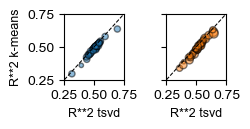

39 aged, 39 young sessions
young results: 
PearsonRResult(statistic=0.9834013538301751, pvalue=4.957201382045384e-29)
aged results: 
PearsonRResult(statistic=0.9881540779830235, pvalue=1.0049907357140959e-31)


In [66]:
''' Plot Figure S5A (left) '''

y_sind10_short = y_sind10_short.astype(int)
age_sind10_short = age_sind10_short.astype(int)

f, ax = plt.subplots(1, 2, figsize=(2.6, 1.4), sharey = True, sharex = True)
rax = np.tile(ranks, (n_repeats, 1)).T.ravel()

ax[1].scatter(tsvdr2[age_sind10_short], kmeansr2[age_sind10_short], s = ak*10, label = 'aged', color = 'C1', alpha = 0.5, edgecolor = 'k')
ax[0].scatter(tsvdr2[y_sind10_short], kmeansr2[y_sind10_short], s= yk*10,  label = 'young', color = 'C0', alpha = 0.5, edgecolor = 'k')

#label stuff
ax[0].set_ylabel("R**2 k-means", fontsize = 9)
ax[0].set_xlabel("R**2 tsvd", fontsize = 9)
#ax[1].set_ylabel("R**2 k-means", fontsize = 9)
ax[1].set_xlabel("R**2 tsvd", fontsize = 9)
ax[0].set_yticks([0.25,0.5,0.75])
ax[1].set_yticks([0.25,0.5,0.75])
ax[0].set_xlim([0.25, 0.75])
ax[0].set_ylim([0.25, 0.75])
ax[1].set_xlim([0.25, 0.75])
ax[1].set_ylim([0.25, 0.75])

#plot unity line
xlims = ax[0].get_xlim()
ylims = ax[0].get_ylim()
min_plot = np.min([xlims[0], ylims[0]])
max_plot = np.max([xlims[1], ylims[1]])
min_plot = np.min([xlims[0], ylims[0]])
max_plot = np.max([xlims[1], ylims[1]])
ax[0].plot([min_plot, max_plot], [min_plot, max_plot], '--k', lw=0.75, zorder=4, alpha=1)
ax[1].plot([min_plot, max_plot], [min_plot, max_plot], '--k', lw=0.75, zorder=4, alpha=1)
plt.tight_layout()

f.savefig(save_folder + 'S5Aleft.svg', dpi = 400)
f.savefig(save_folder + 'S5Aleft.png', dpi = 400)
plt.show()

print(str(len(kmeansr2[age_sind10_short])) + ' aged, ' + str(len(kmeansr2[y_sind10_short])) + ' young sessions')
print('young results: ')
print(stats.pearsonr(tsvdr2[y_sind10_short], kmeansr2[y_sind10_short]))
print('aged results: ')
print(stats.pearsonr(tsvdr2[age_sind10_short], kmeansr2[age_sind10_short]))

# Re-label K-Means maps non-arbitrarily & examine alignment across vs. within map similarity.

In [67]:
''' Re-label RF spatial maps non-arbitrarily (slower map is map 0) '''

for m, session in zip(mice, sessions):
    
    if m in cohortb_mice:
        max_trials = 240
    else:
        max_trials = 200
    
    for s in tdqm(session):
        d = data[m][s]
        
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)

        cell_IDs = raw.item().get('cellsfil')
        posx = behaviorfil[:,0]
        speed = behaviorfil[:,1]
        trial = behaviorfil[:,2]
        max_trials = np.max(trial)
        rawtrialfil = raw.item().get('trialfil')
        spatialcell99 = d['spatialcell99']
        spatialcells = cell_IDs[spatialcell99]
        
        #Find any skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            skippedtrials = get.find_skipped(trial, max_trial_num = max_trials)
        except:
            skippedtrials = []
        
        if np.max(np.unique(trial)) < 160: #handles truncated, shorter sessions 
            alltrial = np.arange(0, np.max(np.unique(trial)) + 1, 1)
        else:
            alltrial = np.arange(0,max_trials,1)
        trials = np.unique(trial)
        
        #count number of skipped dark trials
        ndarkskipped = 0
        for z in skippedtrials:
            if z < 20: 
                ndarkskipped += 1
                
        #adjust trialfil so that sorted trials are skipped instead
        skippedrawtrialfil = get.sortedtrialbyframe(rawtrialfil, trial, skippedtrials)
        numtrial = np.unique(skippedrawtrialfil)
            
        #define random foraging trials only, excluding dark & gain change periods
        if m == 'Y9':
            start_idx = 0 
            end_idx = len(skippedrawtrialfil) + 1
        elif m in cohortb_mice:
            start_idx = (np.where(skippedrawtrialfil >= 20)[0][0]).astype(int)
            end_idx = (np.where(skippedrawtrialfil >= 200)[0][0]).astype(int)
        else:
            start_idx = 0 
            end_idx = len(skippedrawtrialfil) + 1
        
        if len(spatialcells) > 10: 
            onemap = d['kmeans']['onemap']
            if onemap[0].astype(bool) == False:
                SilN = d['kmeans']['SilN']
                if SilN == 2:
                    W = d['kmeans']['W']
                    H = d['kmeans']['H']

                    # get map indices
                    map_idx = W[:, 0].astype(bool)
                    trials = skippedrawtrialfil[start_idx:end_idx]
                    map0_idx = np.zeros_like(trials)
                    map1_idx = np.zeros_like(trials)
                    for i, t in enumerate(np.unique(trials)):
                        if map_idx[i]:
                            map0_idx[trials == t] = 1
                        else:
                            map1_idx[trials == t] = 1
                    map0_idx = map0_idx.astype(bool)
                    map1_idx = map1_idx.astype(bool)

                    # get running speed in each map and assign map 0 to slower map
                    RFspeed = speed[start_idx:end_idx]
                    speed_0 = np.nanmean(RFspeed[map0_idx])
                    speed_1 = np.nanmean(RFspeed[map1_idx])

                    if speed_1 < speed_0: # swap labels
                        d['map0_idx'] = 1
                    else:
                        d['map0_idx'] = 0

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [68]:
'''Compute within vs. across map similarity '''
saged_within = []
saged_across = []
syoung_within = []
syoung_across = []

countaged = 0
countyoung = 0

for m, session in zip(mice, sessions):
    
    m_within = []
    m_across = []
    
    for s in session:
        d = data[m][s]
        
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        spatialcell99 = d['spatialcell99']
        spatialcells = cell_IDs[spatialcell99]
        
        if len(spatialcells) > 10: 
            onemap = d['kmeans']['onemap']
            if onemap[0].astype(bool) == False:
                SilN = d['kmeans']['SilN']
                if SilN == 2:
                    sim = d['similarity']
                    W = d['kmeans']['W']
                    map_0 = W[:, d['map0_idx']].astype(bool)

                    # split by trial
                    sim_0 = sim[map_0, :]
                    sim_0 = sim_0[:, map_0]
                    sim_1 = sim[~map_0, :]
                    sim_1 = sim_1[:, ~map_0]
                    sim_across = sim[map_0, :]
                    sim_across = sim_across[:, ~map_0]

                    # calculate the average similarity within vs. across maps
                    within = np.append(sim_0[np.triu_indices(n=sim_0.shape[0], k=1)], 
                                       sim_1[np.triu_indices(n=sim_1.shape[0], k=1)])
                    avg_within = np.mean(within)
                    across = sim_across[np.triu_indices(n=sim_across.shape[0], k=1, m=sim_across.shape[1])]
                    avg_across = np.mean(across)

                    # save for all sessions
                    if m in RF_aged_mice:
                        countaged += 1
                        saged_within = np.append(saged_within, avg_within)
                        saged_across = np.append(saged_across, avg_across)
                    else: 
                        countyoung += 1
                        syoung_within = np.append(syoung_within, avg_within)
                        syoung_across = np.append(syoung_across, avg_across)

In [69]:
'''In both age groups, are maps more similar to themselves?'''
# % change in aged spatial similarity
d_sim = ((saged_across - saged_within) / saged_within) * 100
print('mean, sem within map similarity: {}, {}'.format(np.round(np.mean(saged_within), 2), np.round(stats.sem(saged_within), 2)))
print('mean, sem across map similarity: {}, {}'.format(np.round(np.mean(saged_across), 2), np.round(stats.sem(saged_across), 2)))
print('pct change in spatial similarity (mean, sem) aged: {}, {}%'.format(np.round(np.mean(d_sim), 2), np.round(stats.sem(d_sim), 2)))

# % change in young spatial similarity
d_sim = ((syoung_across - syoung_within) / syoung_within) * 100
print('\nmean, sem within map similarity: {}, {}'.format(np.round(np.mean(syoung_within), 2), np.round(stats.sem(syoung_within), 2)))
print('mean, sem across map similarity: {}, {}'.format(np.round(np.mean(syoung_across), 2), np.round(stats.sem(syoung_across), 2)))
print('pct change in spatial similarity (mean, sem) young: {}, {}%'.format(np.round(np.mean(d_sim), 2), np.round(stats.sem(d_sim), 2)))

sameVSdiff_stat, sameVSdiff_p = stats.wilcoxon(saged_within, saged_across)
print('\nwithin map vs across map similarity: aged_p = ' + str(sameVSdiff_p))
print('n = ' + str(saged_within.shape[0]) + ' model pairs')

sameVSdiff_stat, sameVSdiff_p = stats.wilcoxon(syoung_within, syoung_across)
print('within map vs across map similarity: young_p = ' + str(sameVSdiff_p))
print('n = ' + str(syoung_within.shape[0]) + ' model pairs')

mean, sem within map similarity: 0.5, 0.01
mean, sem across map similarity: 0.32, 0.02
pct change in spatial similarity (mean, sem) aged: -37.52, 3.64%

mean, sem within map similarity: 0.51, 0.01
mean, sem across map similarity: 0.3, 0.02
pct change in spatial similarity (mean, sem) young: -40.84, 3.83%

within map vs across map similarity: aged_p = 2.9802322387695312e-08
n = 26 model pairs
within map vs across map similarity: young_p = 5.820766091346741e-11
n = 35 model pairs


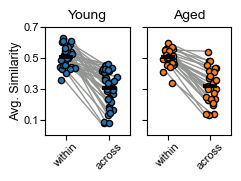

In [70]:
''' Plot Figure S5B (left)'''

# plot similarity within vs. across
f, ax = plt.subplots(1, 2, figsize=(2.4, 1.4), sharey = True)
#f.suptitle('Similarity Within vs. Across Maps by Age Group, Session', y = 1.05)
DOT_SIZE = 20
DOT_LW = 1
BAR_SIZE = 10
BAR_WIDTH = 2.8
labels = ['within', 'across']

## PLOT AGED DATA 
j = np.random.randn(saged_within.shape[0]) * .08

# plot connector lines
for k, w in enumerate(saged_within): # plot connector lines
    a = saged_across[k]
    x_vals = [1.08+j[k], 1.92+j[k]]
    y_vals = [w-0.005, a+0.005]
    ax[1].plot(x_vals, y_vals, '-', color='xkcd:gray', lw=DOT_LW, zorder=1,  alpha=1)

# within map similarity
ax[1].scatter(np.full(len(saged_within), 1)+j, saged_within,
           facecolors='C1', edgecolors='k', alpha=1,
           s=DOT_SIZE, lw=DOT_LW, zorder=2, label='Aged') 

# across map similarity
ax[1].scatter(np.full(len(saged_within), 2)+j, saged_across,
           facecolors='C1', edgecolors='k', alpha=1,
           s=DOT_SIZE, lw=DOT_LW, zorder=2, label = 'Aged') 

# plot means
ax[1].plot(1, np.mean(saged_within), '_', c='k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=3)
ax[1].plot(2, np.mean(saged_across), '_', c='k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=3)

## PLOT Young DATA 
j = np.random.randn(syoung_within.shape[0]) * .08

# plot connector lines
for k, w in enumerate(syoung_within): # plot connector lines
    a = syoung_across[k]
    x_vals = [1.08+j[k], 1.92+j[k]]
    y_vals = [w-0.005, a+0.005]
    ax[0].plot(x_vals, y_vals, '-', color='xkcd:gray', lw=DOT_LW, zorder=1,  alpha=1)

# within map similarity
ax[0].scatter(np.full(len(syoung_within), 1)+j, syoung_within,
           facecolors='C0', edgecolors='k', alpha=1,
           s=DOT_SIZE, lw=DOT_LW, zorder=2, label='Young') 

# across map similarity
ax[0].scatter(np.full(len(syoung_within), 2)+j, syoung_across,
           facecolors='C0', edgecolors='k', alpha=1,
           s=DOT_SIZE, lw=DOT_LW, zorder=2) 

# plot means
ax[0].plot(1, np.mean(syoung_within), '_', c='k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=3)
ax[0].plot(2, np.mean(syoung_across), '_', c='k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=3)

ax[1].set_xlim([0.5, 2.5])
ax[1].set_xticks([1, 2])
ax[1].set_yticks([0.1, 0.3, 0.5, 0.7])
ax[1].set_ylim([0,0.7])
ax[0].set_ylim([0,0.7])
ax[1].set_xticklabels(labels, rotation=45)
ax[1].tick_params(which='major', labelsize=8, pad=0.8)
ax[1].set_title('Aged', fontsize = 10)

ax[0].set_xlim([0.5, 2.5])
ax[0].set_xticks([1, 2])
ax[0].set_xticklabels(labels, rotation=45)
ax[0].tick_params(which='major', labelsize=8, pad=0.8)
ax[0].set_title('Young', fontsize = 10)
ax[0].set_ylabel('Avg. Similarity', fontsize=9, labelpad=1)
f.savefig(save_folder + 'S5Bleft.png', dpi=400, bbox_inches='tight')
f.savefig(save_folder + 'S5Bleft.svg', dpi=400, bbox_inches='tight')
plt.show()

In [71]:
''' Statistics Young vs. Aged Within, Across, Diff (Within - Across) Map Similarity'''

print('WITHIN RESULTS:')
print('withinyoung ± SEM; withinstab_old ± SEM')
print(str(np.round(np.nanmean(syoung_within), 4)) + ' ± ' + str(np.round(stats.sem(syoung_within), 4)) + ' ; ' 
      + str(np.round(np.nanmean(saged_within), 4)) + ' ± ' + str(np.round(stats.sem(saged_within), 4)))

stat, p_diff = stats.ranksums(syoung_within, saged_within)
print('stat = ' + str(stat))
print('p_session = ' + str(p_diff))

print('\nACROSS RESULTS:')
print('acrossyoung ± SEM; acrossstab_old ± SEM')
print(str(np.round(np.nanmean(syoung_across), 4)) + ' ± ' + str(np.round(stats.sem(syoung_across), 4)) + ' ; ' 
      + str(np.round(np.nanmean(saged_across), 4)) + ' ± ' + str(np.round(stats.sem(saged_across), 4)))

stat, p_diff = stats.ranksums(syoung_across, saged_across)
print('stat = ' + str(stat))
print('p_session = ' + str(p_diff))

sd_sima = ((saged_across - saged_within) / saged_within) * 100
sd_simy = ((syoung_across - syoung_within) / syoung_within) * 100

print('\nWithin - Across % Change RESULTS:')
print('changeyoung ± SEM; changestab_old ± SEM')
print(str(np.round(np.nanmean(sd_simy), 4)) + ' ± ' + str(np.round(stats.sem(sd_simy), 4)) + ' ; ' 
      + str(np.round(np.nanmean(sd_sima), 4)) + ' ± ' + str(np.round(stats.sem(sd_sima), 4)))

stat, p_diff = stats.ranksums(sd_simy, sd_sima)
print('stat = ' + str(stat))
print('p_session = ' + str(p_diff))

WITHIN RESULTS:
withinyoung ± SEM; withinstab_old ± SEM
0.5095 ± 0.0106 ; 0.5036 ± 0.011
stat = 0.1458391357870652
p_session = 0.8840483802881689

ACROSS RESULTS:
acrossyoung ± SEM; acrossstab_old ± SEM
0.3025 ± 0.0202 ; 0.3204 ± 0.0227
stat = -0.4229334937824891
p_session = 0.6723437848219764

Within - Across % Change RESULTS:
changeyoung ± SEM; changestab_old ± SEM
-40.8442 ± 3.8274 ; -37.5228 ± 3.6444
stat = -0.3500139258889565
p_session = 0.7263282465634255


In [72]:
''' Measure remapping coordination in each age group ''' 

smeancorr = []
bins = np.arange(0, 0.8, 0.05)

for m, session in zip(mice, sessions):

    for s in tdqm(session):
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        spatialcell = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell]   
        
        if m in RF_aged_mice:
            col = 'C1'
        else:
            col = 'C0'
        
        if len(spatialcells) > 2:
            
            # load Cross-Trial Correlation Matrix for each RF Spatial Cell computed in Figure 5 Notebook
            allsim_file = 'allsim_' + m + '_' + s + '_'+ '.npy'
            allsim = np.load(fig5_folder + allsim_file)
            
            correlation = []
            for i, c in enumerate(spatialcells):
                littlesim = allsim[:,:,i]
                allothersim = np.delete(allsim, i, axis = 2)
                sim = np.mean(allothersim, axis = 2)
                mask = np.triu_indices(sim.shape[0])
            
                #linearize upper triangles of each sim matrix
                uppersim = sim[mask]
                upperlittlesim = littlesim[mask]

                #compute correlation of front & back matrices with each other
                corr, _ = stats.pearsonr(uppersim[~np.isnan(uppersim)], upperlittlesim[~np.isnan(uppersim)])
                correlation = np.append(correlation, corr)
            
            smeancorr = np.append(smeancorr, np.mean(correlation))
            
        else:
            print('too few spatial cells, cannot compute corr for this session')
            smeancorr = np.append(smeancorr, np.nan)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

too few spatial cells, cannot compute corr for this session


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

too few spatial cells, cannot compute corr for this session


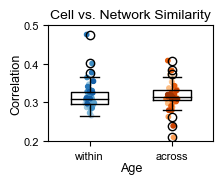

In [73]:
''' Plot Figure S5C '''

fig, ax = plt.subplots(1, 1, figsize=(2.125, 1.5), sharey = False)
#f.suptitle('Spatial Cell Session Network Similarity Matrix Correlation, Pooled by Age Group', fontsize=12)

scorr_tog = [smeancorr[y_sind99][~np.isnan(smeancorr[y_sind99])],smeancorr[age_sind99]]
ax.boxplot(scorr_tog, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax.set_title('Cell vs. Network Similarity', fontsize=10, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('Correlation', fontsize=9, labelpad=1)
ax.set_ylim([0.2,0.5])
ax.tick_params(labelsize = 8)
ax.set_yticks([0.2,0.3,0.4,0.5])

for i in range(len(scorr_tog)):
    y = scorr_tog[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    ax.scatter(x, y, color = col_session99[i][:len(y)], edgecolors = col_session99[i][:len(y)], alpha = 1, s = 10)

plt.savefig(save_folder + 'S5C.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S5C.svg', dpi=400, bbox_inches='tight')
plt.show()

In [74]:
''' Statistically compare remapping coordination across age groups '''

print('\nn young, aged sessions with > 2 spatial cells:')
print(len(smeancorr[y_sind99][~np.isnan(smeancorr[y_sind99])]), len(smeancorr[age_sind99][~np.isnan(smeancorr[age_sind99])]))
print('corryoung ± SEM; corr_MA ± SEM; corr_old ± SEM')
print(str(np.round(np.nanmean(smeancorr[y_sind99]), 3)) + ' ± ' + str(np.round(stats.sem(smeancorr[y_sind99], nan_policy = 'omit'), 3)) + ' ; ' 
      + str(np.round(np.nanmean(smeancorr[age_sind99]), 3)) + ' ± ' + str(np.round(stats.sem(smeancorr[age_sind99], nan_policy = 'omit'), 3)))

stat, p_diff = stats.ranksums(smeancorr[y_sind99][~np.isnan(smeancorr[y_sind99])],smeancorr[age_sind99][~np.isnan(smeancorr[age_sind99])])
print('stat = ' + str(stat))
print('p_corr = ' + str(p_diff))


n young, aged sessions with > 2 spatial cells:
42 42
corryoung ± SEM; corr_MA ± SEM; corr_old ± SEM
0.318 ± 0.006 ; 0.317 ± 0.005
stat = -1.127203723953269
p_corr = 0.25965635637045015


# Compare heterogeneity of spatial cell network spatial information within and across maps for the Random Foraging environment (Figure S5E-F).

Here, we use a circular position decoder to compare accuracy of position decoding score when trained/tested on spatial network activity within and across Random Foraging spatial maps (e.g. Train on Map 1 and Test on Map 1 vs. Map 2), recapitulating analyses in Low et al. 2021 (Figure 6). Spatial network information should heterogenous across maps, resulting in better decoder performance when trained / tested on the same vs. a different map. The goal of this analysis was to verify these expectations about spatial network information content in this dataset and given this k optimization procedure. Additionally, we will show that aged session decoder scores are lower in any train/test configuration than young decoder scores. This further controls for the possibility that lower aged session decoder performance when trained/tested on random RF trials (see Figure 5H) in might arise from differences in the extent to spatial information is segregated across maps or differences in remapping frequency (see Figure S4H).

In [75]:
''' Compute & Save Start & Stop Indices Corresponding to End of Dark, Start of Gain Periods'''

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

dt = 0.02

for m, session in zip(mice,sessions):
        
    if m in cohortb_mice:
        max_trials = 240
    else:
        max_trials = 200
        
    for s in tdqm(session):
        
        #get data
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        spatialcell99 = d['spatialcell99']
        spatialcells = cell_IDs[spatialcell99]
    
        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        rawtrialfil = raw.item().get('trialfil')
        
        #Find any skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            skippedtrials = get.find_skipped(trial, max_trial_num = max_trials)
        except:
            skippedtrials = []
        
        if np.max(np.unique(trial)) < 160: #handles truncated, shorter sessions 
            alltrial = np.arange(0, np.max(np.unique(trial)) + 1, 1)
            #print(m, s)
        else:
            alltrial = np.arange(0,max_trials,1)

        # Load in left vs. right info
        trials = np.unique(trial)
        
        #count number of skipped dark trials
        ndarkskipped = 0
        for z in skippedtrials:
            if z < 20: 
                ndarkskipped += 1
                
        #adjust trialfil so that trials are skipped instead
        skippedrawtrialfil = get.sortedtrialbyframe(rawtrialfil, trial, skippedtrials)
        numtrial = np.unique(skippedrawtrialfil)
            
        #define random foraging trials only, excluding dark & gain change periods
        if m == 'Y9':
            start_idx = 0 
            end_idx = len(skippedrawtrialfil) + 1
        elif m in cohortb_mice:
            start_idx = (np.where(skippedrawtrialfil >= 20)[0][0]).astype(int)
            end_idx = (np.where(skippedrawtrialfil >= 220)[0][0]).astype(int)
        else:
            start_idx = 0 
            end_idx = len(skippedrawtrialfil) + 1
            
        d['start'] = start_idx
        d['end'] = end_idx

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [77]:
''' Regenerate K-Means results for any RF sessions with onemap = False and k = 2 '''
sscore = []
for m, session in zip(mice, sessions):    
    for s in tdqm(session):
        
        d = data[m][s]
        
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        spatialcell99 = d['spatialcell99']
        spatialcells = cell_IDs[spatialcell99]
        
        if len(spatialcells) > 10:
            
            onemapfile = 'onemap' + m + '_' + s + '.npy'
            onemap = np.load(fig3s4_folder + onemapfile)
            
            d['kmeans'] = {}
            d['kmeans']['onemap'] = onemap 
            
            if onemap[0].astype(bool) == False:

                #load optimal k
                SilN_file = 'SilN_' + m + '_' + s + '.npy'
                d['kmeans']['SilN'] = np.load(fig3s4_folder + SilN_file)
                SilN = d['kmeans']['SilN']
                
                if SilN == 2:
                    
                    d['2map'] = 1
                    
                    #load FR tensor
                    Y = d['FRtensor'].copy()
                    Y = Y.transpose(0, 2, 1)
                    Y_unwrapped = np.reshape(Y, (Y.shape[0], -1))

                    #run k-means
                    model_kmeans = lvl_kmeans(n_components = 2, n_restarts = 100)
                    model_kmeans.fit(Y_unwrapped)
                    W, H = model_kmeans.factors
                    Y_hat = model_kmeans.predict()
                    score = model_kmeans.score(Y_unwrapped)
                    d['kmeans']['W'] = W
                    d['kmeans']['H'] = H
                    d['kmeans']['Y_hat'] = Y_hat 
                    d['kmeans']['Y_hat'] = Y_hat 
                    d['kmeans']['score'] = score
                    sscore = np.append(sscore, score)
                    
                else:
                    d['2map'] = 0
                    sscore = np.append(sscore, np.nan)       
            else:
                d['2map'] = 0
                sscore = np.append(sscore, np.nan)     
        else:
            d['2map'] = 0
            sscore = np.append(sscore, np.nan) 

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [78]:
''' Find where nan and ignore for plotting '''
nan_idx10 = np.where((np.isnan(sscore) == True))[0]

# Adjust y_sind, ma_sind, age_sind for subsequent plots
y_sind10 = np.setdiff1d(y_sind, nan_idx10)
age_sind10 = np.setdiff1d(age_sind, nan_idx10)

# Adjust colormaps for plots
yidx = []
aidx = []
for i in nan_idx10:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int)) 

col_session_young10 = np.delete(col_session_young, list(yidx.astype(int)), axis = 0)
col_session_old10 = np.delete(col_session_old, list(aidx.astype(int)), axis = 0)
col_session10 = [col_session_young10, col_session_old10] 

In [79]:
''' Relabel spatial maps non-arbitrarily for k = 2 RF sessions (Map 0 is the slower map) '''

for m, session in zip(mice, sessions):
    
    if m in cohortb_mice:
        max_trials = 240
    else:
        max_trials = 200
    
    for s in tdqm(session):
        d = data[m][s]
        
        if d['2map'] == 1:
        
            rawdata_file = 'RAW_' + m + '_' + s + '.npy'
            behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'

            raw = np.load(load_folder + rawdata_file, allow_pickle=True)
            behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)

            cell_IDs = raw.item().get('cellsfil')
            posx = behaviorfil[:,0]
            speed = behaviorfil[:,1]
            trial = behaviorfil[:,2]
            rawtrialfil = raw.item().get('trialfil')
            spatialcell99 = d['spatialcell99']
            spatialcells = cell_IDs[spatialcell99]

            start = d['start']
            end = d['end']
            trials = np.unique(trial)

            #Find any skipped trials
            try:
                _ = raw.item().get('correctedtrial').shape
                skippedtrials = get.find_skipped(trial, max_trial_num = max_trials)
            except:
                skippedtrials = []

            if np.max(np.unique(trial)) < 160: #handles truncated, shorter sessions 
                alltrial = np.arange(0, np.max(np.unique(trial)) + 1, 1)
            else:
                alltrial = np.arange(0,max_trials,1)
            trials = np.unique(trial)

            #count number of skipped dark trials
            ndarkskipped = 0
            for z in skippedtrials:
                if z < 20: 
                    ndarkskipped += 1

            #adjust trialfil so that sorted trials are skipped instead
            skippedrawtrialfil = get.sortedtrialbyframe(rawtrialfil, trial, skippedtrials)
            numtrial = np.unique(skippedrawtrialfil)

            W = d['kmeans']['W']
            H = d['kmeans']['H']

            # get map indices
            map_idx = W[:, 0].astype(bool)
            trials = skippedrawtrialfil[start:end]
            map0_idx = np.zeros_like(trials)
            map1_idx = np.zeros_like(trials)
            for i, t in enumerate(np.unique(trials)):
                if map_idx[i]:
                    map0_idx[trials == t] = 1
                else:
                    map1_idx[trials == t] = 1
            map0_idx = map0_idx.astype(bool)
            map1_idx = map1_idx.astype(bool)

            # get running speed in each map and assign map 0 to slower map
            RFspeed = speed[start:end]
            speed_0 = np.nanmean(RFspeed[map0_idx])
            speed_1 = np.nanmean(RFspeed[map1_idx])

            if speed_1 < speed_0: # swap labels
                d['map0_idx'] = 1
            else:
                d['map0_idx'] = 0

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [80]:
'''Get map indices for each observation'''
for m, session in zip(mice, sessions):
    
    if m in cohortb_mice:
        max_trials = 240
    else:
        max_trials = 200
    
    for s in session:
        d = data[m][s]
        
        if d['2map'] == 1:
        
            #get some data & cell IDs
            rawdata_file = 'RAW_' + m + '_' + s + '.npy'
            spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
            behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'

            raw = np.load(load_folder + rawdata_file, allow_pickle=True)
            Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
            behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)

            cell_IDs = raw.item().get('cellsfil')
            spatialcell99 = d['spatialcell99']
            spatialcells = cell_IDs[spatialcell99]

            posx = behaviorfil[:,0]
            trial = behaviorfil[:,2]
            rawtrialfil = raw.item().get('trialfil')

            #Find any skipped trials
            try:
                _ = raw.item().get('correctedtrial').shape
                skippedtrials = get.find_skipped(trial, max_trial_num = max_trials)
            except:
                skippedtrials = []

            if np.max(np.unique(trial)) < 160: #handles truncated, shorter sessions 
                alltrial = np.arange(0, np.max(np.unique(trial)) + 1, 1)
            else:
                alltrial = np.arange(0,max_trials,1)

            # Load in left vs. right info
            trials = np.unique(trial)

            #count number of skipped dark trials
            ndarkskipped = 0
            for z in skippedtrials:
                if z < 20: 
                    ndarkskipped += 1

            #adjust trialfil so that trials are skipped instead
            skippedrawtrialfil = get.sortedtrialbyframe(rawtrialfil, trial, skippedtrials)
            numtrial = np.unique(skippedrawtrialfil)

            start = d['start']
            end = d['end']
            d['skippedrawtrialfil'] = skippedrawtrialfil
            
            W = d['kmeans']['W']
            map0 = d['map0_idx']
            map_idx = W[:, map0].astype(bool)
            trials = skippedrawtrialfil[start:end]

            map0_idx = np.zeros_like(trials)
            map1_idx = np.zeros_like(trials)
            for i, t in enumerate(np.unique(trials)):
                if map_idx[i]:
                    map0_idx[trials == t] = 1
                else:
                    map1_idx[trials == t] = 1

            map0_idx = map0_idx.astype(bool)
            map1_idx = map1_idx.astype(bool)
            d['idx'] = np.row_stack((map0_idx, map1_idx))

In [81]:
''' Get X (instantaneous FR) and y (circular position) for only VR ON & regular gain periods '''

dt = 0.02
track_len = 400

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]

        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-errorcorrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        start = d['start']
        end = d['end']
        
        # convert spikes to instantaneous FR and smooth
        X = Y[start:end,:] / dt # convert spike count to FR
        X = gaussian_filter1d(X, SMOOTHNESS, axis=0)
        
        # format position s.t. 0 = -pi = +pi = 400
        y_raw = behaviorfil[:, 0][start:end]
        y = (y_raw / np.max(y_raw)) * 2 * np.pi - np.pi
        
        d['X'] = X
        d['y'] = y

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [82]:
''' Get shuffled spikes'''

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        cell_IDs = raw.item().get('cellsfil')
        spatialcell99 = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell99]
        
        ##Generate shuffled spike train for spatial cells only
        #get stuff you will to shuffle & re-filter spike times
        sp = raw.item().get('sp')
        spiket = sp['st'].copy()
        cluster_id = sp['clu'].copy()
        rawposx = raw.item().get('posx')
        rawpost = raw.item().get('post')
        rawspeed = raw.item().get('speed')
        
        dt = np.unique(np.round(np.diff(rawpost),4))
        if len(dt) > 1: # discard duplicate frame entries if they occurred
            dt = dt[dt != 0]
            dt_to_trash = np.where(np.diff(rawpost) == 0)[0]
        else:
            dt_to_trash = [] 

        # filter spikes & position frames by speed < 2cm/s or out of track limits 
        speed_to_trash = get.find(rawspeed < 2)
        pos_to_trash = get.find((rawposx < 0) | (rawposx > 400))
        trash_idx = np.unique(np.concatenate((dt_to_trash, speed_to_trash, pos_to_trash)))
        keep_idx = np.setdiff1d(np.arange(len(rawspeed)), trash_idx)
        
        B = np.zeros((len(rawspeed), len(cell_IDs))) # reset empty shuffled FR matrix   
        for i, c in enumerate(cell_IDs):
            #get actual spike times for each cell
            st = spiket[cluster_id == c]
            st = st[(st >= min(rawpost)) & (st <= max(rawpost))]

            #get shuffle times
            st_shuf = st - min(rawpost)
            total_time = max(rawpost) - min(rawpost)
            add = np.random.uniform(0.02,total_time,1)
            st_shuf = (st_shuf + add) % total_time
            st_shuf = st_shuf + min(rawpost)

            #get unfiltered spike train
            spike_ct = np.zeros_like(rawpost)
            spike_idx = np.digitize(st_shuf, rawpost) #obs corresponding to where each shuffled spike occurs

            idx, cts = np.unique(spike_idx, return_counts = True)
            spike_ct[idx] = cts
            B[:,i] = spike_ct

            #check for & interpolate any missing values
            if sum(np.isnan(B[:,i])) > 0:
                B[:,i] = get.nan_interp(B[:,i])  

        #apply filter spike train by speed, dt, & posx errors
        B = B[keep_idx,:]
        shuff_X = B / dt # convert spike count to FR
        shuff_X = gaussian_filter1d(shuff_X, SMOOTHNESS, axis=0)
        d['shuff_X'] = shuff_X

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [83]:
''' Downsample to match speed and num observations '''
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-errorcorrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        spatialcell99 = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell99]
        
        start = d['start']
        end = d['end']
        
        speed = behaviorfil[:, 1][start:end]
        y = d['y']
        
        if d['2map'] == 1: 
            map0_idx = d['idx'][0, :]
            map1_idx = d['idx'][1, :]

            # bin speed into 10cm/s bins
            edges = np.arange(10, np.max(speed), 10)
            speed_idx = np.digitize(speed, edges)

            # get indices for each map's observations
            all_obs = np.arange(y.shape[0])
            obs_0 = np.arange(y.shape[0])[map0_idx]
            obs_1 = np.arange(y.shape[0])[map1_idx]

            # array to hold indices for downsampling
            ds_all = np.asarray([]) # array to hold indices for downsampling all trials
            ds_0 = np.asarray([]) # array to hold indices for downsampling map 0
            ds_1 = np.asarray([]) # array to hold indices for downsampling map 1

            # match occupancy of each bin for each map
            bins, ct = np.unique(speed_idx, return_counts=True)
            for b in bins:
                occupancy_0 = np.sum(map0_idx[speed_idx == b])
                occupancy_1 = np.sum(map1_idx[speed_idx == b])
                occupancy_all = np.sum(ct[b])    
                idx_0 = np.where(map0_idx & (speed_idx == b))[0]
                idx_1 = np.where(map1_idx & (speed_idx == b))[0]

                if occupancy_0 == occupancy_1:
                    ds_all = np.append(ds_all, np.random.choice(all_obs[speed_idx == b], occupancy_0, replace=False))
                elif occupancy_0 > occupancy_1:
                    # need to downsample map 0 for this speed bin
                    n_timepts = occupancy_1        
                    ds_all = np.append(ds_all, np.random.choice(all_obs[speed_idx == b], n_timepts, replace=False))
                    ds_0 = np.append(ds_0, np.random.choice(idx_0, n_timepts, replace=False))
                    ds_1 = np.append(ds_1, idx_1)
                else:
                    # need to downsample map 1 for this speed bin
                    n_timepts = occupancy_0
                    ds_all = np.append(ds_all, np.random.choice(all_obs[speed_idx == b], n_timepts, replace=False))
                    ds_0 = np.append(ds_0, idx_0)
                    ds_1 = np.append(ds_1, np.random.choice(idx_1, n_timepts, replace=False)) 
            ds_all = ds_all.astype(int)
            ds_0 = ds_0.astype(int)
            ds_1 = ds_1.astype(int)

            d['ds_idx'] = np.row_stack((ds_0, ds_1, ds_all))

In [84]:
'''Define Function to Split Train & Test Blocks'''

def train_vs_test_blocks(X, y, train_data_idx, test_data_idx, n_repeats=10, train_pct=0.9):
    test_scores = []    
    test_folds = np.array_split(test_data_idx, n_repeats)

    for i in range(n_repeats):        
        # Get train and test indices
        test_idx = test_folds[i]
        train_idx = np.random.choice(np.setdiff1d(train_data_idx, test_idx),
                                     replace=False, size=int(train_data_idx.size * train_pct))
        # Train model
        model.fit(X[train_idx], y[train_idx])

        # Compute test error
        test_scores.append(model.score(X[test_idx], y[test_idx]))
        
    return np.asarray(test_scores)

In [85]:
''' Decode position from the spatial cell network activity in each map or random selections from both maps from each session

Also train/test on shuffled spatial cell spike trains.

'''

model = CircularRegression(alpha=REGULARIZATION)

# cross-validate the model
for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        spatialcell99 = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell99]
        
        if len(spatialcells) > 10: 
            if d['2map'] == 1:
                #restrict position decoding to spatial cell activity
                X = d['X']
                sdx = []
                for i, c in enumerate(spatialcells):
                    sd = (np.where(cell_IDs == c)[0][0]).astype(int)
                    sdx.append(sd)
                X = X[:,sdx]

                shuff_X = d['shuff_X']
                shuff_X = shuff_X[:,sdx]
                y = d['y']

                ds_0 = d['ds_idx'][0, :]
                ds_1 = d['ds_idx'][1, :]
                ds_all = d['ds_idx'][-1, :]

                # get CV scores for each train and test combo - save these!
                train0_test0_scores = train_vs_test_blocks(X, y, ds_0, ds_0)
                train0_test1_scores = train_vs_test_blocks(X, y, ds_0, ds_1)
                train1_test1_scores = train_vs_test_blocks(X, y, ds_1, ds_1)
                train1_test0_scores = train_vs_test_blocks(X, y, ds_1, ds_0)
                random_scores = train_vs_test_blocks(X, y, ds_all, ds_all)
                d['spatialscores'] = np.row_stack((train0_test0_scores, train0_test1_scores, 
                                            train1_test1_scores, train1_test0_scores, 
                                            random_scores))

                # get CV scores for each train and test combo - save these!
                train0_test0_scores = train_vs_test_blocks(shuff_X, y, ds_0, ds_0)
                train0_test1_scores = train_vs_test_blocks(shuff_X, y, ds_0, ds_1)
                train1_test1_scores = train_vs_test_blocks(shuff_X, y, ds_1, ds_1)
                train1_test0_scores = train_vs_test_blocks(shuff_X, y, ds_1, ds_0)
                random_scores = train_vs_test_blocks(shuff_X, y, ds_all, ds_all)
                d['spatialshuffscores'] = np.row_stack((train0_test0_scores, train0_test1_scores, 
                                            train1_test1_scores, train1_test0_scores, 
                                            random_scores))
                
                #save results
                spatialscores_file = 'spatialscores_' + m + '_' + s + '.npy'
                spatialshuffscores_file = 'spatialshuffscores_' + m + '_' + s + '.npy'
                
                spatialscores = d['spatialscores']
                np.save(save_folder + spatialscores_file, spatialscores)

                spatialshuffscores = d['spatialshuffscores']
                np.save(save_folder + spatialshuffscores_file, spatialshuffscores)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [86]:
''' Load results of this analysis '''

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        spatialcell99 = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell99]
        
        spatialscores_file = 'spatialscores_' + m + '_' + s + '.npy'
        spatialshuffscores_file = 'spatialshuffscores_' + m + '_' + s + '.npy'
            
        if d['2map'] == 1:

            spatialscores  = np.load(save_folder + spatialscores_file)
            d['spatialscores'] = spatialscores

            spatialshuffscores = np.load(save_folder + spatialshuffscores_file)
            d['spatialshuffscores'] = spatialshuffscores

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [87]:
''' Collect mean scores by age group for plotting '''
#Train on Map 1, Test on Map 1
spatialscore1 = []
spatialshuffscore1 = []

#Train on Map 2, Test on Map 2
spatialscore2 = []
spatialshuffscore2 = []

morethan10spatial = []

for m, session in zip(mice, sessions):
    
    for s in tdqm(session):
        d = data[m][s]
        
        if d['2map'] == 1: 
            spatialscores = d['spatialscores']
            spatialshuffscores = d['spatialshuffscores']
            
            morethan10spatial = np.append(morethan10spatial, True)
             
            #retrieves score where trained & tested on Map 0
            spatialscore1 = np.append(spatialscore1, np.mean(spatialscores, axis = 1)[0])
            spatialshuffscore1 = np.append(spatialshuffscore1, np.mean(spatialshuffscores, axis = 1)[0])
            
            #retrieves score where trained & tested on Map 1
            spatialscore2 = np.append(spatialscore2, np.mean(spatialscores, axis = 1)[2])
            spatialshuffscore2 = np.append(spatialshuffscore2, np.mean(spatialshuffscores, axis = 1)[2])
            
        else:
            morethan10spatial = np.append(morethan10spatial, False)
            spatialscore1 = np.append(spatialscore1, np.nan)
            spatialshuffscore1 = np.append(spatialshuffscore1, np.nan)
            spatialscore2 = np.append(spatialscore2, np.nan)
            spatialshuffscore2 = np.append(spatialshuffscore2, np.nan)
            
nan_idx10spatial = np.where((morethan10spatial == 0))[0]

# Adjust y_sind, ma_sind, age_sind for subsequent plots
y_sindspatial = np.setdiff1d(y_sind, nan_idx10spatial)
age_sindspatial = np.setdiff1d(age_sind, nan_idx10spatial)

# Adjust colormaps for spatial plots
yidx = []
aidx = []
for i in nan_idx10spatial:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int)) 

col_session_youngspatial = np.delete(col_session_young, list(yidx.astype(int)), axis = 0)
col_session_oldspatial = np.delete(col_session_old, list(aidx.astype(int)), axis = 0)
col_sessionspatial = [col_session_youngspatial, col_session_oldspatial] 

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

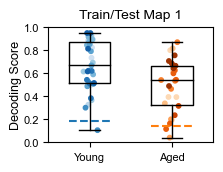

In [88]:
''' Plot Figure S5E (left) '''

fig, ax = plt.subplots(1,1, figsize = (2.125,1.5), sharey = False)
labels = ['Young','Aged']
w = 0.5
ax.set_title('Train/Test Map 1', fontsize=10)

sscore1_tog = [spatialscore1[y_sindspatial], spatialscore1[age_sindspatial]]
ax.boxplot(sscore1_tog, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax.hlines(np.mean(spatialshuffscore1[y_sindspatial]), 0.75, 1.25, color = 'C0', linestyle ='dashed', label = 'Young Shuffle')
ax.hlines(np.mean(spatialshuffscore1[age_sindspatial]), 1.75, 2.25, color = 'C1', linestyle ='dashed', label = 'Aged Shuffle')
ax.set_ylabel('Decoding Score', fontsize=9, labelpad=1)
ax.set_ylim([0,1])
ax.tick_params(labelsize = 8)

handles = []
for i in range(len(sscore1_tog)):
    y = sscore1_tog[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    ax.scatter(x, y, color = col_sessionspatial[i], edgecolors = col_sessionspatial[i], alpha = 1, s = 10)

plt.savefig(save_folder + 'S5Eleft.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S5Eleft.svg', dpi=400, bbox_inches='tight')
plt.show()

In [89]:
''' Mean Decoder Score Young vs. Aged Train/Test Map 1  '''
print('n young, aged RF sessions with k = 2, >10 spatial cells ')
print(len(y_sindspatial), len(age_sindspatial))

print('\nReal RESULTS:')
print('meandecoderscore1young ± SEM; meandecoderscore1_old ± SEM')
print(str(np.round(np.nanmean(spatialscore1[y_sindspatial]), 4)) + ' ± ' + str(np.round(stats.sem(spatialscore1[y_sindspatial]), 4)) + ' ; ' 
      + str(np.round(np.nanmean(spatialscore1[age_sindspatial]), 4)) + ' ± ' + str(np.round(stats.sem(spatialscore1[age_sindspatial]), 4)))

stat, p_diff = stats.ranksums(spatialscore1[y_sindspatial],spatialscore1[age_sindspatial])
print('stat = ' + str(stat))
print('p_session = ' + str(p_diff))

print('\nShuffle RESULTS:')
print('meandecoderscore1young ± SEM; meandecoderscore1_old ± SEM')
print(str(np.round(np.nanmean(spatialshuffscore1[y_sindspatial]), 4)) + ' ± ' + str(np.round(stats.sem(spatialshuffscore1[y_sindspatial]), 4)) + ' ; ' 
      + str(np.round(np.nanmean(spatialshuffscore1[age_sindspatial]), 4)) + ' ± ' + str(np.round(stats.sem(spatialshuffscore1[age_sindspatial]), 4)))

stat, p_diff = stats.ranksums(spatialshuffscore1[y_sindspatial],spatialshuffscore1[age_sindspatial])
print('stat = ' + str(stat))
print('p_session = ' + str(p_diff))

print('\nDiff Shuffle vs. Real RESULTS Young:')
stat, p_diff = stats.wilcoxon(spatialscore1[y_sindspatial],spatialshuffscore1[y_sindspatial],alternative = 'greater')
print('stat = ' + str(stat))
print('p_session = ' + str(p_diff))

print('\nDiff Shuffle vs. Real RESULTS Aged:')
stat, p_diff = stats.wilcoxon(spatialscore1[age_sindspatial],spatialshuffscore1[age_sindspatial],alternative = 'greater')
print('stat = ' + str(stat))
print('p_session = ' + str(p_diff))

n young, aged RF sessions with k = 2, >10 spatial cells 
35 26

Real RESULTS:
meandecoderscore1young ± SEM; meandecoderscore1_old ± SEM
0.6669 ± 0.037 ; 0.4883 ± 0.0457
stat = 2.6980240120607064
p_session = 0.006975240917682269

Shuffle RESULTS:
meandecoderscore1young ± SEM; meandecoderscore1_old ± SEM
0.1813 ± 0.0136 ; 0.1407 ± 0.0134
stat = 1.8813248516531413
p_session = 0.05992774241873921

Diff Shuffle vs. Real RESULTS Young:
stat = 630.0
p_session = 2.9103830456733704e-11

Diff Shuffle vs. Real RESULTS Aged:
stat = 350.0
p_session = 2.9802322387695312e-08


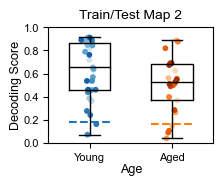

In [90]:
''' Plot Figure S5E (left middle) '''

fig, ax = plt.subplots(1,1, figsize = (2.125,1.5), sharey = False)
labels = ['Young','Aged']
w = 0.5
ax.set_title('Train/Test Map 2', fontsize=10)

sscore1_tog = [spatialscore2[y_sindspatial], spatialscore2[age_sindspatial]]
ax.boxplot(sscore1_tog, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax.hlines(np.mean(spatialshuffscore2[y_sindspatial]), 0.75, 1.25, color = 'C0', linestyle ='dashed', label = 'Young Shuffle')
ax.hlines(np.mean(spatialshuffscore2[age_sindspatial]), 1.75, 2.25, color = 'C1', linestyle ='dashed', label = 'Aged Shuffle')
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('Decoding Score', fontsize=9, labelpad=1)
ax.set_ylim([0,1])
ax.tick_params(labelsize = 8)

handles = []
for i in range(len(sscore1_tog)):
    y = sscore1_tog[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    ax.scatter(x, y, color = col_sessionspatial[i], edgecolors = col_sessionspatial[i], alpha = 1, s = 10)

plt.savefig(save_folder + 'S5Emiddleleft.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S5Emiddleleft.svg', dpi=400, bbox_inches='tight')
plt.show()

In [91]:
''' Mean Decoder Score Young vs. Aged Train/Test Map 2  '''
print('Real RESULTS:')
print('meandecoderscore2young ± SEM; meandecoderscore2_old ± SEM')
print(str(np.round(np.nanmean(spatialscore2[y_sindspatial]), 4)) + ' ± ' + str(np.round(stats.sem(spatialscore2[y_sindspatial]), 4)) + ' ; ' 
      + str(np.round(np.nanmean(spatialscore2[age_sindspatial]), 4)) + ' ± ' + str(np.round(stats.sem(spatialscore2[age_sindspatial]), 4)))

stat, p_diff = stats.ranksums(spatialscore2[y_sindspatial],spatialscore2[age_sindspatial])
print('stat = ' + str(stat))
print('p_session = ' + str(p_diff))

print('\nShuffle RESULTS:')
print('meandecoderscore2young ± SEM; meandecoderscore2_old ± SEM')
print(str(np.round(np.nanmean(spatialshuffscore2[y_sindspatial]), 4)) + ' ± ' + str(np.round(stats.sem(spatialshuffscore2[y_sindspatial]), 4)) + ' ; ' 
      + str(np.round(np.nanmean(spatialshuffscore2[age_sindspatial]), 4)) + ' ± ' + str(np.round(stats.sem(spatialshuffscore2[age_sindspatial]), 4)))

stat, p_diff = stats.ranksums(spatialshuffscore2[y_sindspatial],spatialshuffscore2[age_sindspatial])
print('stat = ' + str(stat))
print('p_session = ' + str(p_diff))

print('\nDiff Shuffle vs. Real RESULTS Young:')
stat, p_diff = stats.wilcoxon(spatialscore2[y_sindspatial],spatialshuffscore2[y_sindspatial],alternative = 'greater')
print('stat = ' + str(stat))
print('p_session = ' + str(p_diff))

print('\nDiff Shuffle vs. Real RESULTS Aged:')
stat, p_diff = stats.wilcoxon(spatialscore2[age_sindspatial],spatialshuffscore2[age_sindspatial],alternative = 'greater')
print('stat = ' + str(stat))
print('p_session = ' + str(p_diff))

Real RESULTS:
meandecoderscore2young ± SEM; meandecoderscore2_old ± SEM
0.6412 ± 0.0414 ; 0.4979 ± 0.0463
stat = 2.158419209648565
p_session = 0.030895253529112515

Shuffle RESULTS:
meandecoderscore2young ± SEM; meandecoderscore2_old ± SEM
0.1797 ± 0.0132 ; 0.166 ± 0.0137
stat = 0.5833565431482608
p_session = 0.5596533058546143

Diff Shuffle vs. Real RESULTS Young:
stat = 630.0
p_session = 2.9103830456733704e-11

Diff Shuffle vs. Real RESULTS Aged:
stat = 347.0
p_session = 1.043081283569336e-07


In [92]:
'''Collect mean of scores by age group for plotting'''

#Train on Map 1, test on Map 2
spatialscore1 = []
spatialshuffscore1 = []

#Train on Map 2, test on Map 1
spatialscore2 = []
spatialshuffscore2 = []

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        if d['2map'] == 1: 
            spatialscores = d['spatialscores']
            spatialshuffscores = d['spatialshuffscores']
            
            #retrieves score where trained & tested on Map 0
            spatialscore1 = np.append(spatialscore1, np.mean(spatialscores, axis = 1)[1])
            spatialshuffscore1 = np.append(spatialshuffscore1, np.mean(spatialshuffscores, axis = 1)[1])
            
            #retrieves score where trained & tested on Map 1
            spatialscore2 = np.append(spatialscore2, np.mean(spatialscores, axis = 1)[3])
            spatialshuffscore2 = np.append(spatialshuffscore2, np.mean(spatialshuffscores, axis = 1)[3])
            
        else:
            spatialscore1 = np.append(spatialscore1, np.nan)
            spatialshuffscore1 = np.append(spatialshuffscore1, np.nan)
        
            spatialscore2 = np.append(spatialscore2, np.nan)
            spatialshuffscore2 = np.append(spatialshuffscore2, np.nan)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

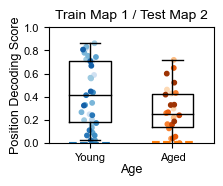

In [93]:
''' Plot Figure S5E (right middle) '''

fig, ax = plt.subplots(1,1, figsize = (2.125,1.5), sharey = False)
labels = ['Young','Aged']
w = 0.5
ax.set_title('Train Map 1 / Test Map 2', fontsize=10)

sscore1_tog = [spatialscore1[y_sindspatial], spatialscore1[age_sindspatial]]
ax.boxplot(sscore1_tog, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax.hlines(np.mean(spatialshuffscore1[y_sindspatial]), 0.75, 1.25, color = 'C0', linestyle ='dashed', label = 'Young Shuffle')
ax.hlines(np.mean(spatialshuffscore1[age_sindspatial]), 1.75, 2.25, color = 'C1', linestyle ='dashed', label = 'Aged Shuffle')
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('Position Decoding Score', fontsize=9, labelpad=1)
ax.set_ylim([0,1])
ax.tick_params(labelsize = 8)

handles = []
for i in range(len(sscore1_tog)):
    y = sscore1_tog[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    ax.scatter(x, y, color = col_sessionspatial[i], edgecolors = col_sessionspatial[i], alpha = 1, s = 10)

plt.savefig(save_folder + 'S5Emiddleright.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S5Emiddleright.svg', dpi=400, bbox_inches='tight')
plt.show()

In [94]:
''' Mean Decoder Score Young vs. Aged Train/Test Map 1/2 '''
print('Real RESULTS:')
print('meandecoderscore1young ± SEM; meandecoderscore1_old ± SEM')
print(str(np.round(np.nanmean(spatialscore1[y_sindspatial]), 4)) + ' ± ' + str(np.round(stats.sem(spatialscore1[y_sindspatial]), 4)) + ' ; ' 
      + str(np.round(np.nanmean(spatialscore1[age_sindspatial]), 4)) + ' ± ' + str(np.round(stats.sem(spatialscore1[age_sindspatial]), 4)))

stat, p_diff = stats.ranksums(spatialscore1[y_sindspatial],spatialscore1[age_sindspatial])
print('stat = ' + str(stat))
print('p_session = ' + str(p_diff))

print('\nShuffle RESULTS:')
print('meandecoderscore1young ± SEM; meandecoderscore1_old ± SEM')
print(str(np.round(np.nanmean(spatialshuffscore1[y_sindspatial]), 4)) + ' ± ' + str(np.round(stats.sem(spatialshuffscore1[y_sindspatial]), 4)) + ' ; ' 
      + str(np.round(np.nanmean(spatialshuffscore1[age_sindspatial]), 4)) + ' ± ' + str(np.round(stats.sem(spatialshuffscore1[age_sindspatial]), 4)))

stat, p_diff = stats.ranksums(spatialshuffscore1[y_sindspatial],spatialshuffscore1[age_sindspatial])
print('stat = ' + str(stat))
print('p_session = ' + str(p_diff))

print('\nDiff Shuffle vs. Real RESULTS Young:')
stat, p_diff = stats.wilcoxon(spatialscore1[y_sindspatial],spatialshuffscore1[y_sindspatial],alternative = 'greater')
print('stat = ' + str(stat))
print('p_session = ' + str(p_diff))

print('\nDiff Shuffle vs. Real RESULTS Aged:')
stat, p_diff = stats.wilcoxon(spatialscore1[age_sindspatial],spatialshuffscore1[age_sindspatial],alternative = 'greater')
print('stat = ' + str(stat))
print('p_session = ' + str(p_diff))

Real RESULTS:
meandecoderscore1young ± SEM; meandecoderscore1_old ± SEM
0.4315 ± 0.0475 ; 0.2768 ± 0.0398
stat = 2.1146674689124456
p_session = 0.03445829884931863

Shuffle RESULTS:
meandecoderscore1young ± SEM; meandecoderscore1_old ± SEM
-0.0011 ± 0.0046 ; 0.0065 ± 0.0042
stat = -1.1521291727178151
p_session = 0.24926799691462942

Diff Shuffle vs. Real RESULTS Young:
stat = 629.0
p_session = 5.820766091346741e-11

Diff Shuffle vs. Real RESULTS Aged:
stat = 346.0
p_session = 1.4901161193847656e-07


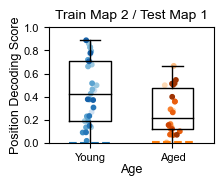

In [95]:
''' Plot Figure S5E (right) '''

fig, ax = plt.subplots(1,1, figsize = (2.125,1.5), sharey = False)
labels = ['Young','Aged']
w = 0.5
ax.set_title('Train Map 2 / Test Map 1', fontsize=10)

sscore1_tog = [spatialscore2[y_sindspatial], spatialscore2[age_sindspatial]]
ax.boxplot(sscore1_tog, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax.hlines(np.mean(spatialshuffscore2[y_sindspatial]), 0.75, 1.25, color = 'C0', linestyle ='dashed', label = 'Young Shuffle')
ax.hlines(np.mean(spatialshuffscore2[age_sindspatial]), 1.75, 2.25, color = 'C1', linestyle ='dashed', label = 'Aged Shuffle')
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('Position Decoding Score', fontsize=9, labelpad=1)
ax.set_ylim([0,1])
ax.tick_params(labelsize = 8)

handles = []
for i in range(len(sscore1_tog)):
    y = sscore1_tog[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    ax.scatter(x, y, color = col_sessionspatial[i], edgecolors = col_sessionspatial[i], alpha = 1, s = 10)

plt.savefig(save_folder + 'S5Eright.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S5Eright.svg', dpi=400, bbox_inches='tight')
plt.show()

In [96]:
''' Mean Decoder Score Young vs. Aged Train/Test Map 2/1 '''
print('Real RESULTS:')
print('meandecoderscore2young ± SEM; meandecoderscore2_old ± SEM')
print(str(np.round(np.nanmean(spatialscore2[y_sindspatial]), 4)) + ' ± ' + str(np.round(stats.sem(spatialscore2[y_sindspatial]), 4)) + ' ; ' 
      + str(np.round(np.nanmean(spatialscore2[age_sindspatial]), 4)) + ' ± ' + str(np.round(stats.sem(spatialscore2[age_sindspatial]), 4)))

stat, p_diff = stats.ranksums(spatialscore2[y_sindspatial],spatialscore2[age_sindspatial])
print('stat = ' + str(stat))
print('p_session = ' + str(p_diff))

print('\nShuffle RESULTS:')
print('meandecoderscore2young ± SEM; meandecoderscore2_old ± SEM')
print(str(np.round(np.nanmean(spatialshuffscore2[y_sindspatial]), 4)) + ' ± ' + str(np.round(stats.sem(spatialshuffscore2[y_sindspatial]), 4)) + ' ; ' 
      + str(np.round(np.nanmean(spatialshuffscore2[age_sindspatial]), 4)) + ' ± ' + str(np.round(stats.sem(spatialshuffscore2[age_sindspatial]), 4)))

stat, p_diff = stats.ranksums(spatialshuffscore2[y_sindspatial],spatialshuffscore2[age_sindspatial])
print('stat = ' + str(stat))
print('p_session = ' + str(p_diff))

print('\nDiff Shuffle vs. Real RESULTS Young:')
stat, p_diff = stats.wilcoxon(spatialscore2[y_sindspatial],spatialshuffscore2[y_sindspatial],alternative = 'greater')
print('stat = ' + str(stat))
print('p_session = ' + str(p_diff))

print('\nDiff Shuffle vs. Real RESULTS Aged:')
stat, p_diff = stats.wilcoxon(spatialscore2[age_sindspatial],spatialshuffscore2[age_sindspatial],alternative = 'greater')
print('stat = ' + str(stat))
print('p_session = ' + str(p_diff))

Real RESULTS:
meandecoderscore2young ± SEM; meandecoderscore2_old ± SEM
0.4458 ± 0.0475 ; 0.2688 ± 0.0386
stat = 2.4500974812226954
p_session = 0.01428175439323012

Shuffle RESULTS:
meandecoderscore2young ± SEM; meandecoderscore2_old ± SEM
0.0032 ± 0.0038 ; 0.0089 ± 0.0053
stat = -0.4229334937824891
p_session = 0.6723437848219764

Diff Shuffle vs. Real RESULTS Young:
stat = 628.0
p_session = 8.731149137020111e-11

Diff Shuffle vs. Real RESULTS Aged:
stat = 348.0
p_session = 7.450580596923828e-08


In [97]:
'''Collect mean of decoder scores by age group for plotting'''

spatialscore0 = [] #Train on Map 1, test on Map 1
spatialscore1 = [] #Train on Map 1, test on Map 2
spatialscore2 = [] #Train on Map 2, test on Map 2
spatialscore3 = [] #Train on Map 2, test on Map 1
spatialscore = [] #Train / Test random maps

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        if d['2map'] == 1: 
            spatialscores = d['spatialscores']
            
            #retrieves score where trained & tested on Map 0
            spatialscore0 = np.append(spatialscore0, np.mean(spatialscores, axis = 1)[0])
            spatialscore1 = np.append(spatialscore1, np.mean(spatialscores, axis = 1)[1])
            spatialscore2 = np.append(spatialscore2, np.mean(spatialscores, axis = 1)[2])
            spatialscore3 = np.append(spatialscore3, np.mean(spatialscores, axis = 1)[3])
            spatialscore = np.append(spatialscore, np.mean(spatialscores, axis = 1)[-1])
            
        else:
            spatialscore0 = np.append(spatialscore0, np.nan)
            spatialscore1 = np.append(spatialscore1, np.nan)
            spatialscore2 = np.append(spatialscore2, np.nan)
            spatialscore3 = np.append(spatialscore3, np.nan)
            spatialscore = np.append(spatialscore, np.nan)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

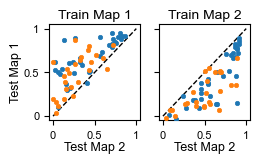

In [98]:
'''Plot Results of Training/Testing on the Same vs Different Maps (Figure S5F)'''

# plot performance same train/test vs. different train/test
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(2.6, 1.25), sharey = True) 
#f.suptitle('Decoder Performance by Train/Test Pairing & Age Group')

DOT_SIZE = 10
DOT_LW = 0.5
UNITY_WIDTH = 1
SEM_WIDTH = 0.8

avg_0to0 = spatialscore0
avg_0to1 = spatialscore1
avg_1to1 = spatialscore2
avg_1to0 = spatialscore3
avg_rand = spatialscore0

# train on map 0, test on map 0 vs. test on map 1
ax0.scatter(avg_0to1[y_sindspatial], avg_0to0[y_sindspatial],
            facecolors='C0', edgecolors='C0', 
            s=DOT_SIZE, lw=DOT_LW, zorder=3, label = 'Young')   
ax0.scatter(avg_0to1[age_sindspatial], avg_0to0[age_sindspatial],
            facecolors='C1', edgecolors='C1', 
            s=DOT_SIZE, lw=DOT_LW, zorder=3, label = 'Aged')   

# train on map 1, test on map 1 vs. test on map 0
ax1.scatter(avg_1to1[y_sindspatial], avg_1to0[y_sindspatial],
            facecolors='C0', edgecolors='C0', 
            s=DOT_SIZE, lw=DOT_LW, zorder=3, label = 'Young')
ax1.scatter(avg_1to1[age_sindspatial], avg_1to0[age_sindspatial],
            facecolors='C1', edgecolors='C1', 
            s=DOT_SIZE, lw=DOT_LW, zorder=3, label = 'Aged')

# plot unity lines + shuffle/best lines
ax0.plot([0, 1], [0, 1], '--k', lw=UNITY_WIDTH, alpha=1)
ax1.plot([0, 1], [0, 1], '--k', lw=UNITY_WIDTH, alpha=1)

# label everything
ax0.set_title('Train Map 1', fontsize=10, pad=4)
ax0.set_ylabel('Test Map 1', fontsize=9, labelpad=1)
ax0.set_xlabel('Test Map 2', fontsize=9, labelpad=1)
ax0.set_ylim([-0.05, 1.05])
ax0.set_xlim([-0.05, 1.05])
ax0.set_xticks([0, 0.5, 1])
ax0.set_xticklabels([0, 0.5, 1])
ax0.set_yticks([0, 0.5, 1])
ax0.set_yticklabels([0, 0.5, 1])

ax1.set_title('Train Map 2', fontsize=10, pad=4)
#ax1.set_ylabel('Test Map 1', fontsize=9, labelpad=1)
ax1.set_xlabel('Test Map 2', fontsize=9, labelpad=1)
ax1.set_ylim([-0.05, 1.05])
ax1.set_xlim([-0.05, 1.05])
ax1.set_xticks([0, 0.5, 1])
ax1.set_xticklabels([0, 0.5, 1])
ax1.set_yticks([0, 0.5, 1])
ax1.set_yticklabels([0, 0.5, 1])

ax0.tick_params(which='major', labelsize=8)
ax1.tick_params(which='major', labelsize=8)
#ax1.legend(fontsize = 8)
#ax0.legend(fontsize = 8)

f.savefig(save_folder + 'S5F.png', dpi=400, bbox_inches='tight')
f.savefig(save_folder + 'S5F.svg', dpi=400, bbox_inches='tight')
plt.show()

In [99]:
'''Statistical Comparison of Decoder Scores Train/Test Same vs. Different by Age Group & Together'''

allsind = np.union1d(y_sindspatial,age_sindspatial)

# train/test map 0 vs. map 1 on young mice
m0vsm1_stat, m0vsm1_p = stats.ranksums(avg_0to0[y_sindspatial], avg_1to1[y_sindspatial])
print('YOUNG train/test map 0 vs. map 1: p = ' + str(m0vsm1_p))

# train/test map 0 vs. map 1 on aged mice
m0vsm1_stat, m0vsm1_p = stats.ranksums(avg_0to0[age_sindspatial], avg_1to1[age_sindspatial])
print('AGED train/test map 0 vs. map 1: p = ' + str(m0vsm1_p))

# train/test map 0 vs. map 1 on both age groups of mice
m0vsm1_stat, m0vsm1_p = stats.ranksums(avg_0to0[allsind], avg_1to1[allsind])
print('ALL train/test map 0 vs. map 1: p = ' + str(m0vsm1_p))

# train/test map 0 vs. map 1 vs. both on young mice
m0vsm1_stat, m0vsm1_p = stats.kruskal(avg_0to0[y_sindspatial], avg_1to1[y_sindspatial], avg_rand[y_sindspatial])
print('\nYOUNG train/test map 0 vs. map 1 vs. both (Kruskal): p = ' + str(m0vsm1_p))

# train/test map 0 vs. map 1 vs. both on aged mice
m0vsm1_stat, m0vsm1_p = stats.kruskal(avg_0to0[age_sindspatial], avg_1to1[age_sindspatial], avg_rand[age_sindspatial])
print('AGED train/test map 0 vs. map 1 vs. both (Kruskal): p = ' + str(m0vsm1_p))

# train/test map 0 vs. map 1 vs. both on both age groups of mice
m0vsm1_stat, m0vsm1_p = stats.kruskal(avg_0to0[allsind], avg_1to1[allsind], avg_rand[allsind])
print('ALL train/test map 0 vs. map 1 vs. both (Kruskal): p = ' + str(m0vsm1_p))

# train/test same map vs. other map
same_to_same = np.append(avg_0to0[y_sindspatial], avg_1to1[y_sindspatial])
diff_to_diff = np.append(avg_0to1[y_sindspatial], avg_1to0[y_sindspatial])
sameVSdiff_stat, sameVSdiff_p = stats.wilcoxon(same_to_same, diff_to_diff, alternative = 'greater')
print('\nYOUNG train/test same vs. train/test different: p = ' + str(sameVSdiff_p))
print('n = ' + str(same_to_same.shape[0]) + ' model pairs')

same_to_same = np.append(avg_0to0[age_sindspatial], avg_1to1[age_sindspatial])
diff_to_diff = np.append(avg_0to1[age_sindspatial], avg_1to0[age_sindspatial])
sameVSdiff_stat, sameVSdiff_p = stats.wilcoxon(same_to_same, diff_to_diff, alternative = 'greater')
print('\nAGED train/test same vs. train/test different: p = ' + str(sameVSdiff_p))
print('n = ' + str(same_to_same.shape[0]) + ' model pairs')

same_to_same = np.append(avg_0to0[allsind], avg_1to1[allsind])
diff_to_diff = np.append(avg_0to1[allsind], avg_1to0[allsind])
sameVSdiff_stat, sameVSdiff_p = stats.wilcoxon(same_to_same, diff_to_diff, alternative = 'greater')
print('\nALL train/test same vs. train/test different: p = ' + str(sameVSdiff_p))
print('n = ' + str(same_to_same.shape[0]) + ' model pairs')

YOUNG train/test map 0 vs. map 1: p = 0.6426687804346658
AGED train/test map 0 vs. map 1: p = 0.8547886780140799
ALL train/test map 0 vs. map 1: p = 0.8357144486444298

YOUNG train/test map 0 vs. map 1 vs. both (Kruskal): p = 0.8657010712698955
AGED train/test map 0 vs. map 1 vs. both (Kruskal): p = 0.9777731221940712
ALL train/test map 0 vs. map 1 vs. both (Kruskal): p = 0.9716592274665142

YOUNG train/test same vs. train/test different: p = 2.1159745168609683e-13
n = 70 model pairs

AGED train/test same vs. train/test different: p = 5.557094833485794e-10
n = 52 model pairs

ALL train/test same vs. train/test different: p = 1.5044123596042563e-21
n = 122 model pairs
